In [37]:
# Data management
import pandas as pd 
import os 
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# Data processing and unit conversions
import numpy as np
import ast
import scipy
from scipy.spatial.transform import Rotation

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch

## Load data

##### Basic preprocessing functions

In [38]:
def expand_coordinates(df):
    """Reads coordinates (stored as tuples in the CSV) into separate columns"""
    for col in df.columns:
        if str(df[col][0]).startswith('('): # check if tuple
            if type(df[col][0]) == str: # check if tuple is stored as string
                df[col] = df[col].apply(ast.literal_eval) # convert string -> tuple
            n_dims = len(df[col][0]) # inspect first element: 2D, 3D or 4D coordinates
            suffix = 'WXYZ' if n_dims==4 else 'XYZ' # if 4D coordinates (quaternion), the first is W
            new_col_labels = [col+suffix[i] for i in range(n_dims)] # labels with suffix
            new_columns = pd.DataFrame(df[col].to_list(), index=df.index) # expand tuples to separate colunms
            df[new_col_labels] = new_columns

def add_conditions_from_trial_data(df, trial_data, conditions):
    """Lookup the trial conditions in trial_data and add to df"""
    for condition in conditions:
        lookup = trial_data.set_index('TrialIdentifier')[condition].to_dict() # map ID -> condition
        df[condition] = df.TrialIdentifier.replace(lookup) # add condition to df

def quat_to_euler(x):
    if type(x) == str:
        quat_tuple = ast.literal_eval(x) # convert string -> tuple
    quat_obj = Rotation.from_quat(quat_tuple)
    # return quat_obj.as_euler('xyz', degrees=True)
    return quat_obj.as_euler('XYZ', degrees=True)

def quat_to_dir(x):
    if type(x) == str:
        quat_tuple = ast.literal_eval(x) # convert string -> tuple
    quat_obj = Rotation.from_quat(quat_tuple)
    return tuple(quat_obj.apply([0,0,1]))

def preprocess_data(exp_data, trial_configs=None):
    if trial_configs is None:
        trial_configs = exp_data['TrialConfigRecord']

    for data_key in exp_data.keys():
        dataframe = exp_data[data_key]

        # Copy some useful columns from the TrialConfigRecord dataframe to the other dataframes
        if data_key != 'TrialConfigRecord':
            add_conditions_from_trial_data(dataframe,
                                                                         trial_configs,
                                                                         ['ExperimentalTask', 'Block', 'GazeCondition', 'Subject'])

        # Convert Quaternions to normalized direction vector (in separate column)
        rot_cols = [col for col in dataframe.columns if 'Rot' in col]
        if rot_cols:
            dir_cols = [col.replace('Rot', 'Dir') for col in rot_cols]
            dataframe[dir_cols] = dataframe.apply({col: quat_to_dir for col in rot_cols})

        # Put coordinates in separate columns (instead of tuples)
        expand_coordinates(dataframe)

    return


##### Basic save/load functions

In [39]:
def save_preprocessed_data(exp_data, calibr_data, data_dir):
    for data_key, dataframe in exp_data.items():
        fn = os.path.join(data_dir,'_preprocessed',f'{data_key}.tsv')
        dataframe.to_csv(fn, sep = '\t', index=False)

    for data_key, dataframe in calibr_data.items():
        fn = os.path.join(data_dir,'_preprocessed',f'calibrationTest_{data_key}.tsv')
        dataframe.set_index('TrialIdentifier').to_csv(fn, sep = '\t', index=False)

def load_preprocessed_data(data_dir):
    exp_data, calibr_data = dict(), dict()
    path = os.path.join(data_dir,'_preprocessed')
    files = os.listdir(path)
    for fn in files:
        data_key = fn.replace('calibrationTest_', '').replace('.tsv', '')
        if 'calibration' in fn:
            calibr_data[data_key] = pd.read_csv(os.path.join(path,fn),sep='\t')
        else:
            exp_data[data_key] = pd.read_csv(os.path.join(path,fn),sep='\t')
    return exp_data, calibr_data

def get_filenames(subjects, data_dir, data_keys=None):
    """Returns dict with filenames for all specified subjects found in the data 
    directory. The filenames are indexed by record type. """
    # Initialize dict with filenames (categorized by record type)
    if data_keys is None:
        data_keys = ['TrialConfigRecord', 'SingleEyeDataRecordR', 'SingleEyeDataRecordL',
                    'SingleEyeDataRecordC', 'EyeTrackerDataRecord', 'EngineDataRecord']
    data_files = {k: [] for k in data_keys}
    calibr_files = {k: [] for k in data_keys}

    # Add all files per subject
    for subj in subjects:
        base_path = os.path.join(data_dir,subj)
        listdir = sorted([os.path.join(base_path,fn) for fn in os.listdir(base_path) if 'tsv' in fn])
        for key in data_keys:
            data_files[key] += [fn for fn in listdir if (key in fn) and (not 'calibration' in fn)]
            calibr_files[key] += [fn for fn in listdir if (key in fn) and ('calibration' in fn)]
    calibr_files = {k: v for k, v in calibr_files.items() if v} # remove empty keys
    return data_files, calibr_files

def load_data_from_filenames(filenames_dict, downsample=None, **pd_kwargs):
    """For each item in filenames dict, reads the listed TSV files and concatenate
     in a single dataframe. Returns dict with pandas dataframes."""
    # The output dict
    exp_data = dict()
    downsample_rate = 1 if downsample is None else downsample

    # Loop through data keys ('TrialConfigRecord', 'SingleEyeDataRecordC', 'EngineDataRecord', etc.)
    for data_key, filenames in filenames_dict.items():

        # Put all trials (for all subjects) in a single dataframe
        dataframe = None
        for i in range(len(filenames)):

            # Read new rows from file
            new = pd.read_csv(filenames[i],sep = '\t', **pd_kwargs)
            
            if data_key in ['EngineDataRecord', 'SingleEyeDataRecordR', 'SingleEyeDataRecordL', 'SingleEyeDataRecordC']:
                new = new[::downsample_rate].copy()

            # Get block number, trial and subject from filename and directory
            path, fn = os.path.split(filenames[i])
            subject = os.path.basename(path).replace('_','')
            block = int(fn[0:2])
            relative_trial_number = int(fn[3:5])
            identifier = f'{subject}B{block}T{relative_trial_number}'
            new['Subject'] = subject
            new['Block'] = block
            new['RelativeTrialNumber'] = relative_trial_number
            new['TrialIdentifier'] = identifier

            # Append new rows to the dataframe
            if dataframe is None:
                dataframe = new
            else:
                dataframe = pd.concat([dataframe,new], ignore_index = True)

        # Add the dataframe to the output dict
        exp_data[data_key] = dataframe
    return exp_data

##### Load the dataframes

In [40]:
# Which data to read
DATA_DIR = '../_Datasets/SPVGazeData'
# DATA_DIR = '/content/gdrive/MyDrive/SPVGazeData'
SUBJECTS = {'S35', 'S37', 'S38', 'S39', 'S40', 'S41', 'S42', 'S45', 'S46',
            'S47', 'S49', 'S50', 'S51', 'S52', 'S53', 'S54', 'S55', 'S56', 'S57'} # Pilot subjects:"'S30', 'S30_','S31', 's33', 's33_', 'S34', 'S34_'"
LOAD_PREPROCESSED = False
DATA_KEYS = ['TrialConfigRecord'] #, 'EngineDataRecord', 'SingleEyeDataRecordC']
DOWNSAMPLE = 100


if LOAD_PREPROCESSED:
    
    ## Load preprocessed data
    EXP_DATA, CALIBR_DATA = load_preprocessed_data(DATA_DIR)

    ## Check whether subjects are missing
    existing = EXP_DATA['TrialConfigRecord'].Subject.unique()
    new_subjects = [subj for subj in SUBJECTS if subj[:3] not in existing]

    ## If not in dataframe, add new subjects 
    if new_subjects:
        print(f"Adding new subjects: {new_subjects}")
        # Load filenames 
        data_files, calibr_files = get_filenames(new_subjects,DATA_DIR)

        # Load the trial data
        new_exp_data = load_data_from_filenames(data_files)
        new_clb_data = load_data_from_filenames(calibr_files, )

        # Preprocess data
        preprocess_data(new_exp_data)
        preprocess_data(new_clb_data, trial_configs=new_exp_data['TrialConfigRecord'])

        # Add to dataframe
        for data_key in new_exp_data.keys():
            EXP_DATA[data_key] = pd.concat([EXP_DATA[data_key],
                                                                            new_exp_data[data_key]],
                                                                            ignore_index = True)
        for data_key in new_clb_data.keys():
            CALIBR_DATA[data_key] = pd.concat([CALIBR_DATA[data_key],
                                                                            new_clb_data[data_key]],
                                                                            ignore_index = True)
else:
    
    ## Load filenames 
    data_files, calibr_files = get_filenames(SUBJECTS,DATA_DIR, DATA_KEYS)

    ## Load the trial data
    EXP_DATA = load_data_from_filenames(data_files, DOWNSAMPLE)
    CALIBR_DATA = load_data_from_filenames(calibr_files, DOWNSAMPLE)

    ## Preprocess data
    preprocess_data(EXP_DATA)
    preprocess_data(CALIBR_DATA, trial_configs=EXP_DATA['TrialConfigRecord'])

SUBJECTS = SUBJECTS.intersection(EXP_DATA['TrialConfigRecord'].Subject.unique())

In [41]:
# save_preprocessed_data(EXP_DATA, CALIBR_DATA,DATA_DIR)

In [42]:
# # Use data from subjects only
# for data_key in EXP_DATA.keys():
#         subj_mask = EXP_DATA[data_key].Subject.isin(SUBJECTS)
#         EXP_DATA[data_key] = EXP_DATA[data_key].loc[subj_mask].copy()
# for data_key in CALIBR_DATA.keys():
#         subj_mask = CALIBR_DATA[data_key].Subject.isin(SUBJECTS)
#         CALIBR_DATA[data_key] = CALIBR_DATA[data_key].loc[subj_mask].copy()

## Eye tracking data analysis

##### Plotting functions

In [43]:
def plot_gaze_maps(data):
    fig, axs = plt.subplots(1,3,figsize=(12,4), dpi=100)
    for i, condition in enumerate(data.GazeCondition.unique()):
        mask = data.GazeCondition == condition
        plot_single_gaze_map(data.loc[mask], ax=axs[i], title=condition)
    return fig, axs

def plot_single_gaze_map(data, fig=None, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=100)
    ax.scatter(data['GazeDirectionNormInEyeX'],
                            data['GazeDirectionNormInEyeY'], alpha = 0.002, color='#9e1111')
    ax.axis('square')
    ax.set(xlim = [-0.8,0.8],
                        ylim = [-0.8,0.8], title=title)
    return fig, ax


### Avg. Displacement

In [44]:
data = EXP_DATA['SingleEyeDataRecordC'].copy()

KeyError: 'SingleEyeDataRecordC'

In [45]:
def plot_displacement(trial_identifier, remove_missing=False):
    eye_data = EXP_DATA['SingleEyeDataRecordC'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()
    trial_data = EXP_DATA['TrialConfigRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy()
    engine_data =  EXP_DATA['EngineDataRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()

    
    fig, ax = plt.subplots(figsize=(15,3),dpi=100)
    
     # Calculate elapsed time for each trial
    for data in [eye_data, engine_data]:
        start_of_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
        t_0 = data.where(start_of_trial).TimeStamp.ffill()
        data['TimeElapsed'] = (data.TimeStamp - t_0) * 1e-7
    
    # Remove missing data
    eye_data['Missing'] = eye_data.GazeDirectionNormInEyeX == -1
    if remove_missing:
        eye_data = eye_data.loc[~eye_data.Missing]
    
    # Ignore data after trial finish
    eye_data = eye_data.loc[eye_data.TimeElapsed <= trial_data.TrialDuration]
    
    # Extract time series
    t = eye_data.TimeElapsed
    pos_x = eye_data.GazeDirectionNormInEyeX
    pos_y = eye_data.GazeDirectionNormInEyeY
   
    diff_x = pos_x.diff()
    diff_y = pos_y.diff()


    # Plot x and y position of the eye
#     ax.plot(diff_x, label = 'diff_x')
#     ax.plot(diff_y, label = 'diff_y')
    
    ax.hist(diff_x, alpha=0.3, bins=150, label = 'diff_x')
    ax.hist(diff_y, alpha=0.3, bins=150, label = 'diff_y')
    
#     # Find peaks 
#     x_peaks = scipy.signal.find_peaks(pos_x, prominence=peak_prominence)[0].tolist() # local maxima
#     x_peaks += scipy.signal.find_peaks(-pos_x, prominence=peak_prominence)[0].tolist() #local minima
#     y_peaks = scipy.signal.find_peaks(pos_y, prominence=peak_prominence)[0].tolist()
#     y_peaks += scipy.signal.find_peaks(-pos_y, prominence=peak_prominence)[0].tolist()

#     ax.plot(t.iloc[x_peaks], pos_x.iloc[x_peaks], 'r.', label = 'peak')
#     ax.plot(t.iloc[y_peaks], pos_y.iloc[y_peaks], 'r.' )

        
#     # Plot reported events as vertical lines    
#     events = engine_data.ReportedEventsCount.diff() > 0
#     for t in engine_data.loc[events].TimeElapsed:        
#         ax.axvline(t, color='k')
        
    ax.legend() 
    ax.set(title=f'{trial_identifier} ({trial_data.GazeCondition})',
#            xlabel = 'Time [s]',
           xlim = [-0.4, 0.4],
           ylabel = 'Rel. displacement.')  

    return fig, ax
    
_, ax0 = plot_displacement('S54B9T0', remove_missing=True)
_, ax1 = plot_displacement('S54B9T1', remove_missing=True)
_, ax2 = plot_displacement('S54B9T2', remove_missing=True)

KeyError: 'SingleEyeDataRecordC'

##### Generate gaze plots

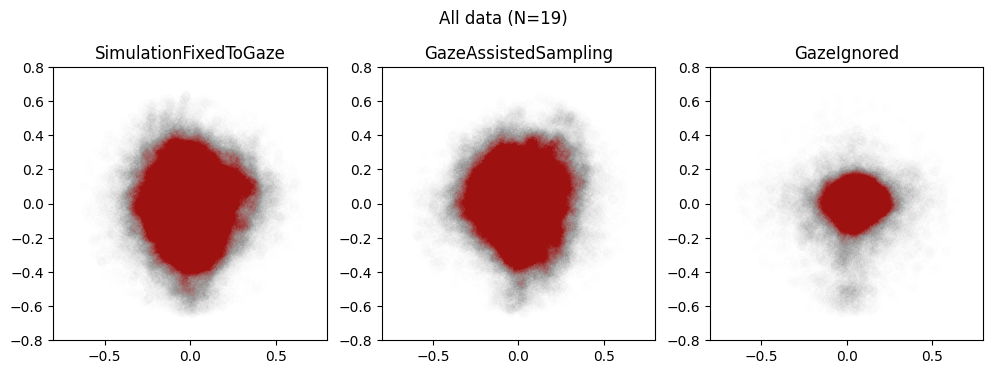

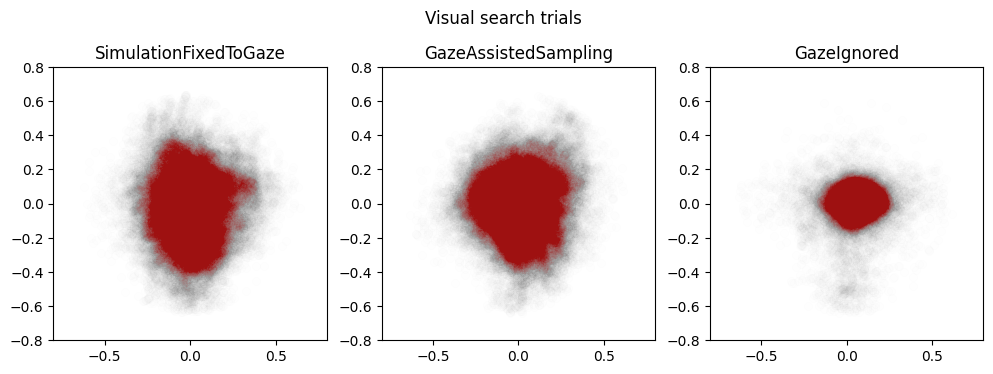

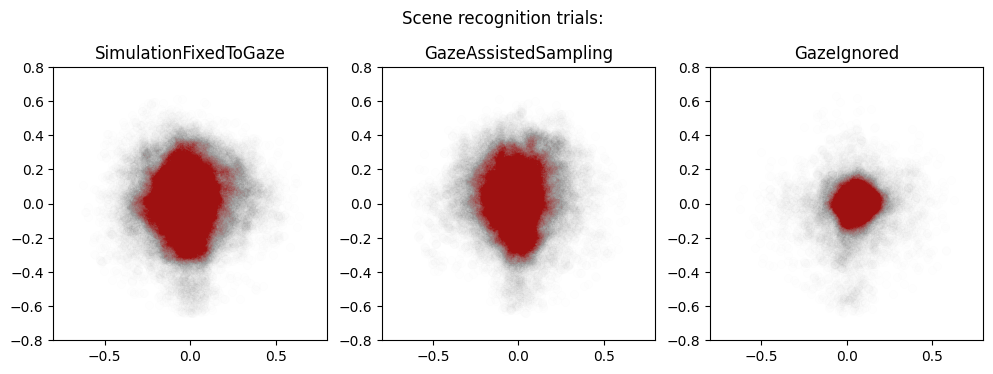

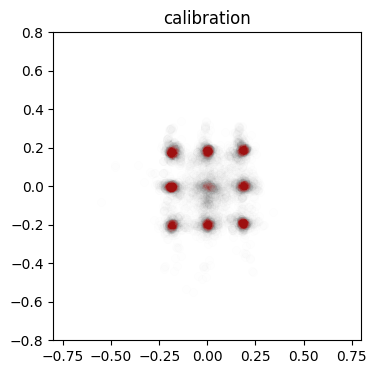

In [8]:
## Which data to show
subjects = SUBJECTS # or specify list of subjects of interest

## Load the eye tracking data
data = EXP_DATA['SingleEyeDataRecordC'].copy()
data = data.loc[data.Block>0] # Exclude practice block
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects

 
# All data
fig,_ = plot_gaze_maps(data)
fig.suptitle(f'All data (N={len(subjects)})')

# Visual search data
fig,_= plot_gaze_maps(data.loc[data.ExperimentalTask == 'VisualSearch'])
fig.suptitle('Visual search trials')

# Scene recognition data
fig,_= plot_gaze_maps(data.loc[data.ExperimentalTask == 'SceneRecognition'])
fig.suptitle('Scene recognition trials:')

# Calibration data
data = CALIBR_DATA['SingleEyeDataRecordC'].copy()
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects
_ = plot_single_gaze_map(data, title='calibration')

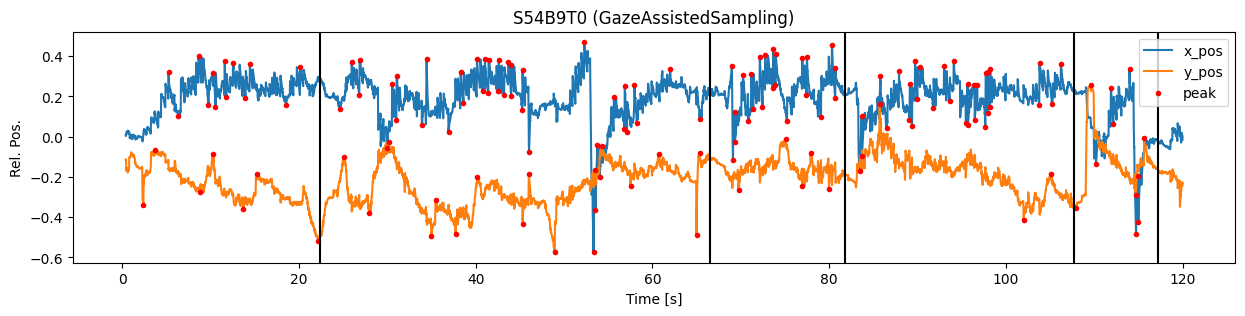

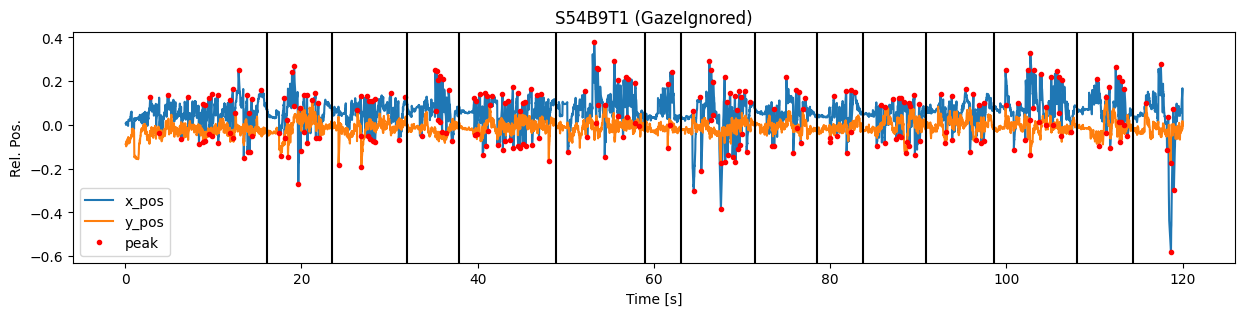

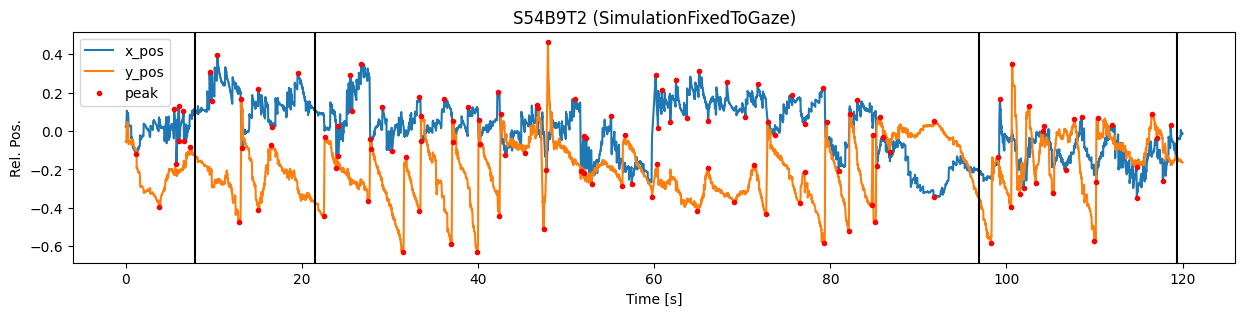

In [27]:
def plot_time_series(trial_identifier, remove_missing=False, peak_prominence=0.15):
    eye_data = EXP_DATA['SingleEyeDataRecordC'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()
    trial_data = EXP_DATA['TrialConfigRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy()
    engine_data =  EXP_DATA['EngineDataRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()

    
    fig, ax = plt.subplots(figsize=(15,3),dpi=100)
    
     # Calculate elapsed time for each trial
    for data in [eye_data, engine_data]:
        start_of_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
        t_0 = data.where(start_of_trial).TimeStamp.ffill()
        data['TimeElapsed'] = (data.TimeStamp - t_0) * 1e-7
    
    # Remove missing data
    eye_data['Missing'] = eye_data.GazeDirectionNormInEyeX == -1
    if remove_missing:
        eye_data = eye_data.loc[~eye_data.Missing]
    
    # Ignore data after trial finish
    eye_data = eye_data.loc[eye_data.TimeElapsed <= trial_data.TrialDuration]
    
    # Extract time series
    t = eye_data.TimeElapsed
    pos_x = eye_data.GazeDirectionNormInEyeX
    pos_y = eye_data.GazeDirectionNormInEyeY
    
    # Plot x and y position of the eye
    ax.plot(t, pos_x, label = 'x_pos')
    ax.plot(t, pos_y, label = 'y_pos')
    
    # Find peaks 
    x_peaks = scipy.signal.find_peaks(pos_x, prominence=peak_prominence)[0].tolist() # local maxima
    x_peaks += scipy.signal.find_peaks(-pos_x, prominence=peak_prominence)[0].tolist() #local minima
    y_peaks = scipy.signal.find_peaks(pos_y, prominence=peak_prominence)[0].tolist()
    y_peaks += scipy.signal.find_peaks(-pos_y, prominence=peak_prominence)[0].tolist()

    ax.plot(t.iloc[x_peaks], pos_x.iloc[x_peaks], 'r.', label = 'peak')
    ax.plot(t.iloc[y_peaks], pos_y.iloc[y_peaks], 'r.' )

        
    # Plot reported events as vertical lines    
    events = engine_data.ReportedEventsCount.diff() > 0
    for t in engine_data.loc[events].TimeElapsed:        
        ax.axvline(t, color='k')
        
    ax.legend() 
    ax.set(title=f'{trial_identifier} ({trial_data.GazeCondition})',
           xlabel = 'Time [s]',
           ylabel = 'Rel. Pos.')  

    return fig, ax
    
_, ax0 = plot_time_series('S54B9T0', remove_missing=True)
_, ax1 = plot_time_series('S54B9T1', remove_missing=True)
_, ax2 = plot_time_series('S54B9T2', remove_missing=True)

Example output:

![example_1](Out/timeseries_0.png)
![example_2](Out/timeseries_1.png)
![example_3](Out/timeseries_2.png)

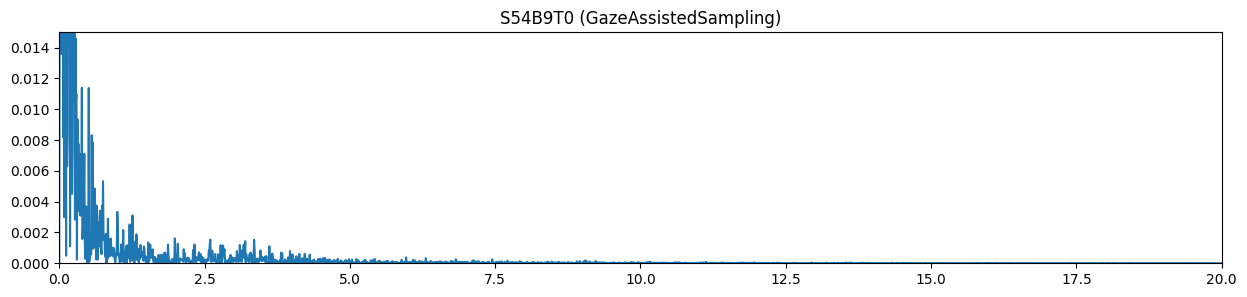

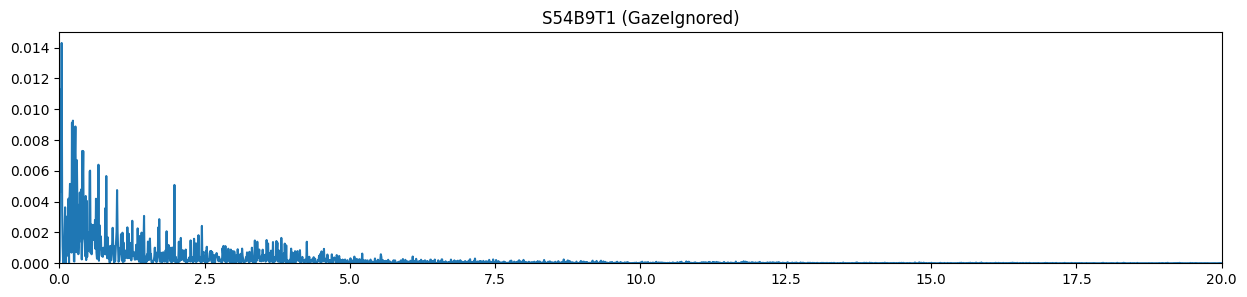

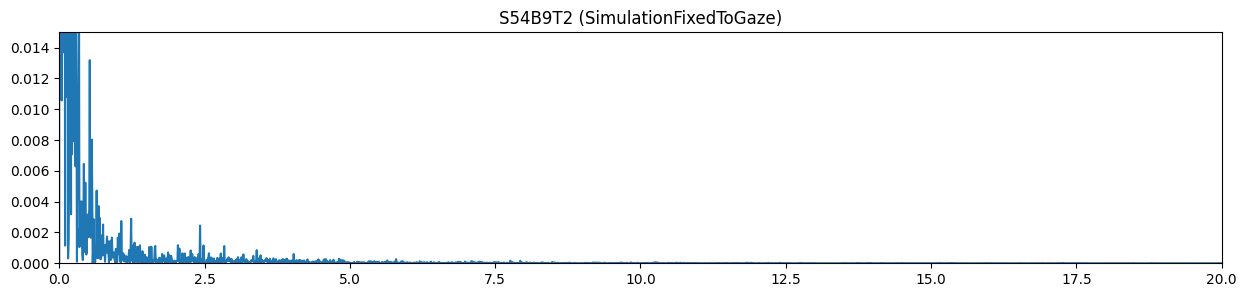

In [38]:
def plot_periodogram(trial_identifier, remove_missing=False, fs=65):
    eye_data = EXP_DATA['SingleEyeDataRecordC'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()
    trial_data = EXP_DATA['TrialConfigRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy()
    engine_data =  EXP_DATA['EngineDataRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()

    
    fig, ax = plt.subplots(figsize=(15,3),dpi=100)
    
     # Calculate elapsed time for each trial
    for data in [eye_data, engine_data]:
        start_of_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
        t_0 = data.where(start_of_trial).TimeStamp.ffill()
        data['TimeElapsed'] = (data.TimeStamp - t_0) * 1e-7
    
    # Remove missing data
    eye_data['Missing'] = eye_data.GazeDirectionNormInEyeX == -1
    if remove_missing:
        eye_data = eye_data.loc[~eye_data.Missing]
    
    # Ignore data after trial finish
    eye_data = eye_data.loc[eye_data.TimeElapsed <= trial_data.TrialDuration]
    
    # Extract time series
    t = eye_data.TimeElapsed
    pos_x = eye_data.GazeDirectionNormInEyeX
    pos_y = eye_data.GazeDirectionNormInEyeY

#     speed = np.sqrt(pos_x**2 + pos_y**2) / t
    
    
    f, Pxx_den = scipy.signal.periodogram(pos_x,fs)
    ax.plot(f, Pxx_den)
            
#     ax.legend() 
    ax.set(title = f'{trial_identifier} ({trial_data.GazeCondition})',
          ylim = [0,0.015],
          xlim = [0,20])
           
    ax.set()

    return fig, ax
    
_, ax0 = plot_periodogram('S54B9T0', remove_missing=True)
_, ax1 = plot_periodogram('S54B9T1', remove_missing=True)
_, ax2 = plot_periodogram('S54B9T2', remove_missing=True)

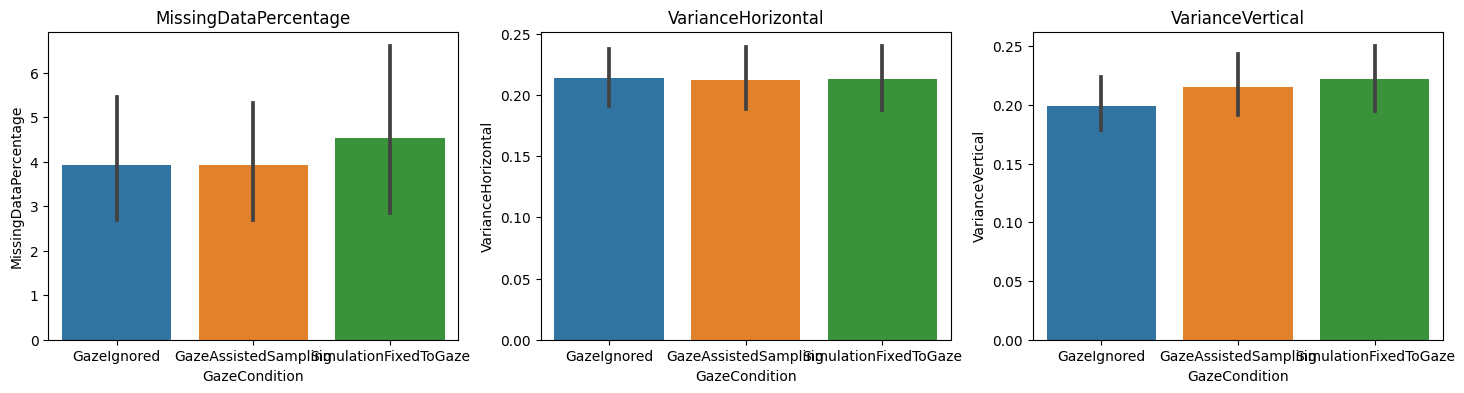

In [39]:
def average(data, y, group='Subject', x='GazeCondition', apply_function=None):
    """Averages the endpoint variables <y> (list of column names) absover the grouping variable <group>."""
    avg = data.loc[:, [group,]+[x,] + y]
    if apply_function is None or apply_function=='mean':
        avg = avg.groupby([group, x]).mean()
    elif apply_function=='std':
        avg = avg.groupby([group, x]).std()
    else:
        avg = avg.groupby([group, x]).agg(apply_function)
    return avg.reset_index()

def bar_plots(data, endpoints, x='GazeCondition', **kwargs):
    n_figs = len(endpoints)
    fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
    for i, y in enumerate(endpoints):
        sns.barplot(data=data, x=x, y=y, ax= axs[i], order = HUE_ORDER, **kwargs)
        axs[i].set(title=y)
    return fig, axs

def swarm_plots(data, endpoints, group, axs=None, fig=None, jitter=0.2, alpha=0.3):
    if axs is None:
        n_figs = len(endpoints)
        fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
        
    x = data.GazeCondition.replace(X_TICKVALUES)
    x += jitter * (np.random.rand(len(x)) -.5) 
    x = x.sort_values()
    sorted_data = data.loc[x.index]


data = EXP_DATA['SingleEyeDataRecordC'].copy()


# Calculate elapsed time for each trial
start_of_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
t_0 = data.where(start_of_trial).TimeStamp.ffill()
data['TimeElapsed'] = (data.TimeStamp - t_0) * 1e-7

# Mark missing data (for later removal)
data['Missing'] = data.GazeDirectionNormInEyeX == -1
group_idx = ['Subject', 'TrialIdentifier','GazeCondition']
perc_missing = data.groupby(group_idx).Missing.mean() * 100
reindexed = data.set_index(group_idx)
reindexed['MissingDataPercentage'] = perc_missing.loc[reindexed.index]

reindexed['VarianceHorizontal'] = data.groupby(group_idx).GazeDirectionNormInEyeX.std()
reindexed['VarianceVertical'] = data.groupby(group_idx).GazeDirectionNormInEyeY.std()

# Plot data averaged over subjects
endpoints = ['MissingDataPercentage', 'VarianceHorizontal', 'VarianceVertical']
group = 'Subject'
avg = average(data=reindexed.reset_index(), y=endpoints)

fig, axs = bar_plots(data=avg, endpoints=endpoints)
swarm_plots(data=avg, endpoints=endpoints, group=group, axs=axs)

## Trial config analysis

##### Plotting functions

In [46]:
HUE_ORDER = ['GazeIgnored', 'GazeAssistedSampling', 'SimulationFixedToGaze'] # Use consistent colors for conditions
X_TICKVALUES = {k:i for i,k in enumerate(HUE_ORDER)} # e.g.  e.g. {GazeIgnored: 0, SimulationFixedToGaze: 1, GazeAssistedSampling: 2}
COLOR_MAPPING = {k:f'C{i}' for i,k in enumerate(HUE_ORDER)} # e.g. {GazeIgnored: 'C0', SimulationFixedToGaze: 'C1', GazeAssistedSampling: 'C2'}

def violin_plots(data, endpoints):
    n_figs = len(endpoints)
    fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
    for i, y in enumerate(endpoints):
        sns.violinplot(data=data, x='GazeCondition', y=y, ax= axs[i], order = HUE_ORDER)
        axs[i].set(title=y)
    return fig, axs

def bar_plots(data, endpoints, x='GazeCondition', **kwargs):
    n_figs = len(endpoints)
    fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
    for i, y in enumerate(endpoints):
        sns.barplot(data=data, x=x, y=y, ax= axs[i], order = HUE_ORDER, **kwargs)
        axs[i].set(title=y)
    return fig, axs

def swarm_plots(data, endpoints, group, axs=None, fig=None, jitter=0.2, alpha=0.3):
    if axs is None:
        n_figs = len(endpoints)
        fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
        
    x = data.GazeCondition.replace(X_TICKVALUES)
    x += jitter * (np.random.rand(len(x)) -.5) 
    x = x.sort_values()
    sorted_data = data.loc[x.index]
    
    for i, y in enumerate(endpoints):
#         sns.swarmplot(data=data, x=x, y=y, ax= axs[i], order = HUE_ORDER, **kwargs)
#         sns.stripplot(data=data, x=x, y=y, ax= axs[i], order = HUE_ORDER, **kwargs)

        for category in data[group].unique():
            mask = sorted_data[group] == category
            colors = sorted_data.loc[mask,'GazeCondition'].replace(COLOR_MAPPING)
            axs[i].plot(x.loc[mask], sorted_data.loc[mask,y], linestyle=':', color='k', alpha=alpha )
            axs[i].scatter(x.loc[mask], sorted_data.loc[mask,y], linestyle=':',color=colors, )
            axs[i].set(title=y)
    return fig, axs


def paired_wilcoxon(data, group, endpoints=['ReportedSubjectiveRating', 'TrialDuration', 'CorrectResponse']):
    
    cond1, cond2, cond3 = HUE_ORDER
    pairs = [(cond1, cond2), (cond2, cond3), (cond1, cond3)]
    
    # Extract data per condition
    subdata = dict()
    for cond in [cond1, cond2, cond3]:
        subdata[cond] = data.loc[data.GazeCondition == cond].set_index(group) 
    
    results = dict()
    for y in endpoints:
        results[y] = dict()
        for (cond_a, cond_b) in pairs:
            intersection = subdata[cond_a].index.intersection(subdata[cond_b].index)
            dist_a = subdata[cond_a].loc[intersection].sort_index()[y]
            dist_b = subdata[cond_b].loc[intersection].sort_index()[y]
            _, p_value = scipy.stats.wilcoxon(dist_a, dist_b)
            results[y]['{}X{}'.format(cond_a,cond_b)] = p_value
    return pd.DataFrame(results)


##### Generate violin plots (General outcomes, raw data)

Text(0.5, 0.98, 'Visual search trials (non-averaged)')

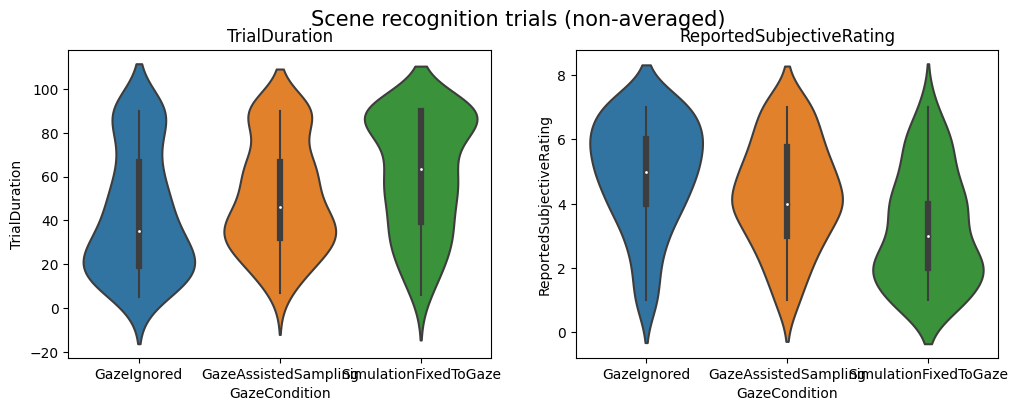

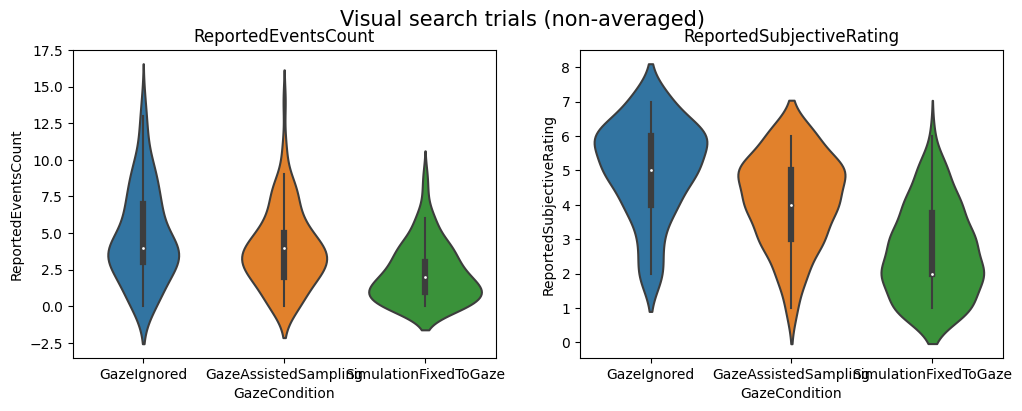

In [47]:
## Which data to show
subjects = SUBJECTS # or specify list of subjects of interest

## Load the eye tracking data
data = EXP_DATA['TrialConfigRecord'].copy()
data = data.loc[data.Block>0] # Exclude practice block
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects
data = data.astype({'ReportedSubjectiveRating':float, 'ReportedEventsCount':float})


# Scene recognition
SR_mask = data.ExperimentalTask == 'SceneRecognition'
fig, axs = violin_plots(data.loc[SR_mask], ['TrialDuration','ReportedSubjectiveRating'])
fig.suptitle('Scene recognition trials (non-averaged)', fontsize=15)

# Visual search
VS_mask = data.ExperimentalTask == 'VisualSearch'
fig, axs = violin_plots(data.loc[VS_mask], ['ReportedEventsCount', 'ReportedSubjectiveRating'])
fig.suptitle('Visual search trials (non-averaged)', fontsize=15)

# fig.tight_layout()
# plt.show()

In [48]:
data.EnvironmentName.unique()

array(['Playground', 'bedroom_4', 'bathroom_2', 'living_2', 'bedroom_1',
       'bathroom_1', 'kitchen_3', 'living_1', 'bathroom_3', 'living_4',
       'living_3', 'bedroom_2', 'kitchen_2'], dtype=object)

#### Scene Recognition analysis

In [49]:
data['SeenBeforeCount'] = data.groupby(['Subject', 'EnvironmentName']).cumcount()
data['CorrectResponse'] = (data.EnvironmentClass == data.ReportedRoomCategory).astype(float)


reindexed = data.loc[SR_mask].set_index(['Subject','EnvironmentName'])
first_sight = reindexed.loc[reindexed['SeenBeforeCount'] == 0].copy()
second_sight = reindexed.loc[reindexed['SeenBeforeCount'] == 1].copy() #pun not intended
before = first_sight.loc[second_sight.index]


second_sight['GazeConditionBefore'] = before.GazeCondition
second_sight['SameConditionBefore'] = before.GazeCondition == second_sight.GazeCondition
second_sight['CorrectBefore'] = before.CorrectResponse

second_sight['CorrectImprovement'] = before.CorrectResponse



# fig, axs = bar_plots(reindexed, ['CorrectResponse', 'TrialDuration'])
# fig.suptitle('Overall response')

# fig, axs = bar_plots(first_sight, ['CorrectResponse', 'TrialDuration'])
# fig.suptitle('At first observation')

# fig, axs = bar_plots(second_sight, ['CorrectResponse', 'TrialDuration'])
# fig.suptitle('At second observation')

# fig, axs = bar_plots(second_sight, ['CorrectResponse', 'TrialDuration'], x='GazeConditionBefore')
# fig.suptitle('At second observation')


# # fig, _ = bar_plots(second_sight, ['CorrectBefore', 'CorrectResponse', 'TrialDuration'], hue='GazeCondition', x='SameConditionBefore')
# fig.suptitle('Second observation (grouped)')

# fig, _ = bar_plots(second_sight, ['CorrectBefore', 'CorrectResponse', 'TrialDuration'], hue='GazeConditionBefore')
# fig.suptitle('Second observation (grouped)')



In [66]:
# data.loc[(data.ExperimentalTask == 'SceneRecognition')].groupby(['Subject']).count()
# data.loc[(data.ExperimentalTask == 'SceneRecognition') & (data.Subject=='S56') ]


fn = 'Out/Behavioural/SceneRecognitionData.tsv'
out_data = data.loc[(data.ExperimentalTask == 'SceneRecognition')]

out_keys = ['TrialIdentifier', 'Subject', 'Block', 'RelativeTrialNumber',
            'ExperimentalTask', 'GazeCondition', 'EnvironmentName',
            'EnvironmentClass', 'Glasses', 'GazeRaySensitivity',
            'ReportedRoomCategory', 'ReportedSubjectiveRating',
            'TrialDuration', 'SeenBeforeCount', 'CorrectResponse']
out_data = out_data[out_keys]
out_data.to_csv(fn, sep = '\t', index=False)

['TrialIdentifier',
 'Subject',
 'Block',
 'RelativeTrialNumber',
 'ExperimentalTask',
 'GazeCondition',
 'EnvironmentName',
 'EnvironmentClass',
 'Glasses',
 'GazeRaySensitivity',
 'ReportedRoomCategory',
 'ReportedSubjectiveRating',
 'TrialDuration',
 'SeenBeforeCount',
 'CorrectResponse']

#### Averaged for each subject / environment




All scene recognition trials


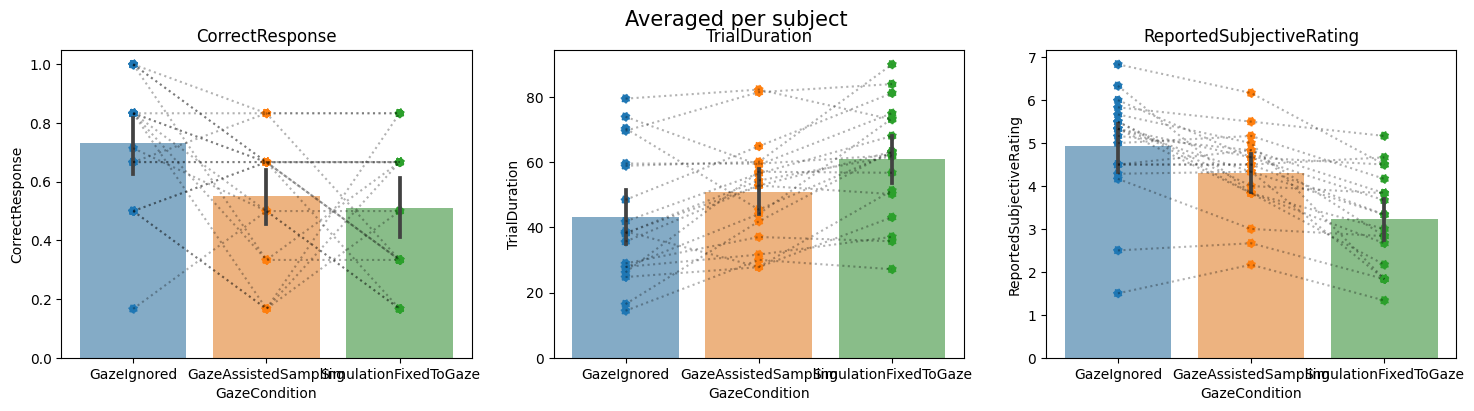

/scratch/jaap/anaconda3/envs/SPVGaze/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


ReportedSubjectiveRating  \
GazeIgnoredXGazeAssistedSampling                            0.006954   
GazeAssistedSamplingXSimulationFixedToGaze                  0.000027   
GazeIgnoredXSimulationFixedToGaze                           0.000011   

                                            TrialDuration  CorrectResponse  
GazeIgnoredXGazeAssistedSampling                 0.015972         0.011520  
GazeAssistedSamplingXSimulationFixedToGaze       0.002399         0.686430  
GazeIgnoredXSimulationFixedToGaze                0.000095         0.006789




Scene recognition trials where scene is observed for the first time


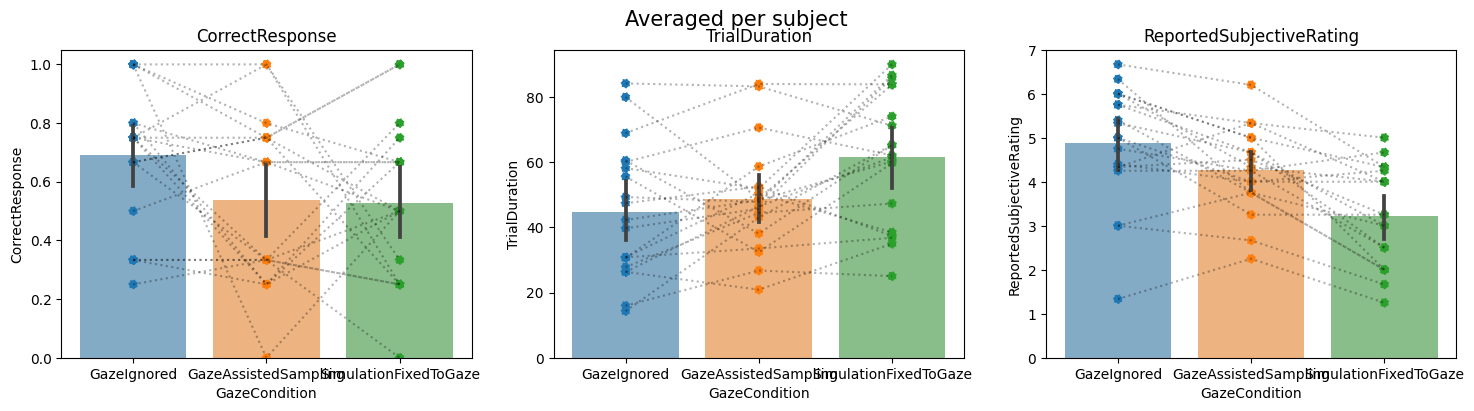

/scratch/jaap/anaconda3/envs/SPVGaze/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


ReportedSubjectiveRating  \
GazeIgnoredXGazeAssistedSampling                            0.014618   
GazeAssistedSamplingXSimulationFixedToGaze                  0.000706   
GazeIgnoredXSimulationFixedToGaze                           0.000027   

                                            TrialDuration  CorrectResponse  
GazeIgnoredXGazeAssistedSampling                 0.257927         0.053186  
GazeAssistedSamplingXSimulationFixedToGaze       0.012360         0.924414  
GazeIgnoredXSimulationFixedToGaze                0.001171         0.043848




Scene recognition trials where scene is observed once before


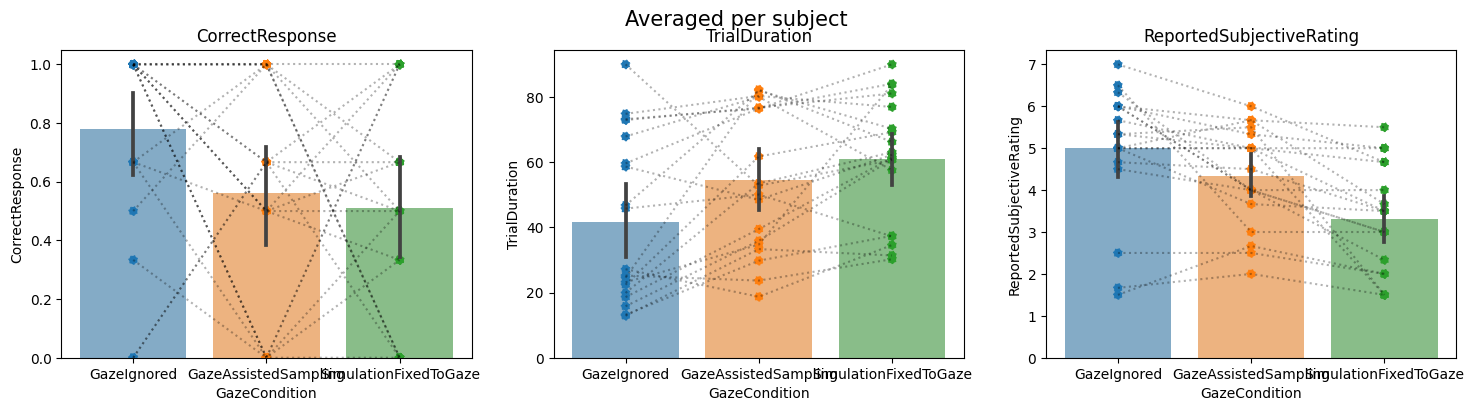

/scratch/jaap/anaconda3/envs/SPVGaze/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


ReportedSubjectiveRating  \
GazeIgnoredXGazeAssistedSampling                            0.027793   
GazeAssistedSamplingXSimulationFixedToGaze                  0.000432   
GazeIgnoredXSimulationFixedToGaze                           0.000038   

                                            TrialDuration  CorrectResponse  
GazeIgnoredXGazeAssistedSampling                 0.008232         0.130580  
GazeAssistedSamplingXSimulationFixedToGaze       0.123188         0.689397  
GazeIgnoredXSimulationFixedToGaze                0.003342         0.070728

In [12]:
# GROUP = 'EnvironmentName'
GROUP = 'Subject'
endpoints = ['ReportedSubjectiveRating', 'TrialDuration', 'CorrectResponse']

def average(data, y, group='Subject', x='GazeCondition', apply_function=None):
    """Averages the endpoint variables <y> (list of column names) absover the grouping variable <group>."""
    avg = data.loc[:, [group,]+[x,] + y]
    if apply_function is None or apply_function=='mean':
        avg = avg.groupby([group, x]).mean()
    elif apply_function=='std':
        avg = avg.groupby([group, x]).std()
    else:
        avg = avg.groupby([group, x]).agg(apply_function)
    return avg.reset_index()

## Datasets
datasets = {'All scene recognition trials': data.loc[SR_mask],
            'Scene recognition trials where scene is observed for the first time': first_sight.reset_index(),
            'Scene recognition trials where scene is observed once before': second_sight.reset_index(),}


for descr, dataset in datasets.items():
    print('\n\n\n'+ descr)
    # Averaged for each subject
    avg = average(dataset, y=endpoints, group=GROUP)
    fig, axs = bar_plots(avg, ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating'], alpha=0.6)
    _, _ = swarm_plots(avg, ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating'], group=GROUP,axs=axs, jitter=0)
    fig.suptitle("Averaged per subject", fontsize=15)
    plt.show()
    display(paired_wilcoxon(avg, group=GROUP))

Text(0.5, 0.98, 'Visual search performance over time')

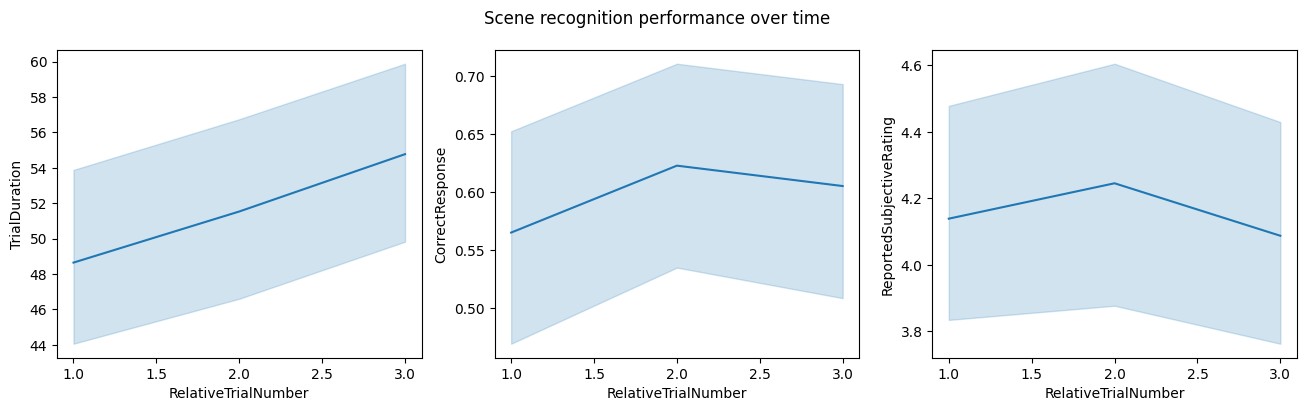

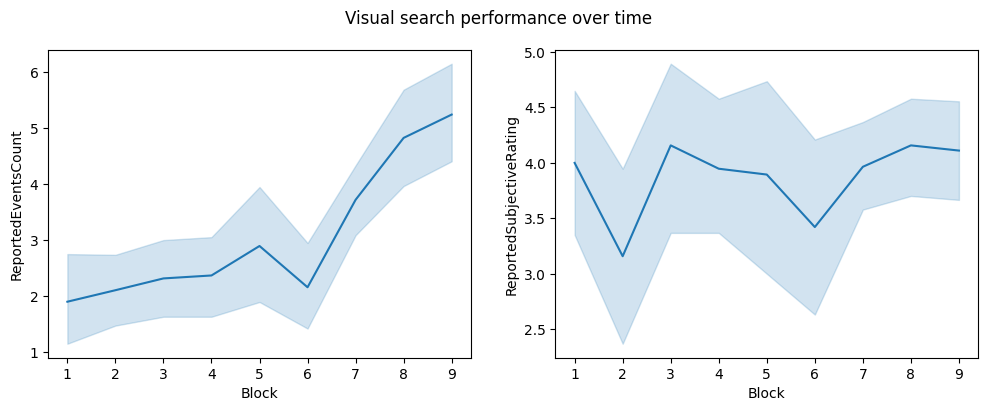

In [36]:
fig, axs = plt.subplots(1,3,figsize=(16,4))
sns.lineplot(data=data.loc[SR_mask], x='RelativeTrialNumber', y='TrialDuration', ax=axs[0])
sns.lineplot(data=data.loc[SR_mask], x='RelativeTrialNumber', y='CorrectResponse', ax=axs[1])
sns.lineplot(data=data.loc[SR_mask], x='RelativeTrialNumber', y='ReportedSubjectiveRating', ax=axs[2])
fig.suptitle("Scene recognition performance over time")

fig, axs = plt.subplots(1,2,figsize=(12,4))
sns.lineplot(data=data.loc[VS_mask], x='Block', y='ReportedEventsCount', ax=axs[0])
sns.lineplot(data=data.loc[VS_mask], x='Block', y='ReportedSubjectiveRating', ax=axs[1])
fig.suptitle("Visual search performance over time")

In [343]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.contrast import ContrastResults

def get_contrast_matrix(model_params):
    
    # Create contrast matrix between the gaze conditions
    contrast_matrix = np.zeros((3,len(model_params)))
    contrast_matrix[0,:3] = [1, -1, 0]
    contrast_matrix[1,:3] = [0, 1,-1]
    contrast_matrix[2,:3] = [1, 0, -1]
    
    # Create a description of the contrasts 
    description = ['{}<>{}'.format(model_params.index[0], model_params.index[1]), 
                   '{}<>{}'.format(model_params.index[1], model_params.index[2]), 
                   '{}<>{}'.format(model_params.index[0], model_params.index[2]),] 
    description = [s.replace('GazeCondition[', '').replace(']', '') for s in description] # remove redundant text
    return description, contrast_matrix

def adjust_bonferroni_holm(contrasts):
    N = contrasts.pvalue.shape[0]
    c = np.arange(1, N+1, 1)
    i = np.argsort(contrasts.pvalue)[::-1]
    return np.clip(contrasts.pvalue * c[i], 0, 1)

X = data.loc[SR_mask]

## Fit mixed linear model
mixed_lm = smf.mixedlm("TrialDuration ~ 0 + GazeCondition + Block + EnvironmentName",
                 data.loc[SR_mask],
                 groups="Subject",
#                  vc_formula={"EnvironmentName": "0 + C(EnvironmentName)"},
                 re_formula="~ 1").fit()
print(mixed_lm.summary())



## Perform t-test
description, contrast_matrix = get_contrast_matrix(model_params=mixed_lm.fe_params)
results = mixed_lm.t_test(contrast_matrix, use_t=True)
results.pvalue = adjust_bonferroni_holm(results)
results = results.summary_frame()
results['description'] = description

results

# print()
# print(mixed_lm.fe_params.index[:3])



# contrasts = mdf.t_test(np.array([[1,-1,0,0,0,0], [0,1,-1,0,0,0], [1,0,-1,0,0,0]]), use_t=True)
# contrasts.pvalue = adjust_bonferroni_holm(contrasts)


# print("ICC: ", get_icc(mdf))
# # sm.qqplot(mdf.resid)
# contrasts = mdf.t_test(np.array([[1,-1,0,0,0,0], [0,1,-1,0,0,0], [1,0,-1,0,0,0]]), use_t=True)
# contrasts.pvalue = adjust_bonferroni_holm(contrasts)
# print(contrasts.summary(xname=['Ass|Ign', 'Ign|Lck', 'Ass|Lck']))


                     Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       TrialDuration
No. Observations:         305           Method:                   REML         
No. Groups:               17            Scale:                    453.1264     
Min. group size:          17            Log-Likelihood:           -1343.4073   
Max. group size:          18            Converged:                Yes          
Mean group size:          17.9                                                 
-------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
GazeCondition[GazeAssistedSampling]   37.573    6.670 5.633 0.000 24.500 50.646
GazeCondition[GazeIgnored]            29.908    6.581 4.545 0.000 17.010 42.805
GazeCondition[SimulationFixedToGaze]  47.840    6.770 7.067 0

coef   std err         t         P>|t|  Conf. Int. Low  \
c0   7.665389  3.047540  2.515271  1.243474e-02        1.667288   
c1 -17.932327  3.021447 -5.935013  2.510908e-08      -23.879072   
c2 -10.266937  3.022723 -3.396586  1.555327e-03      -16.216194   

    Conf. Int. Upp.                                  description  
c0        13.663490            GazeAssistedSampling<>GazeIgnored  
c1       -11.985582           GazeIgnored<>SimulationFixedToGaze  
c2        -4.317681  GazeAssistedSampling<>SimulationFixedToGaze

In [344]:
import sklearn
from sklearn.metrics import confusion_matrix

In [3]:
labels = ['Living', 'Bathroom', 'Kitchen', 'Bedroom']
conf = confusion_matrix(reindexed.EnvironmentClass,reindexed.ReportedRoomCategory, labels= labels)
total = conf.sum(axis=1)[:,np.newaxis].repeat(4, axis=1)
sns.heatmap(conf/total, annot=True, xticklabels=labels, yticklabels=labels, cmap='hot')

NameError: name 'confusion_matrix' is not defined

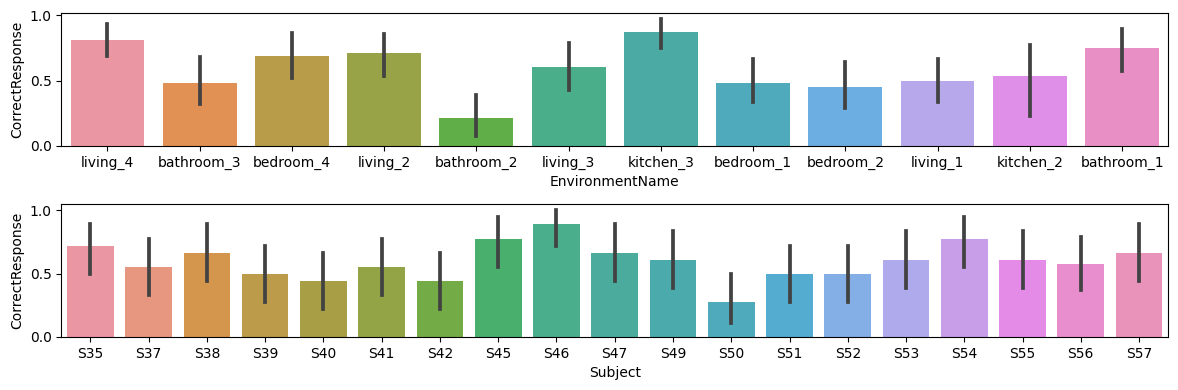

In [14]:
fig, axs = plt.subplots(2,1, figsize=(12,4), dpi=100)
sns.barplot(data=data.loc[SR_mask], x='EnvironmentName', y='CorrectResponse',ax= axs[0])
sns.barplot(data=data.loc[SR_mask].sort_values('Subject'), x='Subject', y='CorrectResponse',ax= axs[1])
plt.tight_layout()

## Engine data endpoints

##### Plotting functions

In [347]:
def violin_plots(data, endpoints):
    n_figs = len(endpoints)
    fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
    for i, y in enumerate(endpoints):
        sns.violinplot(data=data, x='GazeCondition', y=y, ax= axs[i])
        axs[i].set(title=y)
    return fig, axs

def bar_plots(data, endpoints, x='GazeCondition', **kwargs):
    n_figs = len(endpoints)
    fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
    for i, y in enumerate(endpoints):
        sns.barplot(data=data, x=x, y=y, ax= axs[i], **kwargs)
        axs[i].set(title=y)
    return fig, axs

##### Verify target hit

In [348]:
#### NOTE TO SELF: in some cases the visual search target appeared to have changed without updating the ReportedEventsCount! why?

In [28]:


# def plot_quiver_map(data, axs=None, color=None, fig=None):
#     if axs is None:
#         fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=200,)
    
#     if color is None:
#         color = TARGETS.loc[data.ActiveTarget, 'Color'].to_list()
        
#         # Put targets in legend
#         targets = TARGETS.loc[data.ActiveTarget.unique(), 'Color'] # All targets that were observed in current data
#         print(targets)
#         handles = [Patch(facecolor=color[:3]+[1.0,], label=trg) for trg, color in targets.items()]
#         axs[0].legend(handles=handles)

    
#     # Head quiver (first axis)
#     x, y = data['XRHeadPosX'], data['XRHeadPosZ']
#     u, v = data['XRHeadDirX'], data['XRHeadDirZ']
#     axs[0].quiver(x,y,u,v, color=color, scale=15)
#     # axs[0].axis('square')
#     axs[0].set(title= 'Head')
    
#     # Hand Quiver
#     x, y = data['HandRPosX'], data['HandRPosZ']
#     u, v = data['HandRDirX'], data['HandRDirZ']
#     axs[1].quiver(x,y,u,v, color=color, scale=10)
#     # axs[1].axis('square')
#     axs[1].set(title= 'Right Hand')


#     return fig, axs

def plot_joint_plots(data, pairs, order=HUE_ORDER):
    
    # Create figure and Gridspec
    N = len(pairs)
    fig = plt.figure(figsize=(5*N, 4), dpi=200)
    gs = fig.add_gridspec(2, 3*N,  width_ratios=(4, 1, 1)*N, height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    handles = []

    # Enumerate pairs and create each jointplot 
    for i, (x,y) in enumerate(pairs):
        
        # The scatterplot
        ax0 = fig.add_subplot(gs[1, 0 + 3*i])
        ax0.spines[['right', 'top']].set_visible(False)
#         sns.scatterplot(data=data, x=x, y=y, hue='GazeCondition',ax=ax0, legend=False, alpha=0.3)
    
        for condition in order: # ['GazeIgnored', 'GazeAssistedSampling', 'SimulationFixedToGaze']
            h = sns.regplot(data=data.loc[data.GazeCondition==condition],x=x,y=y, scatter_kws={'alpha':0.25})
            handles.append(h)

        # The distribution plots
        ax1 = fig.add_subplot(gs[0, 0 + 3*i], sharex=ax0)
        ax2 = fig.add_subplot(gs[1, 1 + 3*i], sharey=ax0)
        ax1.spines[['right', 'top', 'left']].set_visible(False)
        ax2.spines[['bottom', 'top', 'right']].set_visible(False)
        plt.setp(ax1.get_xticklabels() + ax2.get_yticklabels() + \
                [ax1.yaxis,  ax2.xaxis], visible=False)
        h1 = sns.kdeplot(data=data, x=x, hue='GazeCondition',ax=ax1, legend=False, fill=True)
        h2 = sns.kdeplot(data=data, y=y, hue='GazeCondition',ax=ax2, legend=False, fill=True)
        handles += [h1,h2,]
    return handles

def plot_targets(targets, ax):
    colors = get_colors(labels=targets.index, alpha=1.)
    color = pd.Series(colors).loc[targets.index].to_list()
    hdl = ax.scatter(targets.PosX, targets.PosZ, c = color)
    return

def get_colors(labels, cmap='viridis', alpha=0.25):
    colormap = matplotlib.colormaps.get_cmap(cmap)
    colors = colormap(np.linspace(0,1,len(labels)))
    colors[:,-1]=alpha
    return {lbl: colors[i].tolist() for i, lbl in enumerate(labels)}

def get_target_locations(filename ='_TargetLocations.tsv', sep='\t'):
    fn = os.path.join(DATA_DIR,filename)
    targets = pd.read_csv(fn, sep=sep).set_index('TargetName')
    return targets

def angle_between(a, b):
    """Calculate the shortest angle between two complex numbers (represented as vectors on the complex plane)
    return value in degrees"""
    theta = np.angle(a) - np.angle(b)
    theta *= 180/np.pi  #convert to degrees
    theta = (theta + 180) % 360 - 180 # find the shortest angle (e.g. -270 -> 90 deg.)
    return theta

def get_localization_errors(data, targets, columns=None):

    # Get event frames (out)
    event_occurred = data.groupby('TrialIdentifier').ReportedEventsCount.diff() > 0
    out = data.loc[event_occurred].copy()
    
    
    # Some data (e.g. search duration) are found in the final frame before the event
    final_frames = data.shift().loc[event_occurred]
    copy_from_final = ['ReportedEventsCount', 'SearchDuration']
    out[copy_from_final] = final_frames[copy_from_final]
    
    # Positions of the sensors (head and hand)
    out['HeadPosXZ'] = (out.XRHeadPosX + out.XRHeadPosZ*1j).values
    out['HandPosXZ'] = (out.HandRPosX + out.HandRPosZ*1j).values
    out['OrgPosXZ'] = (out.XROriginPosX + out.XROriginPosZ * 1j).values

    # Position of the targets
    out['TrgPosXZ'] = (targets.loc[out['ActiveTarget']].PosX + \
                       targets.loc[out['ActiveTarget']].PosZ * 1j).values

    # Pointing locations
    out['HandPntXZ'] = (out.PointLocationHandX + out.PointLocationHandZ*1j).values
    out['HeadPntXZ'] = (out.PointLocationHeadX + out.PointLocationHeadZ*1j).values
    out['EyePntXZ'] = (out.PointLocationEyeX + out.PointLocationEyeZ*1j).values
    
    # Raycasts from hand
    out['Hand2HandPnt'] = out.HandPntXZ - out.HandPosXZ # Raycast hit location (hand) w.r.t. hand pos
    out['Head2HandPnt'] = out.HandPntXZ - out.HeadPosXZ # Raycast hit location (hand) w.r.t. head pos
    
    # Raycasts from head and eyes
    out['Head2HeadPnt'] = out.HeadPntXZ - out.HeadPosXZ # Raycast hit location (head) w.r.t. head pos
    out['Head2EyePnt'] =  out.EyePntXZ - out.HeadPosXZ # Raycast hit location (eyes) w.r.t. head pos
    
    # Target positions
    out['Hand2Targ'] = out.TrgPosXZ - out.HandPosXZ # Target location w.r.t. hand pos
    out['Head2Targ'] = out.TrgPosXZ - out.HeadPosXZ # Target location w.r.t. head pos

    # Localization errors (angles with respect to vector from head to target)
    out['LocalizationErrorHand'] = angle_between(out.Head2HandPnt, out.Head2Targ)
    out['LocalizationErrorHead'] = angle_between(out.Head2HeadPnt, out.Head2Targ)
    out['LocalizationErrorEyes'] = angle_between(out.Head2EyePnt, out.Head2Targ)
    
    # Relative errors (mismatch)
    out['HeadHandMismatch'] = (out['LocalizationErrorHead'] - out['LocalizationErrorHand']  + 180) % 360 - 180
    out['EyeHandMismatch'] = (out['LocalizationErrorEyes'] - out['LocalizationErrorHand']  + 180) % 360 - 180
    out['HeadEyeMismatch'] = (out['LocalizationErrorHead'] - out['LocalizationErrorEyes']  + 180) % 360 - 180
    
    if columns is None:
        columns = ['ActiveTarget','Subject', 'Block', 'RelativeTrialNumber', 
                   'ExperimentalTask', 'GazeCondition','TotalReportedEvents',
                   'HeadPosXZ', 'HandPosXZ', 'OrgPosXZ', 'TrgPosXZ', 'HandPntXZ',
                   'HeadPntXZ', 'EyePntXZ',  'Hand2HandPnt', 'Head2HandPnt',
                   'Head2HeadPnt', 'Head2EyePnt', 'Hand2Targ', 'Head2Targ', 
                   'SearchDuration', 'LocalizationErrorHand',
                   'LocalizationErrorHead','LocalizationErrorEyes',
                   'HeadHandMismatch', 'EyeHandMismatch', 'HeadEyeMismatch']
    
    
    return out.set_index(['TrialIdentifier','ReportedEventsCount'])[columns]


# Load all targets
TARGETS = get_target_locations()
TARGETS['Color'] = get_colors(TARGETS.index).values()



In [16]:
# event_frames.columns['ActiveTarget','Subject', 'Block', 'RelativeTrialNumber', 
#                      'ExperimentalTask', 'GazeCondition','TotalReportedEvents',
#                      , 'HeadPosXZ', 'HandPosXZ', 'OrgPosXZ', 'TrgPosXZ', 'HandPntXZ',
#                      'HeadPntXZ', 'EyePntXZ', 'SearchDuration', 'LocalizationErrorHand',
#                      'LocalizationErrorHead','LocalizationErrorEyes']

In [17]:
## Which data to show
subjects = SUBJECTS # or specify list of subjects of interest

# TARGET_IDX = {trg:i for i, trg in enumerate(sorted(data.ActiveTarget.unique().tolist()))}

MAX_TIME = 200 # seconds. Search times that are higher are discarded
MIN_TIME = 1.2 # seconds. Search times that are lower are discarded
MAX_ANGLE = 10 # degrees (Error between hand pointing angle and actual target angle)


## Load the eye tracking data
data = EXP_DATA['EngineDataRecord'].copy()
data = data.loc[data.ExperimentalTask == 'VisualSearch'] # Only visual searhc
data = data.loc[data.Block>7] # Exclude practice block
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects

# Useful grouping indices
trial_index= ['TrialIdentifier',]
targ_index = ['TrialIdentifier','ReportedEventsCount'] # To group by visual search instance (within a trial)
time_index = ['TrialIdentifier', 'TimeStamp'] # To index by timestamp (unique frame identifier)

# Total reported objects
total_reported = data.groupby(trial_index).ReportedEventsCount.max()
data['TotalReportedEvents'] = total_reported.loc[data.TrialIdentifier].values
data['ReportedAsFound'] = data.ReportedEventsCount < data.TotalReportedEvents

# Find and calculate the time between 'event triggers' reported by subject
start_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
event_occurred = data.groupby(trial_index).ReportedEventsCount.diff() > 0 # True for frames where event count increases (trigger was pressed)
start_of_search = data.where(start_trial | event_occurred).TimeStamp.ffill()  # Timestamps for the start of search 
start_of_search.loc[data.ReportedEventsCount > 0] += 1e7 # Next visual search instances starts 1 second after the previous one ended
data['SearchDuration'] = (data.TimeStamp - start_of_search) * 1e-7


event_frames = get_localization_errors(data, targets=TARGETS)

# # Extract each very last frame before the trigger was pressed.
# final_frame_timestamp = data.groupby(targ_index).TimeStamp.max()
# final_frame_mask = final_frame_timestamp.reset_index().set_index(time_index).index
# final_frames = data.set_index(time_index).loc[final_frame_mask].reset_index().set_index(targ_index)



# # Group by visual search instance, and calculate the maximum value
# trg_group_idx = ['TrialIdentifier','ReportedEventsCount', 'Subject', 'GazeCondition', 'ActiveTarget']
# grouped_by_target = data.groupby(trg_group_idx)
# search_times = grouped_by_target.SecondsSinceEvent.max().reset_index(trg_group_idx)
# search_times = search_times.loc[(search_times.SecondsSinceEvent<MAX_TIME) &
#                                 (search_times.SecondsSinceEvent>MIN_TIME)]

# trial_group_idx = ['TrialIdentifier', 'GazeCondition']
# grouped_by_trial = data.groupby(trial_group_idx)
# n_targets = grouped_by_target.ReportedEventsCount.max().reset_index(trial_group_idx)

In [18]:

# event_frames.groupby(['Subject', 'GazeCondition'])['LocalizationErrorHead', 'LocalizationErrorEyes', 'LocalizationErrorHead'].apply()

<Axes: xlabel='GazeCondition', ylabel='LocalizationErrorEyes'>

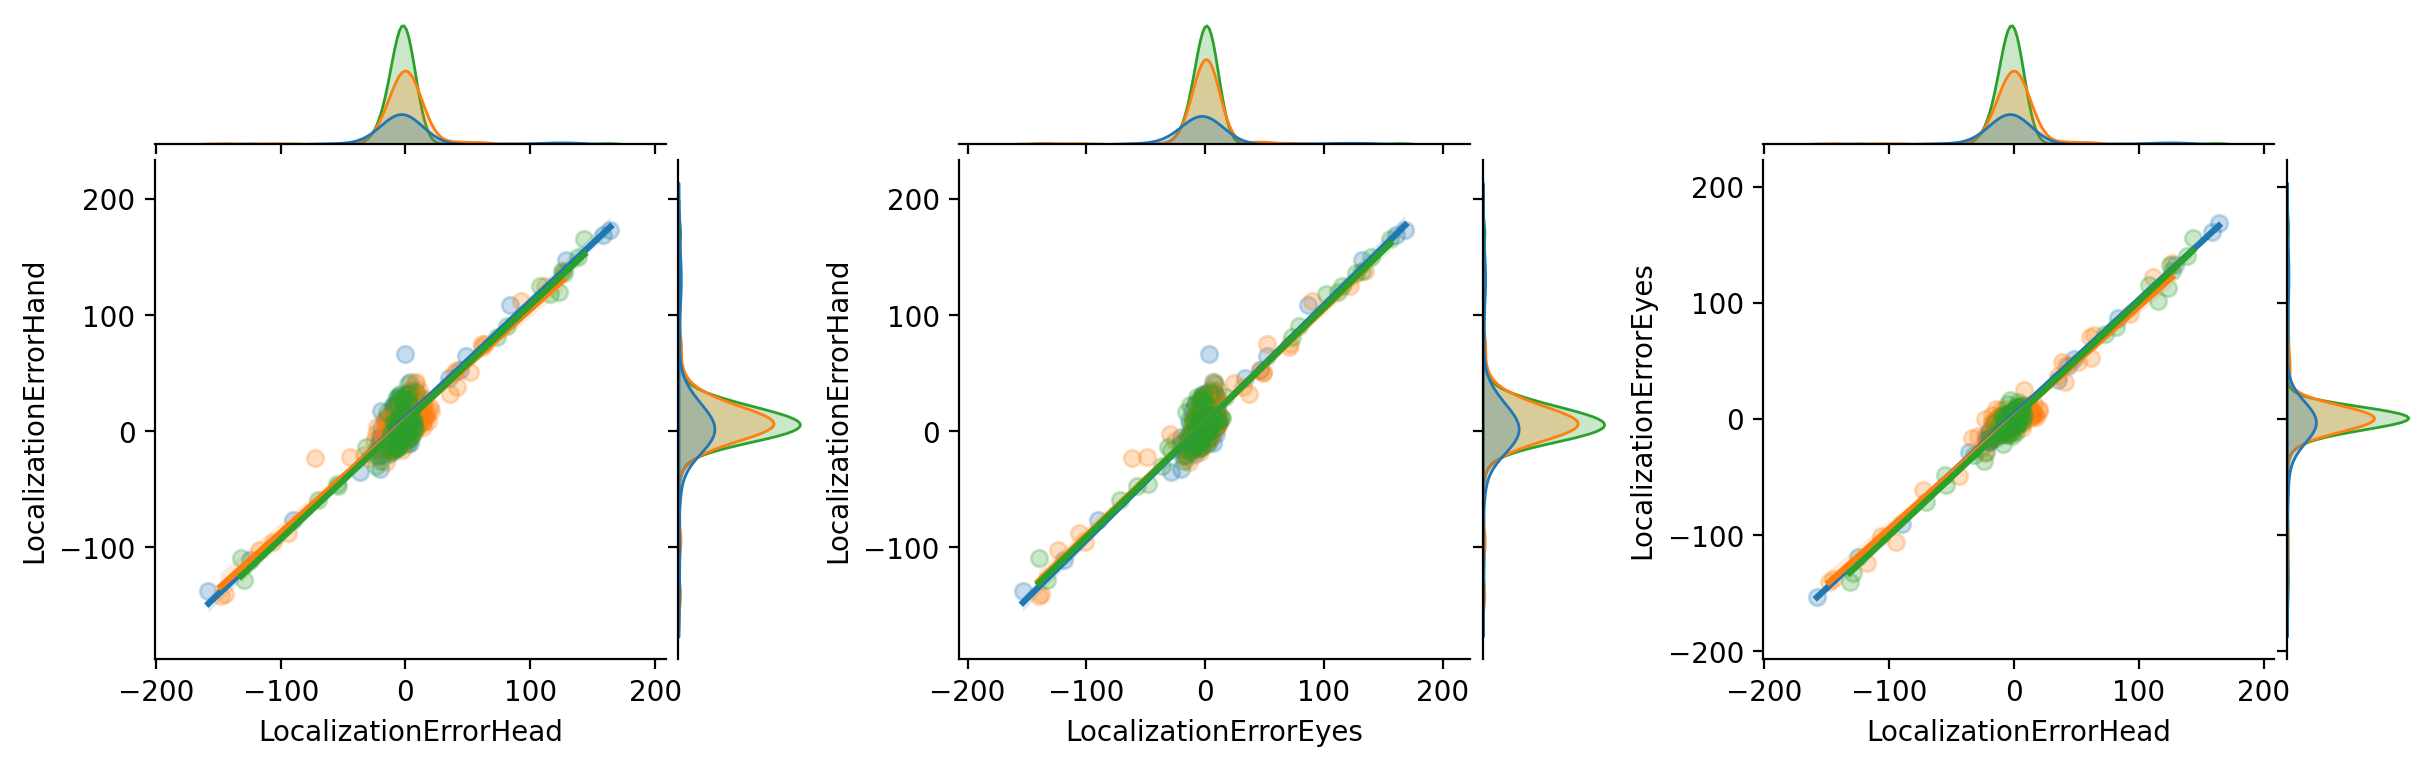

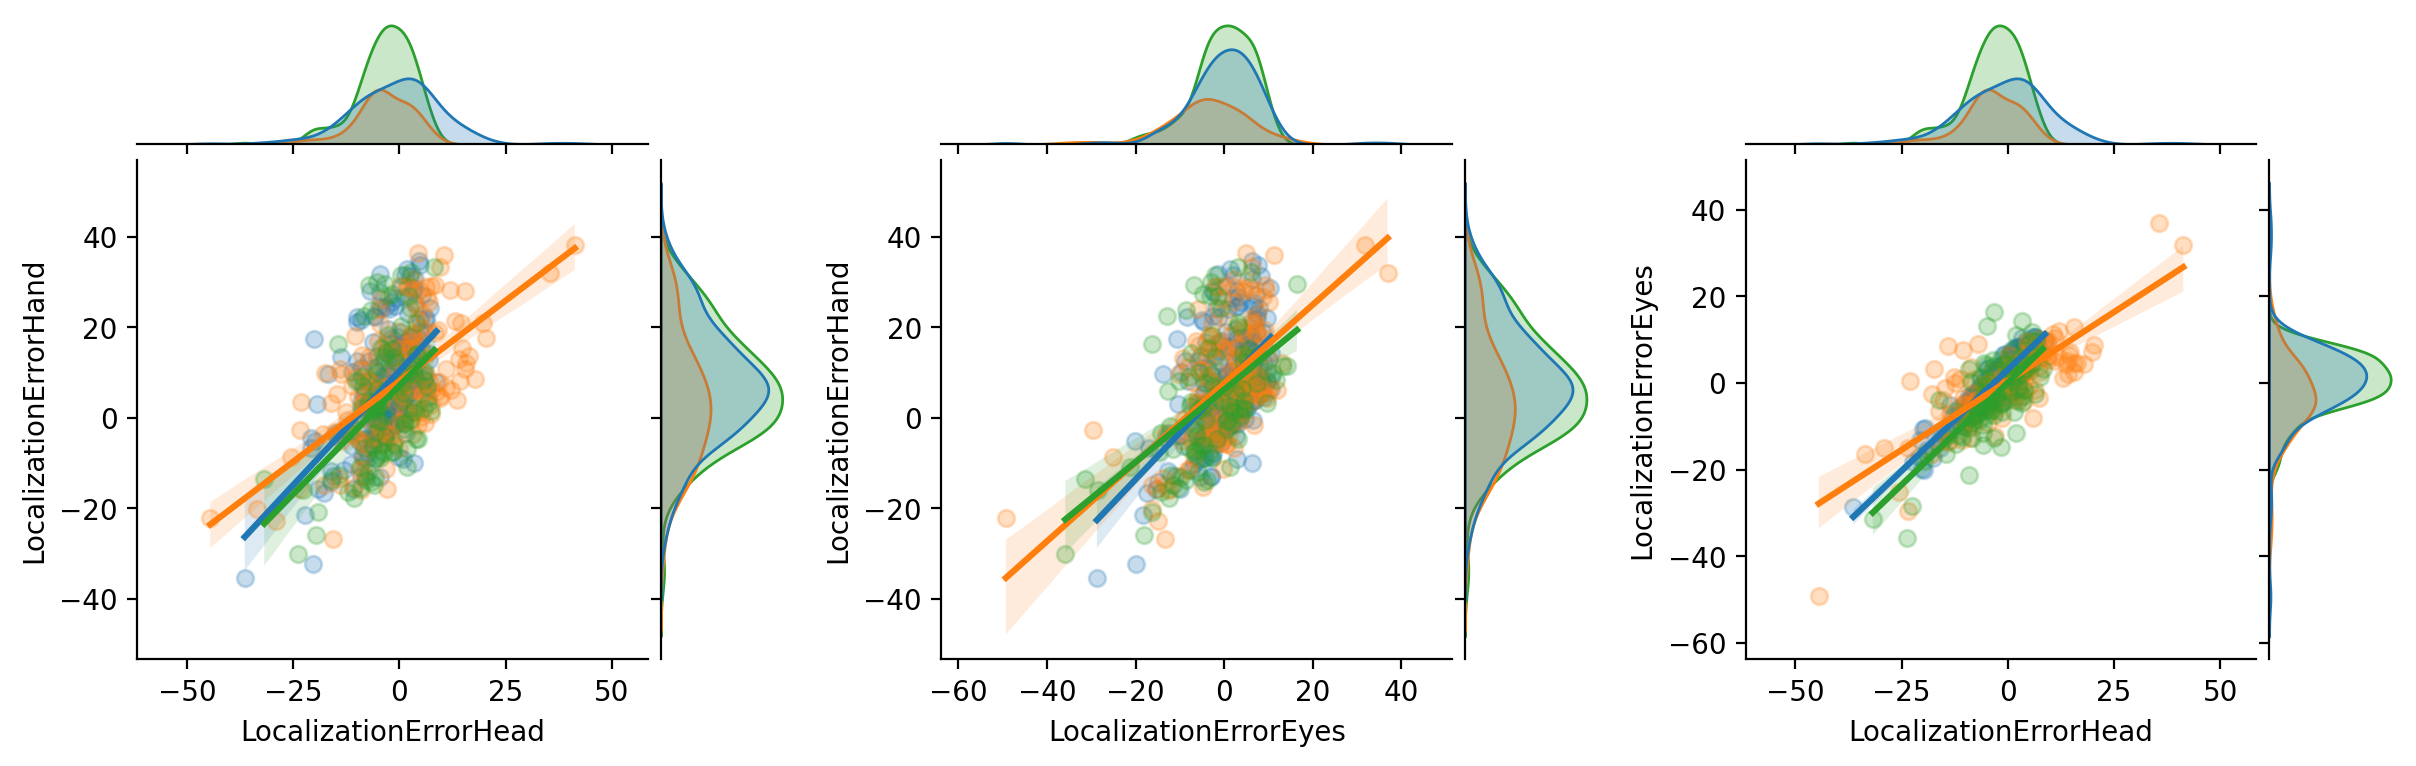

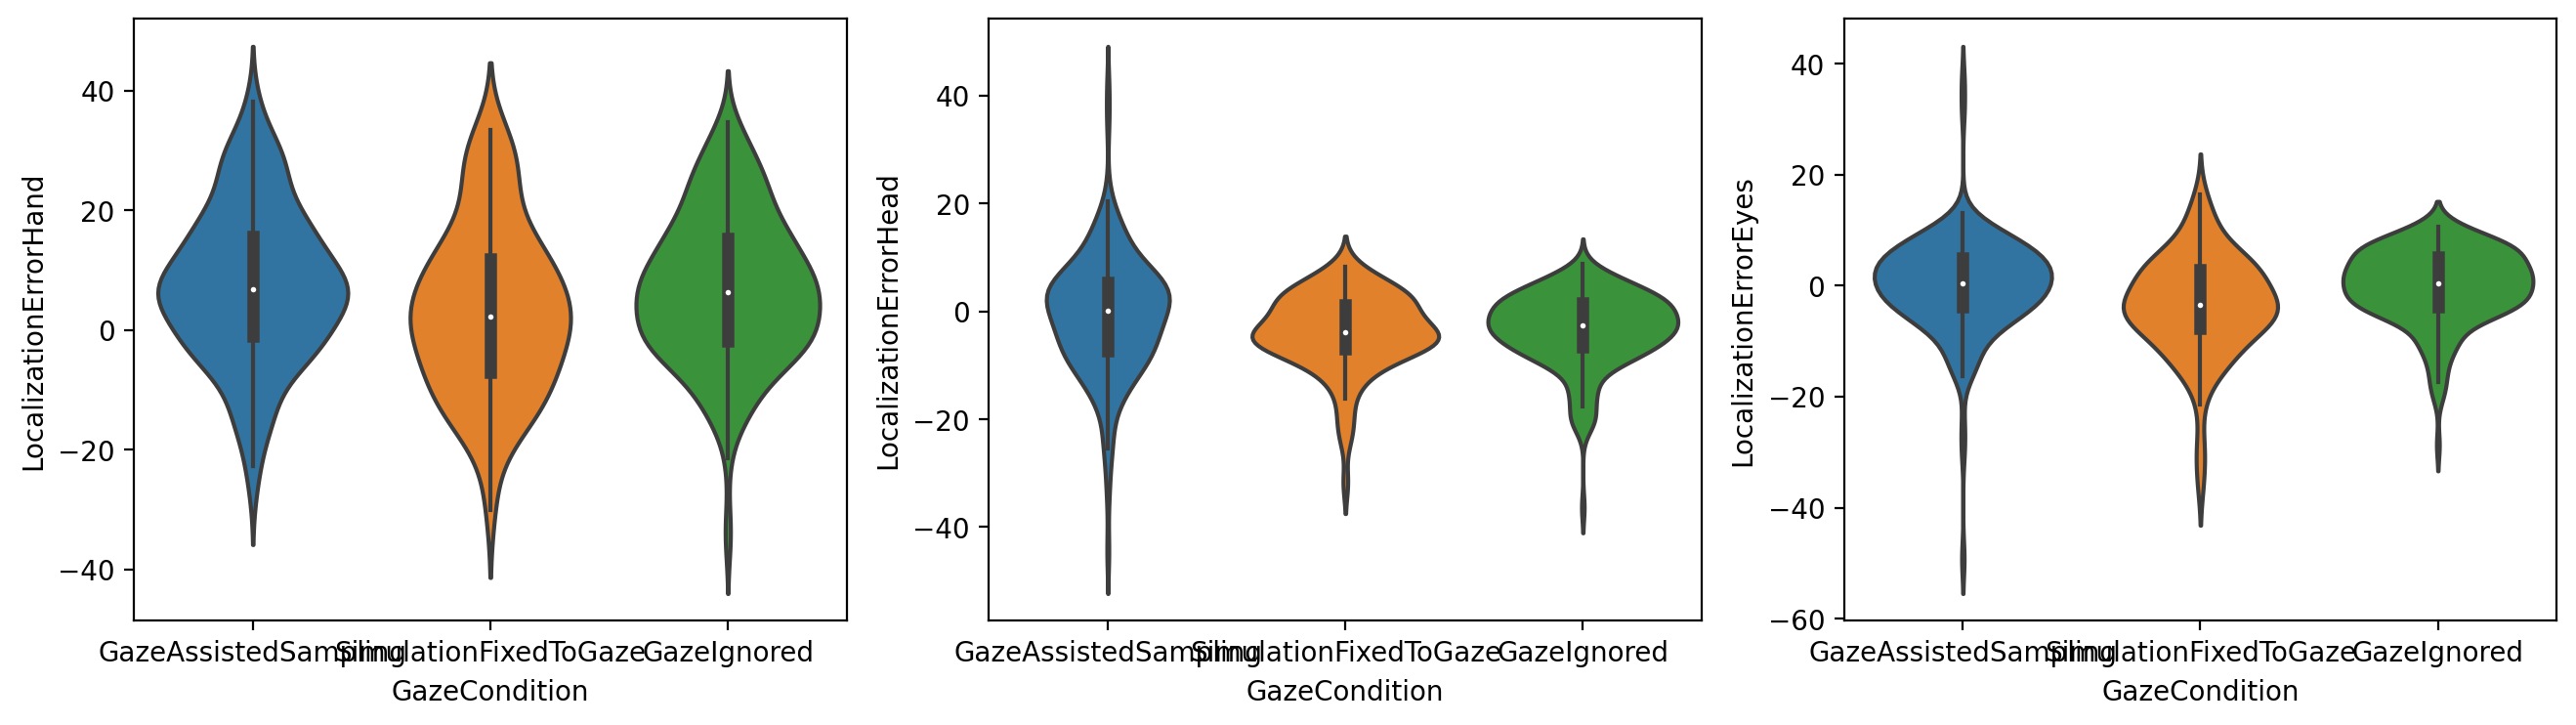

In [60]:
# fig, axs = plt.subplots(1,3, figsize=(16,4), dpi=200)
# sns.histplot(data=event_frames, x='LocalizationErrorHand', hue='GazeCondition', ax=axs[0], alpha=0.3)
# sns.histplot(data=event_frames, x='LocalizationErrorHead', hue='GazeCondition', ax=axs[1], alpha=0.3)
# sns.histplot(data=event_frames, x='LocalizationErrorEyes', hue='GazeCondition', ax=axs[2], alpha=0.3)

# fig, axs = plt.subplots(1,2, figsize=(12,4), dpi=200)
# sns.histplot(data=event_frames, x='HeadHandMismatch', hue='GazeCondition', ax=axs[0], alpha=0.3)
# sns.histplot(data=event_frames, x='EyeHandMismatch', hue='GazeCondition', ax=axs[1], alpha=0.3)


# Raycasts from hand
# x_axis = np.ones_like(event_frames.HandPntXZ)
# hand_ray = np.angle(event_frames.HandPntXZ - event_frames.HeadPosXZ) # Raycast hit location (hand) w.r.t. head pos
# head_ray =  np.angle(event_frames.HeadPntXZ - event_frames.HeadPosXZ) # Raycast hit location (head) w.r.t. head pos
# lo =  np.angle(event_frames.EyePntXZ - event_frames.HeadPosXZ) # Raycast hit location (eyes) w.r.t. head pos

# vec2angle = lambda x: angle_between(x,np.ones_like(x))
# conversions = {col: vec2angle for col in ['Head2HandPnt', 'Head2HeadPnt', 'Head2EyesPnt']}


# fig, axs = plt.subplots(1,3, figsize=(16,4), dpi=200)
# sns.scatterplot(data=event_frames.apply(conversions), x='Head2HandPnt', y='Head2HeadPnt', hue='GazeCondition', ax=axs[0], alpha=0.3)
# sns.scatterplot(data=event_frames, x=pointing_dir_, y=looking_dir_, hue='GazeCondition', ax=axs[1], alpha=0.3)
# sns.scatterplot(data=event_frames, x=looking_dir_, y=looking_dir, hue='GazeCondition', ax=axs[2], alpha=0.3)
                              
# fig, axs = plt.subplots(1,3, figsize=(16,4), dpi=200)
# sns.jointplot(data=event_frames, x='LocalizationErrorHand', y='LocalizationErrorHead', hue='GazeCondition',)# ax=axs[0], alpha=0.3)
# sns.jointplot(data=event_frames, x='LocalizationErrorHand', y='LocalizationErrorEyes', hue='GazeCondition',)# ax=axs[1], alpha=0.3)
# sns.jointplot(data=event_frames, x='LocalizationErrorHead', y='LocalizationErrorEyes', hue='GazeCondition',)# ax=axs[2], alpha=0.3)

pairs = [('LocalizationErrorHead', 'LocalizationErrorHand'), 
        ('LocalizationErrorEyes', 'LocalizationErrorHand'),
        ('LocalizationErrorHead', 'LocalizationErrorEyes')]
    
handles = plot_joint_plots(event_frames, pairs)

## CLEAN DATA
invalid = [False,] * len(event_frames)

# Remove target misses (hand is pointing very different from head, or hand is pointing completely wrong direction)
MISMATCH_BOUNDARY = 40
LOCALIZATION_BOUNDARY = 40
invalid = invalid | (np.abs(event_frames.HeadHandMismatch) > MISMATCH_BOUNDARY)
invalid = invalid | (np.abs(event_frames.LocalizationErrorHand) > LOCALIZATION_BOUNDARY)

# # Remove bad-performing subjects / difficult targets 
# STD_MAXIMUM_SUBJ = 15
# STD_MAXIMUM_TARG = 15

# std_subject = event_frames.groupby('Subject')[['LocalizationErrorHand', 'LocalizationErrorHead','LocalizationErrorEyes']].std()
# std_target = event_frames.groupby('ActiveTarget')[['LocalizationErrorHand', 'LocalizationErrorHead','LocalizationErrorEyes']].std()
# invalid_subjects = std_subject.loc[std_subject.LocalizationErrorHand > 40].index
# invalid_targets = std_target.loc[std_target.LocalizationErrorHand > 40].index
# invalid = invalid | event_frames.Subject.isin(invalid_subjects)
# invalid = invalid | event_frames.ActiveTarget.isin(invalid_targets)

# Exclude subjects with insufficient performance across all conditions
MINIMAL_TARGETS = 2 # minimal number of targets in each condition
n_targets_per_cond = event_frames.groupby(['Subject','GazeCondition']).ActiveTarget.count().unstack(fill_value=0)
exclude_subject = n_targets_per_cond.loc[(n_targets_per_cond < MINIMAL_TARGETS).any(axis=1)].index
invalid = invalid | event_frames.Subject.isin(exclude_subject)





plot_joint_plots(event_frames.loc[~invalid], pairs)


fig, axs = plt.subplots(1,3, figsize=(16,4), dpi=200)
sns.violinplot(data=event_frames.loc[~invalid], y='LocalizationErrorHand', x='GazeCondition', ax=axs[0])
sns.violinplot(data=event_frames.loc[~invalid], y='LocalizationErrorHead', x='GazeCondition', ax=axs[1])
sns.violinplot(data=event_frames.loc[~invalid], y='LocalizationErrorEyes', x='GazeCondition', ax=axs[2])

TypeError: 'NoneType' object is not iterable

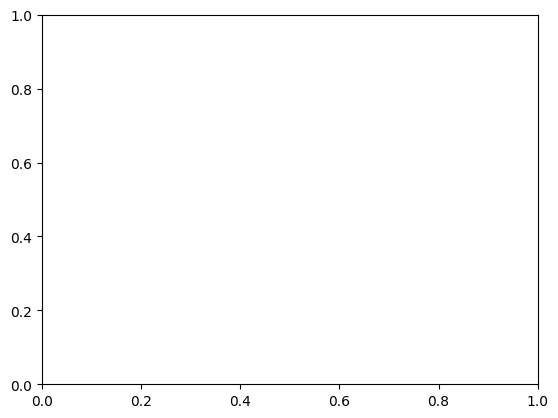

In [34]:
plt.figure()
plt.legend(handles[-1].get_legend())

In [36]:
data

TimeStamp               XROriginPos           XROriginRot  \
17846   638150000104903449  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
17847   638150000106894904  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
17848   638150000108894979  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
17849   638150000110944822  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
17850   638150000112935794  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
...                    ...                       ...                   ...   
394417  638158637811915006           (0.0, 0.0, 0.0)  (0.0, 0.0, 0.0, 1.0)   
394418  638158637813918105           (0.0, 0.0, 0.0)  (0.0, 0.0, 0.0, 1.0)   
394419  638158637816028127           (0.0, 0.0, 0.0)  (0.0, 0.0, 0.0, 1.0)   
394420  638158637817984680           (0.0, 0.0, 0.0)  (0.0, 0.0, 0.0, 1.0)   
394421  638158637819976950           (0.0, 0.0, 0.0)  (0.0, 0.0, 0.0, 1.0)   

                           XRHeadPos                              XRHeadRot  \
17846   (-0.70087, 1.67507, 0.95228)  (0.05017, -0.0006, -0.01419, 0.99864)   
17847   (-0.70281, 1.67392, 0.95231)   (0.05448, 0.00413, -0.0157, 0.99838)   
17848   (-0.70459, 1.67634, 0.94925)   (0.04512, 0.00378, -0.01853, 0.9988)   
17849    (-0.7058, 1.67495, 0.94709)   (0.05373, 0.00445, -0.0174, 0.99839)   
17850    (-0.7059, 1.67362, 0.94542)  (0.06111, 0.00326, -0.01621, 0.99799)   
...                              ...                                    ...   
394417   (0.28121, 1.40489, 0.19559)   (0.06117, 0.16216, -0.0277, 0.98448)   
394418   (0.27817, 1.40583, 0.19353)  (0.05924, 0.15642, -0.02094, 0.98569)   
394419   (0.27545, 1.40612, 0.18925)  (0.05823, 0.15455, -0.01377, 0.98617)   
394420    (0.27148, 1.40621, 0.1856)  (0.05814, 0.14113, -0.01114, 0.98822)   
394421    (0.26656, 1.40555, 0.1838)    (0.06298, 0.12666, -0.008, 0.98991)   

                            HandLPos                               HandLRot  \
17846    (-0.8724, 0.73664, 0.94589)  (0.30684, 0.29092, -0.33938, 0.84026)   
17847   (-0.87459, 0.73486, 0.94326)  (0.31136, 0.28459, -0.33347, 0.84313)   
17848    (-0.8756, 0.73404, 0.94201)  (0.31061, 0.28445, -0.33223, 0.84394)   
17849   (-0.87716, 0.73411, 0.94327)     (0.3083, 0.2818, -0.3311, 0.84612)   
17850   (-0.87727, 0.73368, 0.94498)  (0.30574, 0.28033, -0.33166, 0.84731)   
...                              ...                                    ...   
394417   (0.29639, 0.99951, 0.25678)   (0.11576, 0.59421, 0.46419, 0.64656)   
394418      (0.29591, 0.99455, 0.25)     (0.10598, 0.5671, 0.4546, 0.67861)   
394419   (0.29969, 0.99339, 0.24265)    (0.08203, 0.5686, 0.42406, 0.70009)   
394420   (0.31633, 0.99003, 0.22871)   (0.07614, 0.61656, 0.33079, 0.71037)   
394421   (0.32034, 0.98994, 0.22268)   (0.07694, 0.62838, 0.30238, 0.71259)   

                            HandRPos                               HandRRot  \
17846    (-0.45494, 0.7219, 0.88721)  (0.48417, -0.07226, 0.22302, 0.84298)   
17847    (-0.45655, 0.72218, 0.8841)  (0.48251, -0.06644, 0.21826, 0.84566)   
17848   (-0.45685, 0.72114, 0.87907)  (0.49061, -0.05634, 0.20657, 0.84467)   
17849   (-0.45993, 0.72109, 0.88009)  (0.48615, -0.05801, 0.20481, 0.84755)   
17850   (-0.46216, 0.72021, 0.88011)  (0.48596, -0.06274, 0.20109, 0.84822)   
...                              ...                                    ...   
394417   (0.18186, 0.83662, 0.29605)  (0.04026, -0.51799, 0.25986, 0.81397)   
394418   (0.17584, 0.83398, 0.28692)  (0.02837, -0.53693, 0.26259, 0.80122)   
394419    (0.1769, 0.83283, 0.28456)      (0.017, -0.54339, 0.2865, 0.7889)   
394420   (0.17885, 0.83049, 0.28224)  (0.02153, -0.54681, 0.29259, 0.78417)   
394421   (0.17602, 0.83127, 0.27692)   (0.00835, -0.56288, 0.29645, 0.7715)   

        CollisionCount  ...  XRHeadDirZ  HandLDirX HandLDirY HandLDirZ  \
17846                0  ...    0.994965   0.280626 -0.713115  0.642430   
17847                0  ...    0.994030   0.272232 -0.714833  0.644129   
17848      

([], [])

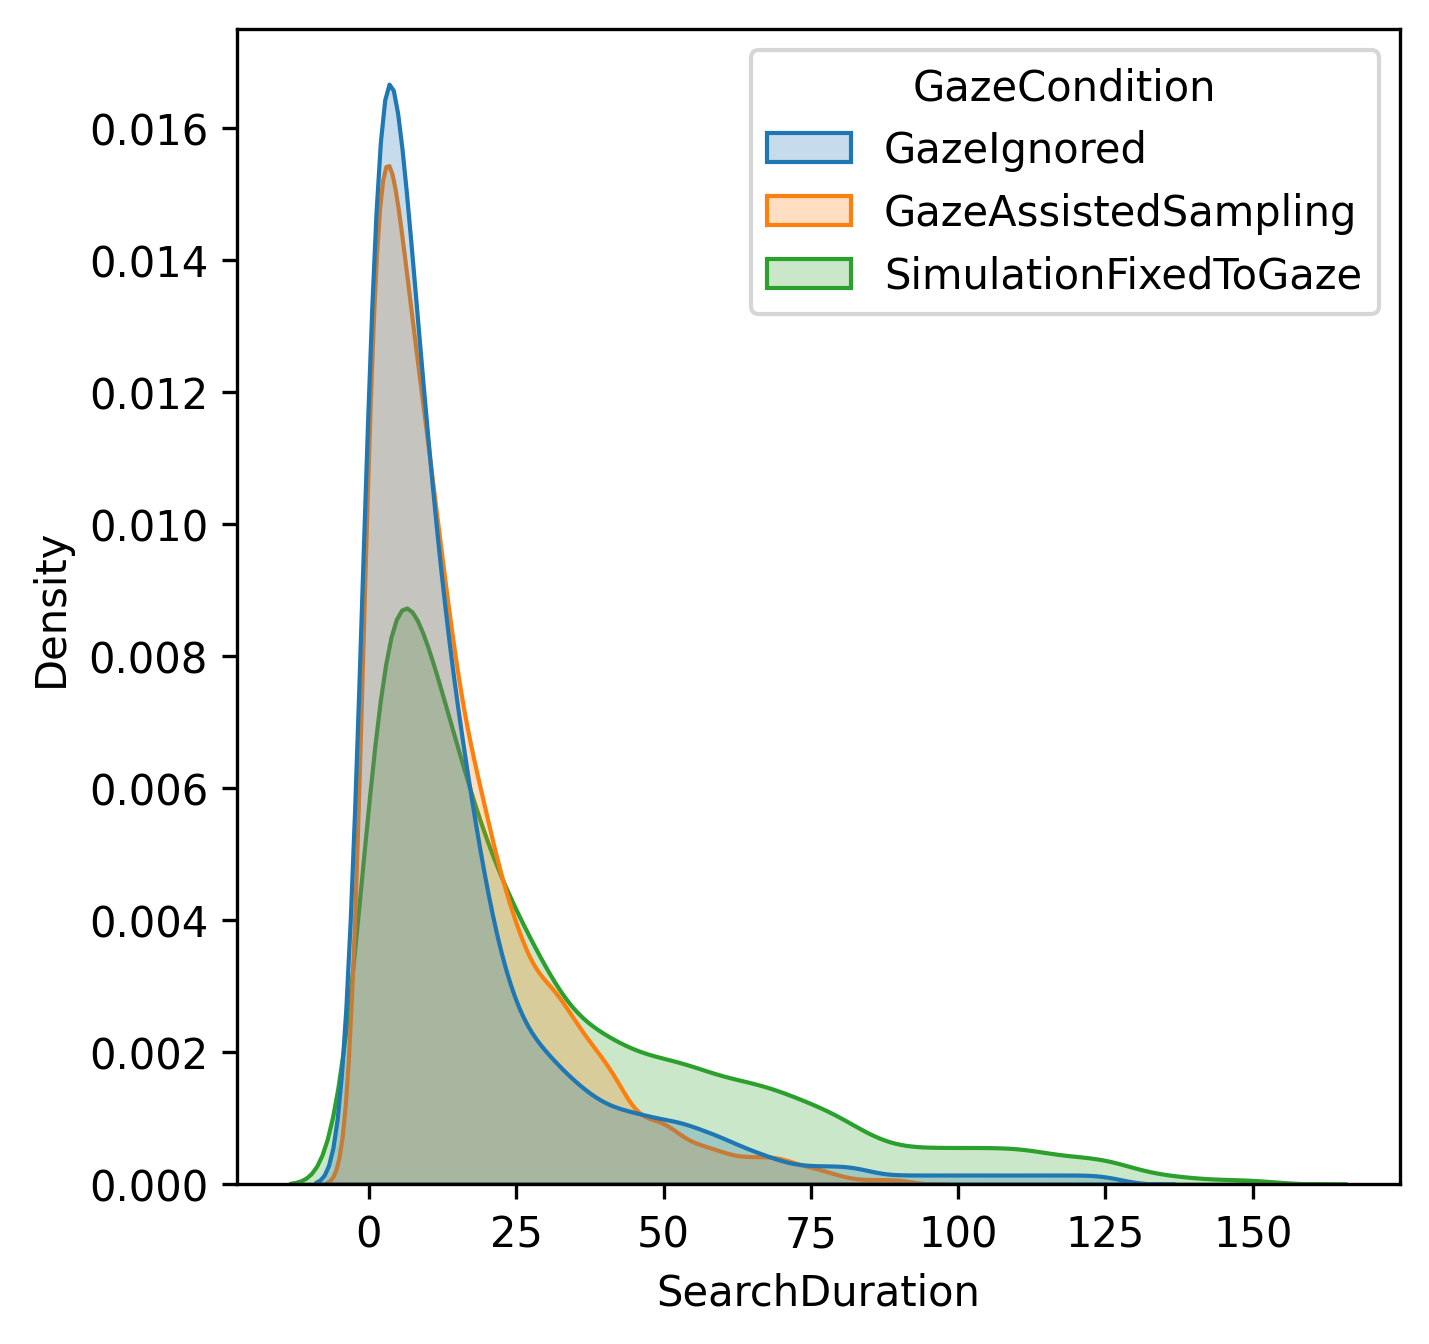

In [58]:
plt.figure(figsize=(5,5),dpi=300)
h = sns.kdeplot(data=data, x='SearchDuration', hue='GazeCondition', fill=True, hue_order=HUE_ORDER)
h.get_legend_handles_labels()

([], [])

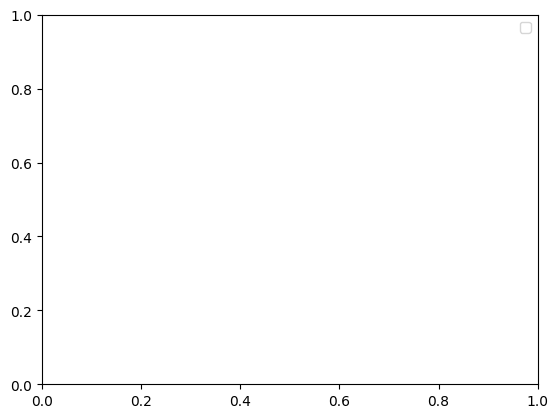

In [52]:
plt.figure()

plt.legend(hdl,lbl)

#### Absolute error, averaged per subject

In [483]:
def mean_absolute_error(data, endpoints, x='GazeCondition', group='Subject'):
    group_index = [x, group]
    absolute_error = data.set_index(group_index)[y].abs().reset_index()
    return average(absolute_error, y=y, x=x, group=group)

LocalizationErrorHand
LocalizationErrorEyes
LocalizationErrorHead


Text(0.5, 0.98, 'Absolute localization errors')

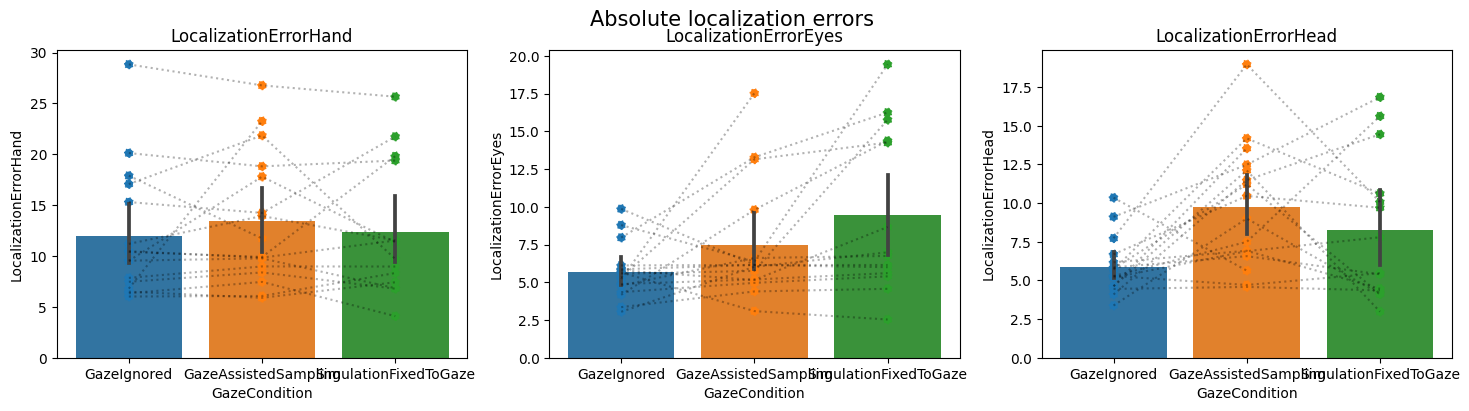

In [484]:
show = event_frames.loc[~invalid] # event_frames  or  event_frames.loc[~invalid]


# Absolute error averaged per subject
y = ['LocalizationErrorHand', 'LocalizationErrorEyes', 'LocalizationErrorHead']  
mae = mean_absolute_error(show, y)


fig, axs = bar_plots(mae, y)
_, _ = swarm_plots(mae, y, group='Subject',axs=axs, jitter=0)
fig.suptitle("Absolute localization errors", fontsize=15)

In [ ]:
absolute_error.groupby(['Subject', 'GazeCondition']).mean().reset_index()

<Axes: xlabel='ActiveTarget', ylabel='LocalizationErrorEyes'>

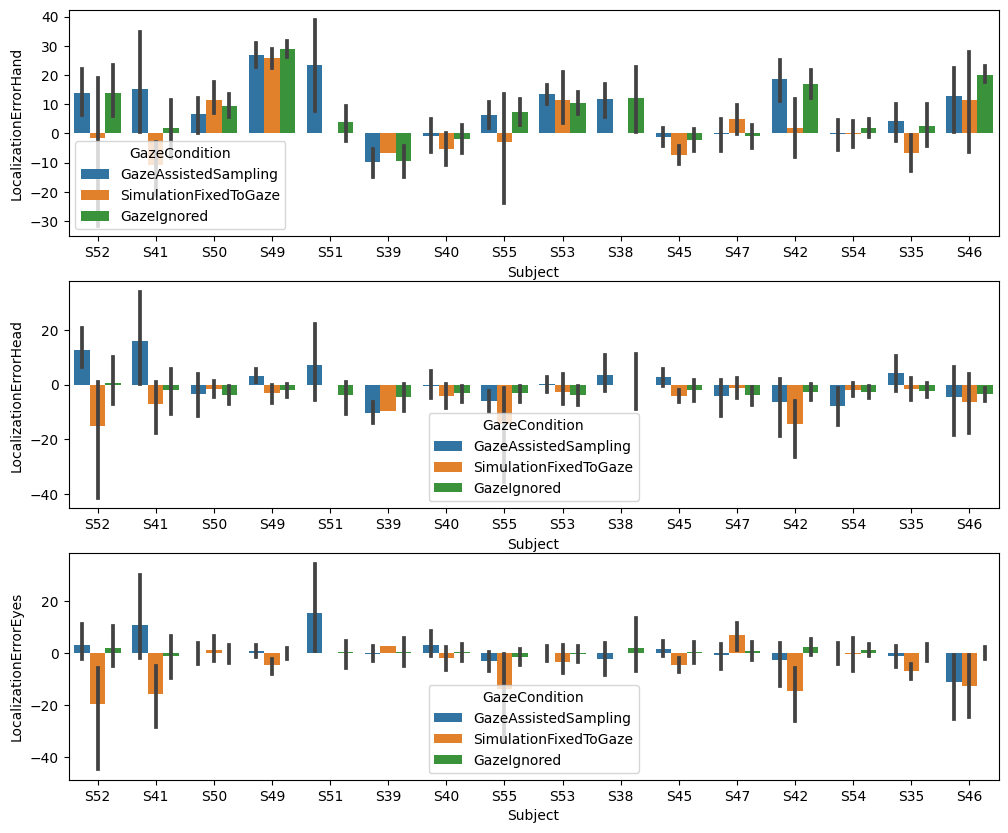

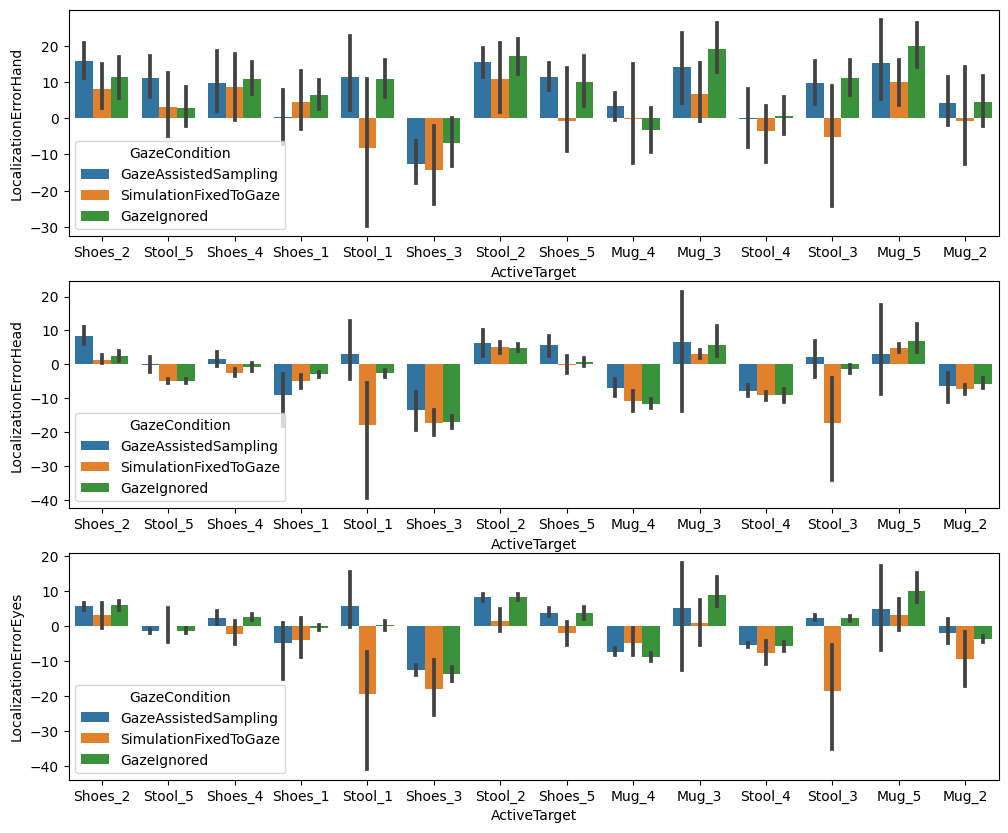

In [485]:
show = event_frames.loc[~invalid] # event_frames  or  event_frames.loc[~invalid]

fig, axs = plt.subplots(3,1,figsize=(12,10),dpi=100)
sns.barplot(data=show, y='LocalizationErrorHand', x='Subject', hue='GazeCondition', ax=axs[0])
sns.barplot(data=show, y='LocalizationErrorHead', x='Subject', hue='GazeCondition', ax=axs[1])
sns.barplot(data=show, y='LocalizationErrorEyes', x='Subject', hue='GazeCondition', ax=axs[2])

fig, axs = plt.subplots(3,1,figsize=(12,10),dpi=100)
sns.barplot(data=show, y='LocalizationErrorHand', x='ActiveTarget', hue='GazeCondition', ax=axs[0])
sns.barplot(data=show, y='LocalizationErrorHead', x='ActiveTarget', hue='GazeCondition', ax=axs[1])
sns.barplot(data=show, y='LocalizationErrorEyes', x='ActiveTarget', hue='GazeCondition', ax=axs[2])

Index(['S37', 'S38', 'S39', 'S51'], dtype='object', name='Subject')

In [326]:
event_frames.Subject.isin(invalid_subjects)

TrialIdentifier  ReportedEventsCount
S37B2T0          0.0                    False
                 1.0                    False
                 2.0                    False
S37B4T0          0.0                    False
                 1.0                    False
                                        ...  
S46B9T1          9.0                    False
                 10.0                   False
                 11.0                   False
S46B9T2          0.0                    False
                 1.0                    False
Name: Subject, Length: 580, dtype: bool

In [321]:
std_target.sort_values('LocalizationErrorHand')

LocalizationErrorHand  LocalizationErrorHead  \
ActiveTarget                                                 
Mug_4                     10.305972               3.947851   
Shoes_2                   10.920475               6.564528   
Shoes_4                   20.552255               3.785062   
Shoes_1                   22.062227              20.833814   
Shoes_5                   23.245046              21.497667   
Mug_2                     26.103846              24.849338   
Shoes_3                   28.691514              17.386106   
Mug_5                     29.000718              29.167668   
Stool_4                   29.097137              27.758526   
Stool_1                   32.120721              30.493569   
Stool_5                   39.244628              39.462054   
Mug_3                     43.215822              44.751822   
Stool_2                   46.257476              45.307178   
Stool_3                   68.144281              69.573168   

              LocalizationErrorEyes  
ActiveTarget                         
Mug_4                      3.683615  
Shoes_2                    5.335075  
Shoes_4                    5.250980  
Shoes_1                   23.458863  
Shoes_5                   20.842517  
Mug_2                     24.715987  
Shoes_3                   17.286539  
Mug_5                     29.619845  
Stool_4                   27.466307  
Stool_1                   30.276454  
Stool_5                   41.140497  
Mug_3                     43.477087  
Stool_2                   45.018157  
Stool_3                   68.681147

<Axes: xlabel='Subject', ylabel='LocalizationErrorEyes'>

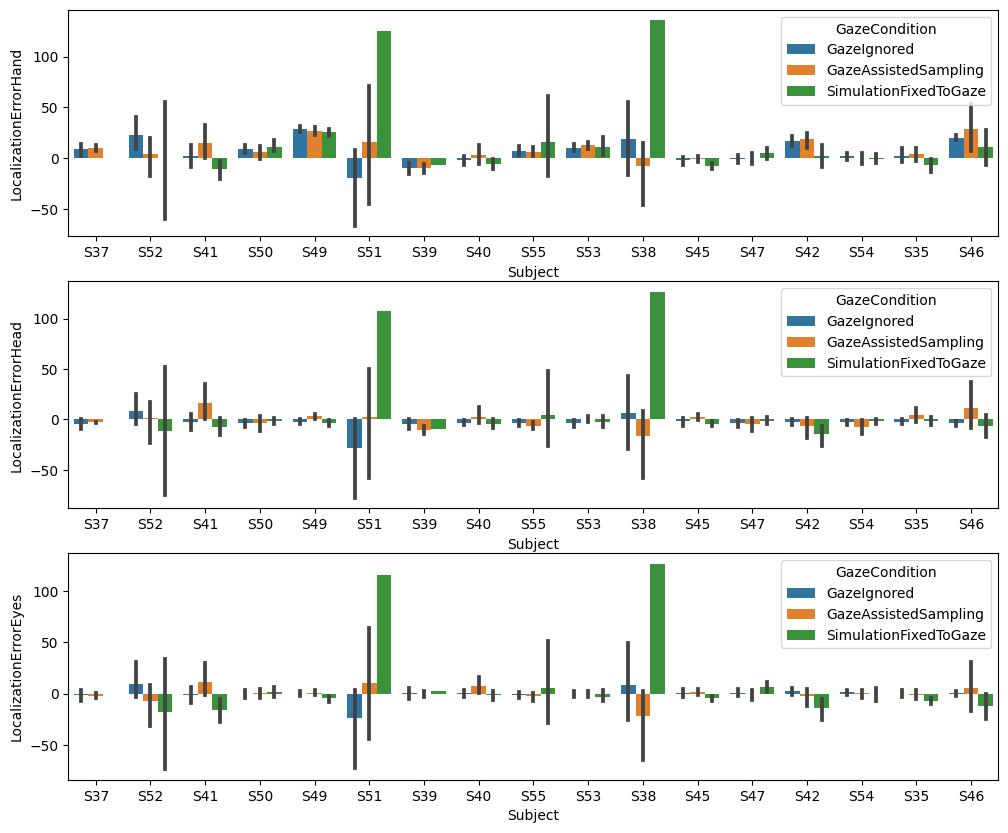

In [365]:
fig, axs = plt.subplots(3,1,figsize=(12,10),dpi=100)
sns.barplot(data=event_frames, y='LocalizationErrorHand', x='Subject', hue='GazeCondition', ax=axs[0])
sns.barplot(data=event_frames, y='LocalizationErrorHead', x='Subject', hue='GazeCondition', ax=axs[1])
sns.barplot(data=event_frames, y='LocalizationErrorEyes', x='Subject', hue='GazeCondition', ax=axs[2])

<Axes: xlabel='ActiveTarget', ylabel='LocalizationErrorEyes'>

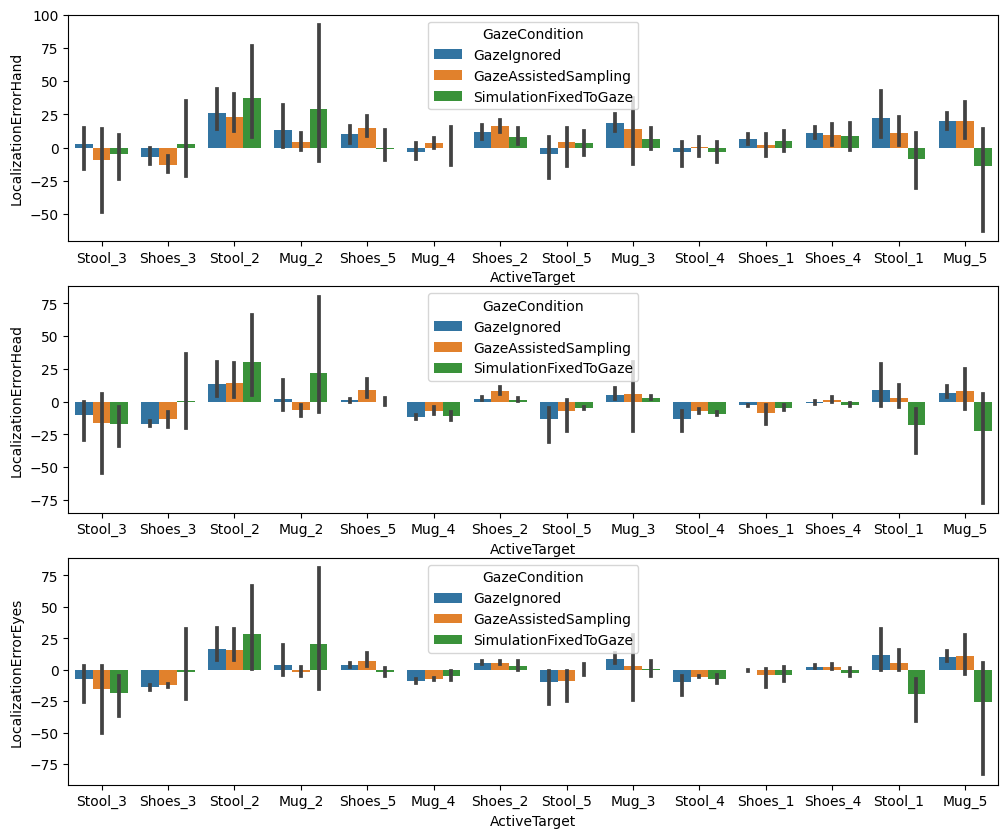

In [366]:
fig, axs = plt.subplots(3,1,figsize=(12,10),dpi=100)
sns.barplot(data=event_frames, y='LocalizationErrorHand', x='ActiveTarget', hue='GazeCondition', ax=axs[0])
sns.barplot(data=event_frames, y='LocalizationErrorHead', x='ActiveTarget', hue='GazeCondition', ax=axs[1])
sns.barplot(data=event_frames, y='LocalizationErrorEyes', x='ActiveTarget', hue='GazeCondition', ax=axs[2])

In [258]:
event_frames.loc[invalid]

ActiveTarget Subject  Block  \
TrialIdentifier ReportedEventsCount                               
S37B4T0         1.0                      Shoes_2     S37      4   
S41B7T1         2.0                        Mug_2     S41      7   
S41B8T2         0.0                        Mug_5     S41      8   
S38B1T0         0.0                      Stool_3     S38      1   
                2.0                      Stool_2     S38      1   
...                                          ...     ...    ...   
S46B9T1         6.0                      Shoes_2     S46      9   
                7.0                      Stool_5     S46      9   
                8.0                        Mug_3     S46      9   
                9.0                      Shoes_4     S46      9   
                10.0                     Stool_4     S46      9   

                                     RelativeTrialNumber ExperimentalTask  \
TrialIdentifier ReportedEventsCount                                         
S37B4T0         1.0                                    0     VisualSearch   
S41B7T1         2.0                                    1     VisualSearch   
S41B8T2         0.0                                    2     VisualSearch   
S38B1T0         0.0                                    0     VisualSearch   
                2.0                                    0     VisualSearch   
...                                                  ...              ...   
S46B9T1         6.0                                    1     VisualSearch   
                7.0                                    1     VisualSearch   
                8.0                                    1     VisualSearch   
                9.0                                    1     VisualSearch   
                10.0                                   1     VisualSearch   

                                            GazeCondition  \
TrialIdentifier ReportedEventsCount                         
S37B4T0         1.0                  GazeAssistedSampling   
S41B7T1         2.0                           GazeIgnored   
S41B8T2         0.0                  GazeAssistedSampling   
S38B1T0         0.0                  GazeAssistedSampling   
                2.0                  GazeAssistedSampling   
...                                                   ...   
S46B9T1         6.0                           GazeIgnored   
                7.0                           GazeIgnored   
                8.0                           GazeIgnored   
                9.0                           GazeIgnored   
                10.0                          GazeIgnored   

                                     TotalReportedEvents         HeadPosXZ  \
TrialIdentifier ReportedEventsCount                                          
S37B4T0         1.0                                    3 -0.50455+1.12140j   
S41B7T1         2.0                                    3 -0.73121+1.41953j   
S41B8T2         0.0                                    1 -0.47314+1.08854j   
S38B1T0         0.0                                    4 -0.48311+0.85513j   
                2.0                                    4 -0.52137+0.84410j   
...                                                  ...               ...   
S46B9T1         6.0                                   12 -0.47818+1.10269j   
                7.0                                   12 -0.61905+1.04045j   
                8.0                                   12 -0.43601+1.00982j   
                9.0                                   12 -0.60607+1.13605j   
                10.0                                  12 -0.70439+1.06080j   

                                            HandPosXZ          OrgPosXZ  ...  \
TrialIdentifier ReportedEventsCount                                      ...   
S37B4T0         1.0                 -0.37289+1.30508j -0.62064+0.87984j  ...   
S41B7T1         2.0                 -0.87799+1.92513j -0.62064+0.87984j  ...   
S41B8T2         0.0              

In [252]:
invalid

TrialIdentifier  ReportedEventsCount
S37B2T0          0.0                    False
                 1.0                    False
                 2.0                    False
S37B4T0          0.0                    False
                 1.0                    False
                                        ...  
S46B9T1          9.0                    False
                 10.0                   False
                 11.0                   False
S46B9T2          0.0                    False
                 1.0                    False
Length: 580, dtype: bool

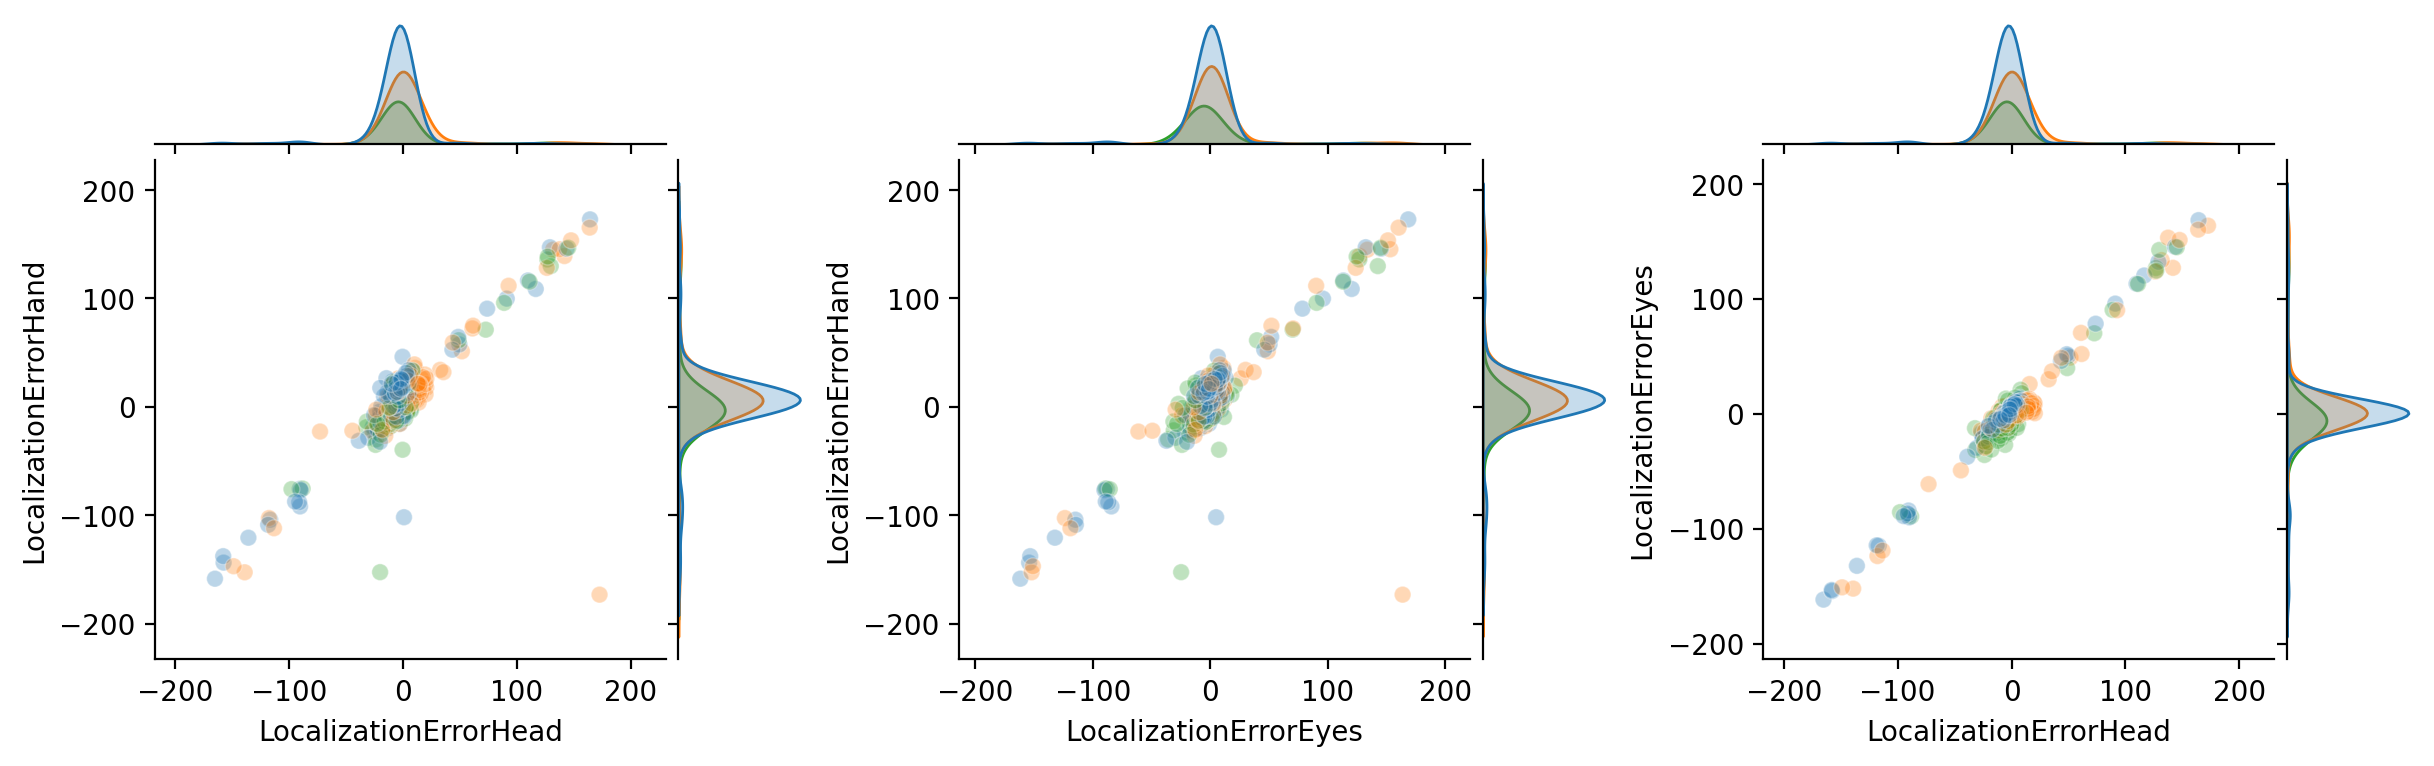

In [230]:
# Start with a square Figure.



plot_joint_plots(pairs)

In [189]:
dir(ax1)

['ArtistList',
 '_AxesBase__clear',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autotitlepos',
 '_axes',
 '_axes_locator',
 '_axis_map',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_errorevery_to_mask',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_fully_clipped_to_axes',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spine

In [130]:
hand_point_dir = angle_between(event_frames.HandPntXZ - event_frames.HeadPosXZ, np.ones_like(event_frames.HandPntXZ))
head_point_dir = angle_between(event_frames.HeadPntXZ - event_frames.HeadPosXZ, np.ones_like(event_frames.HandPntXZ))
eye_point_dir = angle_between(event_frames.EyePntXZ - event_frames.HeadPosXZ, np.ones_like(event_frames.HandPntXZ))


array([-3.71987836e+01, -1.73336687e+02,  3.93396092e+01, -1.77983507e+02,
        7.83609612e+01, -5.39640470e+01,  1.08100217e+02, -9.91993828e+01,
       -5.11211112e+01,  1.36426435e+02, -1.59500462e+02,  5.36650408e+01,
       -8.23412487e+01, -7.35323105e+00,  7.23936977e+01, -5.70453557e+01,
        1.28523141e+01, -9.50983867e+01, -4.78196350e+01, -2.43598774e+01,
       -1.56431136e+02,  4.81502162e+01, -8.94808834e+01, -1.24409437e+01,
       -1.76952717e+02,  7.87537499e+01, -6.38163938e+01,  1.68546300e+01,
       -9.86166490e+01, -4.76126224e+01, -9.50802037e+01, -7.03099683e+01,
        5.46947268e+00, -1.05485640e+02, -5.99946280e+01, -1.65677057e+02,
        3.65309095e+01,  1.11412951e+02,  1.69843710e+02,  5.51305977e+01,
       -6.83956067e+01, -1.14785981e+02, -7.21019057e+01,  7.21560762e+01,
       -1.79057211e+02,  2.95918246e+01, -1.00348479e+02,  1.73781845e+02,
        6.24389696e+01, -6.87622576e+01,  4.79948933e+00, -1.06244597e+02,
       -5.38448282e+01,  

In [132]:
event_frames.HandPntXZ - event_frames.HeadPosXZ

TrialIdentifier  ReportedEventsCount
S37B2T0          0.0                    0.68135-0.51715j
                 1.0                   -0.63600-0.07430j
                 2.0                    1.93458+1.58567j
S37B4T0          0.0                   -1.78392-0.06281j
                 1.0                    0.63027+3.05985j
                                              ...       
S46B9T1          9.0                   -0.89042+1.54796j
                 10.0                   0.70506-6.17887j
                 11.0                   2.10138-1.94192j
S46B9T2          0.0                    2.08859+0.86898j
                 1.0                    3.44792-1.61024j
Length: 580, dtype: complex128

In [129]:
np.ones(10).astype(complex)

array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j])

In [117]:
point_dir = event_frames.HandPntXZ - event_frames.HeadPosXZ
head_dir = event_frames.HeadPntXZ - event_frames.HeadPosXZ
eye_dir = event_frames.EyePntXZ - event_frames.HeadPosXZ

In [124]:
event_frames.groupby(subject)['']

TrialIdentifier  ReportedEventsCount
S37B2T0          0.0                   -1.66593+1.29748j
                 1.0                    0.03271-0.15335j
                 2.0                   -0.10506+0.35735j
S37B4T0          0.0                   -0.02185-0.25584j
                 1.0                   -1.08334+0.85037j
                                              ...       
S46B9T1          9.0                   -0.81526-0.07596j
                 10.0                   1.86003-3.66384j
                 11.0                   0.87840+0.28511j
S46B9T2          0.0                   -1.61342+0.75693j
                 1.0                    1.15038-0.09952j
Length: 580, dtype: complex128

In [68]:
event_frames.columns

Index(['TimeStamp', 'XROriginPos', 'XROriginRot', 'XRHeadPos', 'XRHeadRot',
       'HandLPos', 'HandLRot', 'HandRPos', 'HandRRot', 'CollisionCount',
       'FrameCount', 'ReportedEventsCount', 'ActiveTarget',
       'PointLocationHand', 'PointLocationEye', 'PointLocationHead',
       'TargetHit', 'Unnamed: 17', 'Subject', 'Block', 'RelativeTrialNumber',
       'TrialIdentifier', 'ExperimentalTask', 'GazeCondition', 'XROriginDir',
       'XRHeadDir', 'HandLDir', 'HandRDir', 'XROriginPosX', 'XROriginPosY',
       'XROriginPosZ', 'XROriginRotW', 'XROriginRotX', 'XROriginRotY',
       'XROriginRotZ', 'XRHeadPosX', 'XRHeadPosY', 'XRHeadPosZ', 'XRHeadRotW',
       'XRHeadRotX', 'XRHeadRotY', 'XRHeadRotZ', 'HandLPosX', 'HandLPosY',
       'HandLPosZ', 'HandLRotW', 'HandLRotX', 'HandLRotY', 'HandLRotZ',
       'HandRPosX', 'HandRPosY', 'HandRPosZ', 'HandRRotW', 'HandRRotX',
       'HandRRotY', 'HandRRotZ', 'PointLocationHandX', 'PointLocationHandY',
       'PointLocationHandZ', 'PointLocationE

In [67]:
event_frames

TimeStamp               XROriginPos           XROriginRot  \
8058    638149907045201073  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
8145    638149907219176227  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
8224    638149907377207540  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
11642   638149921096000503  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
11812   638149921435955494  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
...                    ...                       ...                   ...   
222769  638158567116670398  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
222820  638158567218763806  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
222838  638158567254705004  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
223307  638158568274484098  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
223485  638158568630556079  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   

                           XRHeadPos                                XRHeadRot  \
8058     (-1.0432, 1.36208, 0.71753)     (0.0451, 0.89376, -0.07967, 0.43911)   
8145     (-0.97986, 1.31514, 0.7943)    (0.22055, -0.63417, 0.18486, 0.71764)   
8224    (-0.95192, 1.35214, 1.01417)     (0.0975, 0.49083, -0.08376, 0.86172)   
11642    (-0.6976, 1.37513, 1.43435)    (0.00948, -0.66751, 0.03812, 0.74357)   
11812    (-0.50455, 1.33613, 1.1214)     (0.18304, 0.31373, -0.03349, 0.9311)   
...                              ...                                      ...   
222769  (-0.60607, 1.57412, 1.13605)    (0.26029, -0.01824, -0.0081, 0.96532)   
222820   (-0.70439, 1.61723, 1.0608)  (-0.05928, 0.96938, -0.10006, -0.21629)   
222838  (-0.62656, 1.58941, 1.06242)   (-0.00217, 0.94881, -0.21531, 0.23106)   
223307  (-0.35108, 1.59616, 0.94004)     (0.09901, 0.6898, -0.12728, 0.70581)   
223485  (-0.38499, 1.58003, 1.09394)    (0.07054, 0.86567, -0.17863, 0.46231)   

                            HandLPos                                 HandLRot  \
8058    (-0.90938, 0.57945, 0.80598)    (-0.2213, 0.85383, -0.41141, 0.22968)   
8145     (-1.01572, 0.58864, 0.6541)   (0.47201, -0.35757, -0.18941, 0.78325)   
8224    (-1.07673, 0.56999, 1.17503)    (0.06915, 0.54671, -0.53974, 0.63641)   
11642   (-0.74766, 0.57227, 1.28978)   (0.47961, -0.44219, -0.09588, 0.75183)   
11812   (-0.61643, 0.57272, 1.26681)     (0.1431, 0.44569, -0.48367, 0.73956)   
...                              ...                                      ...   
222769  (-0.84919, 0.64348, 1.09185)    (0.30416, 0.42161, -0.53444, 0.66641)   
222820   (-0.55632, 0.65231, 0.9459)    (0.58794, -0.48843, 0.04548, 0.64319)   
222838  (-0.49206, 0.64561, 1.06153)      (0.55949, -0.603, 0.18828, 0.53658)   
223307    (-0.2841, 0.71419, 1.2039)    (0.33793, 0.45578, -0.22985, 0.79072)   
223485  (-0.29498, 0.65009, 1.28707)  (-0.39785, 0.76057, -0.51217, -0.03051)   

                            HandRPos                                HandRRot  \
8058    (-1.04904, 0.63382, 0.48072)    (0.54639, 0.58784, 0.00465, 0.59656)   
8145    (-1.17284, 1.04499, 0.84516)   (0.23078, -0.75315, 0.13889, 0.60017)   
8224     (-0.75909, 1.1269, 1.11141)  (-0.06814, 0.41277, -0.16362, 0.89342)   
11642   (-0.94399, 1.13166, 1.52293)     (0.09417, -0.73534, -0.0828, 0.666)   
11812   (-0.37289, 1.13054, 1.30508)   (0.11165, 0.09574, -0.10659, 0.98337)   
...                              ...                                     ...   
222769  (-0.70301, 0.87045, 1.50378)   (0.10803, -0.35139, 0.41794, 0.83077)   
222820  (-0.80036, 0.95121, 0.75161)    (0.28527, 0.9528, -0.05671, 0.08705)   
222838    (-0.59012, 0.8508, 0.8727)   (0.29401, 0.85167, -0.00324, 0.43383)   
223307  (-0.08653, 1.11761, 0.93278)  (-0.10924, 0.52207, -0.24002, 0.81111)   
223485   (-0.14828, 1.12472, 0.8582)     (0.07703, 0.83118, 0.0785, 0.54501)   

        CollisionCount  ...  XRHeadDirZ  HandLDirX HandLDirY HandLDirZ  \
8058                 0  ...   -0.601673   0.574299 -0.600886 -0.555982   
8145                 0  .

In [59]:
event_frames = data.loc[event_occurred]


In [48]:
data.loc[data.ReportedAsFound]

TimeStamp               XROriginPos           XROriginRot  \
7857    638149906643218755  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
7858    638149906645168744  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
7859    638149906647168746  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
7860    638149906649208765  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
7861    638149906651108743  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
...                    ...                       ...                   ...   
223480  638158568620576608  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
223481  638158568622705791  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
223482  638158568624555842  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
223483  638158568626555393  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
223484  638158568628556008  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   

                           XRHeadPos                               XRHeadRot  \
7857    (-0.66012, 1.38473, 1.04142)  (-0.00311, 0.04927, -0.01791, 0.99862)   
7858    (-0.65375, 1.38573, 1.04523)  (-0.00767, 0.07567, -0.01015, 0.99705)   
7859    (-0.65512, 1.38413, 1.04647)    (0.00154, 0.06747, -0.01572, 0.9976)   
7860    (-0.65919, 1.38259, 1.04686)   (0.00977, 0.05174, -0.01822, 0.99845)   
7861    (-0.66163, 1.38807, 1.04612)  (-0.01992, 0.04455, -0.01762, 0.99865)   
...                              ...                                     ...   
223480  (-0.38036, 1.59102, 1.07162)   (0.06664, 0.85768, -0.17822, 0.47769)   
223481  (-0.38051, 1.58967, 1.07224)   (0.06984, 0.86279, -0.18037, 0.46709)   
223482  (-0.38385, 1.58594, 1.07394)   (0.06773, 0.86873, -0.17976, 0.45651)   
223483  (-0.38592, 1.58519, 1.08112)   (0.06635, 0.86566, -0.17432, 0.46458)   
223484  (-0.38642, 1.58218, 1.08784)   (0.06766, 0.86476, -0.17797, 0.46469)   

                            HandLPos                                 HandLRot  \
7857    (-0.81491, 0.57506, 1.10387)    (0.24254, 0.28414, -0.43229, 0.82071)   
7858     (-0.8121, 0.57593, 1.10602)      (0.23667, 0.29942, -0.43787, 0.814)   
7859    (-0.81269, 0.57642, 1.10576)     (0.2366, 0.30247, -0.43709, 0.81331)   
7860    (-0.81516, 0.57606, 1.10574)     (0.2434, 0.29692, -0.43689, 0.81347)   
7861    (-0.81481, 0.57521, 1.10463)    (0.24199, 0.29925, -0.43838, 0.81223)   
...                              ...                                      ...   
223480    (-0.28846, 0.649, 1.24511)  (-0.40422, 0.76398, -0.50096, -0.04457)   
223481  (-0.29197, 0.64754, 1.25243)  (-0.40035, 0.76413, -0.50385, -0.04427)   
223482  (-0.29725, 0.64486, 1.26185)  (-0.40037, 0.76234, -0.50528, -0.05695)   
223483  (-0.29517, 0.64769, 1.26579)  (-0.40319, 0.76253, -0.50359, -0.04883)   
223484  (-0.29257, 0.65223, 1.27114)  (-0.40371, 0.76253, -0.50413, -0.03769)   

                            HandRPos                               HandRRot  \
7857    (-0.47819, 0.61165, 1.10234)  (0.25237, -0.27656, 0.42305, 0.82514)   
7858    (-0.47484, 0.61121, 1.09968)  (0.25906, -0.26289, 0.41472, 0.83173)   
7859    (-0.47338, 0.60993, 1.09677)   (0.26447, -0.26207, 0.4152, 0.83005)   
7860    (-0.47626, 0.61053, 1.09751)   (0.25844, -0.2749, 0.42292, 0.82388)   
7861     (-0.4754, 0.61035, 1.09584)   (0.26196, -0.27336, 0.42112, 0.8242)   
...                              ...                                    ...   
223480  (-0.38824, 0.65455, 0.92827)   (0.53783, 0.36674, 0.02736, 0.75861)   
223481   (-0.3569, 0.68044, 0.93627)   (0.4781, 0.44639, -0.02691, 0.75593)   
223482  (-0.24265, 0.80855, 0.92804)  (0.27903, 0.63091, -0.05259, 0.72203)   
223483   (-0.16102, 1.00743, 0.9137)    (0.0881, 0.73209, 0.04713, 0.67384)   
223484  (-0.14561, 1.10254, 0.87296)   (0.05516, 0.81156, 0.05856, 0.57871)   

        CollisionCount  ...  XRHeadDirZ  HandLDirX HandLDirY HandLDirZ  \
7857                 0  ...    0.995126   0.256698 -0.643771  0.720878   
7858                 0  ...    0.988430   0.28019

In [46]:
data[targ_index + ['TotalReportedEvents','ReportedAsFound',]][800:1200]

TrialIdentifier  ReportedEventsCount  TotalReportedEvents  \
8136         S37B2T0                    1                    3   
8137         S37B2T0                    1                    3   
8138         S37B2T0                    1                    3   
8139         S37B2T0                    1                    3   
8140         S37B2T0                    1                    3   
...              ...                  ...                  ...   
9590         S37B3T0                    0                    0   
9591         S37B3T0                    0                    0   
9592         S37B3T0                    0                    0   
9593         S37B3T0                    0                    0   
9594         S37B3T0                    0                    0   

      ReportedAsFound  
8136             True  
8137             True  
8138             True  
8139             True  
8140             True  
...               ...  
9590            False  
9591            False  
9592            False  
9593            False  
9594            False  

[400 rows x 4 columns]

In [19]:
data['TotalEventsReported'] = data.groupby('TrialIdentifier').ReportedEventsCount.max().loc[data.TrialIdentifier]

/tmp/ipykernel_2046126/1202340077.py:1: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  data['TotalEventsReported'] = data.groupby('TrialIdentifier').ReportedEventsCount.max().loc[data.TrialIdentifier]


ValueError: cannot reindex on an axis with duplicate labels

In [441]:
n_events

ValueError: Cannot index with multidimensional key

<Axes: >

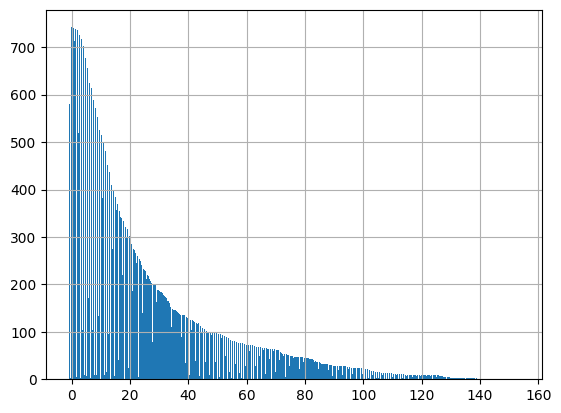

In [435]:
data.SecondsSinceEvent.hist(bins=150)

6553       True
6554      False
6555      False
6556      False
6557      False
          ...  
223543    False
223544    False
223545    False
223546    False
223547    False
Name: TrialIdentifier, Length: 95889, dtype: bool

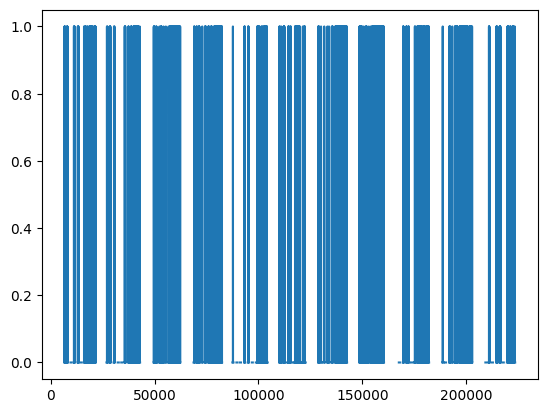

In [378]:
plt.plot(data.groupby(trial_index).ReportedEventsCount.diff())

In [385]:
data.TrialIdentifier

6553      S38B1T0
6554      S38B1T0
6555      S38B1T0
6556      S38B1T0
6557      S38B1T0
           ...   
223543    S37B8T2
223544    S37B8T2
223545    S37B8T2
223546    S37B8T2
223547    S37B8T2
Name: TrialIdentifier, Length: 95889, dtype: object

In [382]:
data.groupby(trial_index).TrialIndex

AttributeError: 'DataFrameGroupBy' object has no attribute 'TrialIndex'

In [375]:
(data.groupby(trial_index).ReportedEventsCount.diff() >0).sum()

580

In [363]:
event_mask = data.groupby(targ_index).ReportedEventsCount.diff()!=0
event_mask.sum()

742

In [31]:
# Load all targets
TARGETS = get_target_locations()
TARGETS['Color'] = get_colors(TARGETS.index).values()

# specify targets of interest 
targets = TARGETS 

event_frames = final_frames

# Positions and orientations of the sensors (head and hand)
head_pos = (event_frames.XRHeadPosX + event_frames.XRHeadPosZ*1j).values
head_dir = (event_frames.XRHeadDirX + event_frames.XRHeadDirZ*1j).values
hand_pos = (event_frames.HandRPosX + event_frames.HandRPosZ*1j).values
hand_dir = (event_frames.HandRDirX + event_frames.HandRDirZ*1j).values
org_pos = (event_frames.XROriginPosX + event_frames.XROriginPosZ * 1j).values
org_dir = (event_frames.XROriginDirX + event_frames.XROriginDirZ * 1j).values

# Position of the targets
trg_pos = (targets.loc[event_frames['ActiveTarget']].PosX + \
           targets.loc[event_frames['ActiveTarget']].PosZ * 1j).values

# Pointing locations
hand_point = (event_frames.PointLocationHandX + event_frames.PointLocationHandZ*1j).values
head_point = (event_frames.PointLocationHeadX + event_frames.PointLocationHeadZ*1j).values
eyes_point = (event_frames.PointLocationEyeX + event_frames.PointLocationEyeZ*1j).values

# 
event_frames['LocalizationErrorHand'] = angle_between(hand_point-hand_pos, trg_pos-hand_pos)
event_frames['LocalizationErrorHead'] = angle_between(head_point-head_pos, trg_pos-head_pos)
event_frames['LocalizationErrorEyes'] = angle_between(eyes_point-head_pos, trg_pos-head_pos)

# invalid = event_frames[event_frames.SecondsSinceEvent > MAX_TIME].index
# invalid = event_frames.append(last_frames[event_frames.SecondsSinceEvent < MIN_TIME].index)
# invalid = event_frames.append()

NameError: name 'final_frames' is not defined

In [343]:
colors

TargetName
Stool_2       [0.153364, 0.497, 0.557724, 0.25]
Mug_2       [0.28291, 0.105393, 0.426902, 0.25]
Shoes_5    [0.993248, 0.906157, 0.143936, 0.25]
Name: Color, dtype: object

In [356]:
hits.PointLocationHandZ

TrialIdentifier  ReportedEventsCount
S35B1T0          0                      0.0
                 1                      0.0
                 2                      0.0
S35B2T0          0                      0.0
                 1                      0.0
                 2                      0.0
                 3                      0.0
S35B3T0          0                      0.0
                 1                      0.0
                 2                      0.0
                 3                      0.0
S35B4T0          0                      0.0
S35B5T0          0                      0.0
S35B6T0          0                      0.0
                 1                      0.0
Name: PointLocationHandZ, dtype: float64

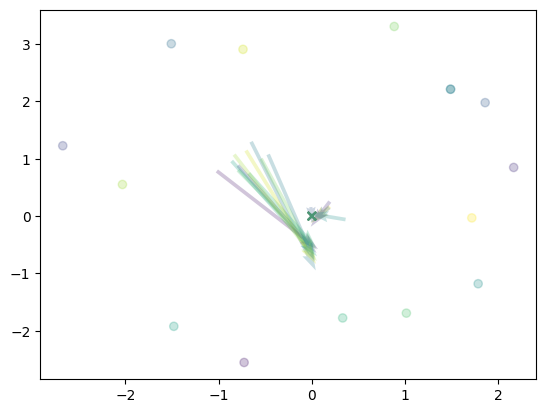

In [352]:
targets = TARGETS

hits = event_frames[:15]
colors = targets.loc[hits.ActiveTarget,'Color']
plt.quiver(hits.HandRPosX, hits.HandRPosZ, hits.PointLocationHandX-hits.HandRPosX, hits.PointLocationHandZ-hits.HandRPosZ, scale=5, color=colors)
plt.scatter(targets.loc[hits['ActiveTarget']].PosX, targets.loc[hits['ActiveTarget']].PosZ, c=colors)
plt.scatter( hits.PointLocationHandX, hits.PointLocationHandZ,marker='x', c=colors, )
# axs[2].scatter(np.real(eyes_point), np.imag(eyes_point),marker='+', c=colors, )
# axs[2].scatter(np.real(head_point), np.imag(head_point),marker='^', c=colors, )

In [ ]:

# axs[2].quiver(np.real(org_pos), np.imag(org_pos), np.real(org_dir), np.imag(org_dir), scale=5, color=colors)
axs[2].scatter(np.real(trg_pos), np.imag(trg_pos), c=colors)
axs[2].scatter(np.real(hand_point), np.imag(hand_point),marker='x', c=colors, )
axs[2].scatter(np.real(eyes_point), np.imag(eyes_point),marker='+', c=colors, )
axs[2].scatter(np.real(head_point), np.imag(head_point),marker='^', c=colors, )


<Axes: ylabel='Count'>

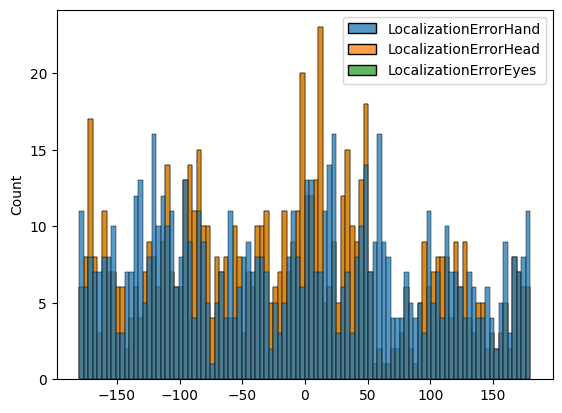

In [325]:
sns.histplot(event_frames[endpoints], bins=100)

In [315]:
endpoints = ['LocalizationErrorHand', 'LocalizationErrorHead', 'LocalizationErrorEyes']

avg = average(event_frames, y=endpoints, group='Subject', apply_function=lambda x: np.mean(np.abs(x)))
# fig, axs = bar_plots(avg, ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating'], alpha=0.6)
# _, _ = swarm_plots(avg, ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating'], group=GROUP,axs=axs, jitter=0)
# fig.suptitle("Averaged per subject", fontsize=15)
# plt.show()
# display(paired_wilcoxon(avg, group=GROUP))

avg

Subject          GazeCondition  LocalizationErrorHand  \
0      S35   GazeAssistedSampling              90.265565   
1      S35            GazeIgnored             109.631746   
2      S35  SimulationFixedToGaze              90.219659   
3      S37   GazeAssistedSampling              92.543450   
4      S37            GazeIgnored              81.203521   
5      S37  SimulationFixedToGaze              96.664002   
6      S38   GazeAssistedSampling              80.272392   
7      S38            GazeIgnored              77.871896   
8      S38  SimulationFixedToGaze             113.459719   
9      S39   GazeAssistedSampling              94.379947   
10     S39            GazeIgnored              93.006563   
11     S39  SimulationFixedToGaze              95.839013   
12     S40   GazeAssistedSampling              84.298578   
13     S40            GazeIgnored              88.009320   
14     S40  SimulationFixedToGaze              85.831207   
15     S41   GazeAssistedSampling              95.024278   
16     S41            GazeIgnored              84.430957   
17     S41  SimulationFixedToGaze              70.289871   
18     S42   GazeAssistedSampling              80.957469   
19     S42            GazeIgnored              94.946263   
20     S42  SimulationFixedToGaze              60.808374   
21     S45   GazeAssistedSampling              91.396850   
22     S45            GazeIgnored              93.004054   
23     S45  SimulationFixedToGaze             100.724533   
24     S46   GazeAssistedSampling              80.433969   
25     S46            GazeIgnored              84.560928   
26     S46  SimulationFixedToGaze             109.280561   
27     S47   GazeAssistedSampling              86.671985   
28     S47            GazeIgnored              99.365162   
29     S47  SimulationFixedToGaze              91.386777   
30     S48   GazeAssistedSampling              73.608513   
31     S48            GazeIgnored              75.287984   
32     S48  SimulationFixedToGaze              82.241555   

    LocalizationErrorHead  LocalizationErrorEyes  
0               78.829720              78.829720  
1              105.481116             105.481116  
2              101.054344             101.054344  
3               77.912516              77.912516  
4               76.915629              76.915629  
5               85.376832              85.376832  
6               78.943457              78.943457  
7               76.018711              76.018711  
8               99.233873              99.233873  
9               81.770591              81.770591  
10              82.608944              82.608944  
11              93.214482              93.214482  
12              75.783985              75.783985  
13              83.719888              83.719888  
14              79.828564              79.828564  
15              74.925289              74.925289  
16              78.230866              78.230866  
17              71.801883              71.801883  
18              76.100019              76.100019  
19              86.042306              86.042306  
20              58.658568              58.658568  
21              77.244321              77.244321  
22              75.187813              75.187813  
23              86.155716              86.155716  
24              74.056341              74.056341  
25              80.335538              80.335538  
26              96.341963              96.341963  
27              80.050656              80.050656  
28              88.910550              88.910550  
29              88.150272              88.150272  
30              73.314358              73.314358  
31              69.870753              69.870753  
32              79.522045              79.522045

In [313]:
avg

Subject          GazeCondition  LocalizationErrorHand  \
0      S35   GazeAssistedSampling              -1.066031   
1      S35            GazeIgnored             -54.358495   
2      S35  SimulationFixedToGaze              -6.117931   
3      S37   GazeAssistedSampling             -11.022658   
4      S37            GazeIgnored              -2.995163   
5      S37  SimulationFixedToGaze             -30.988106   
6      S38   GazeAssistedSampling              13.014696   
7      S38            GazeIgnored             -33.858176   
8      S38  SimulationFixedToGaze              -0.202119   
9      S39   GazeAssistedSampling               0.138451   
10     S39            GazeIgnored              -1.838253   
11     S39  SimulationFixedToGaze              -7.146364   
12     S40   GazeAssistedSampling             -14.797409   
13     S40            GazeIgnored               5.067719   
14     S40  SimulationFixedToGaze              12.022032   
15     S41   GazeAssistedSampling             -80.821440   
16     S41            GazeIgnored              11.199927   
17     S41  SimulationFixedToGaze              21.756333   
18     S42   GazeAssistedSampling             -23.940864   
19     S42            GazeIgnored              -9.605951   
20     S42  SimulationFixedToGaze              15.770738   
21     S45   GazeAssistedSampling              -7.863839   
22     S45            GazeIgnored               3.067336   
23     S45  SimulationFixedToGaze               8.179644   
24     S46   GazeAssistedSampling             -13.773600   
25     S46            GazeIgnored               4.226284   
26     S46  SimulationFixedToGaze             -27.430559   
27     S47   GazeAssistedSampling             -45.984689   
28     S47            GazeIgnored             -10.388964   
29     S47  SimulationFixedToGaze              -2.975163   
30     S48   GazeAssistedSampling             -39.409402   
31     S48            GazeIgnored             -19.065431   
32     S48  SimulationFixedToGaze               8.070824   

    LocalizationErrorHead  LocalizationErrorEyes  
0               29.982377              29.982377  
1              -34.761020             -34.761020  
2               12.505420              12.505420  
3               -5.971756              -5.971756  
4                2.294856               2.294856  
5              -17.489624             -17.489624  
6                3.601752               3.601752  
7              -24.553206             -24.553206  
8              -87.881785             -87.881785  
9                0.892834               0.892834  
10             -13.563955             -13.563955  
11             -37.381665             -37.381665  
12             -39.780565             -39.780565  
13              -7.089855              -7.089855  
14               2.115350               2.115350  
15             -64.949051             -64.949051  
16              -1.036393              -1.036393  
17              24.084044              24.084044  
18             -11.888266             -11.888266  
19             -25.477458             -25.477458  
20              12.451055              12.451055  
21              -9.397038              -9.397038  
22               9.192147               9.192147  
23             -34.560799             -34.560799  
24             -20.571040             -20.571040  
25              -3.840819              -3.840819  
26             -39.504424             -39.504424  
27             -33.552727             -33.552727  
28             -25.663611             -25.663611  
29               7.955293               7.955293  
30             -30.543251             -30.543251  
31             -24.295256             -24.295256  
32             -28.166107             -28.166107

<Axes: xlabel='GazeCondition', ylabel='ReportedEventsCount'>

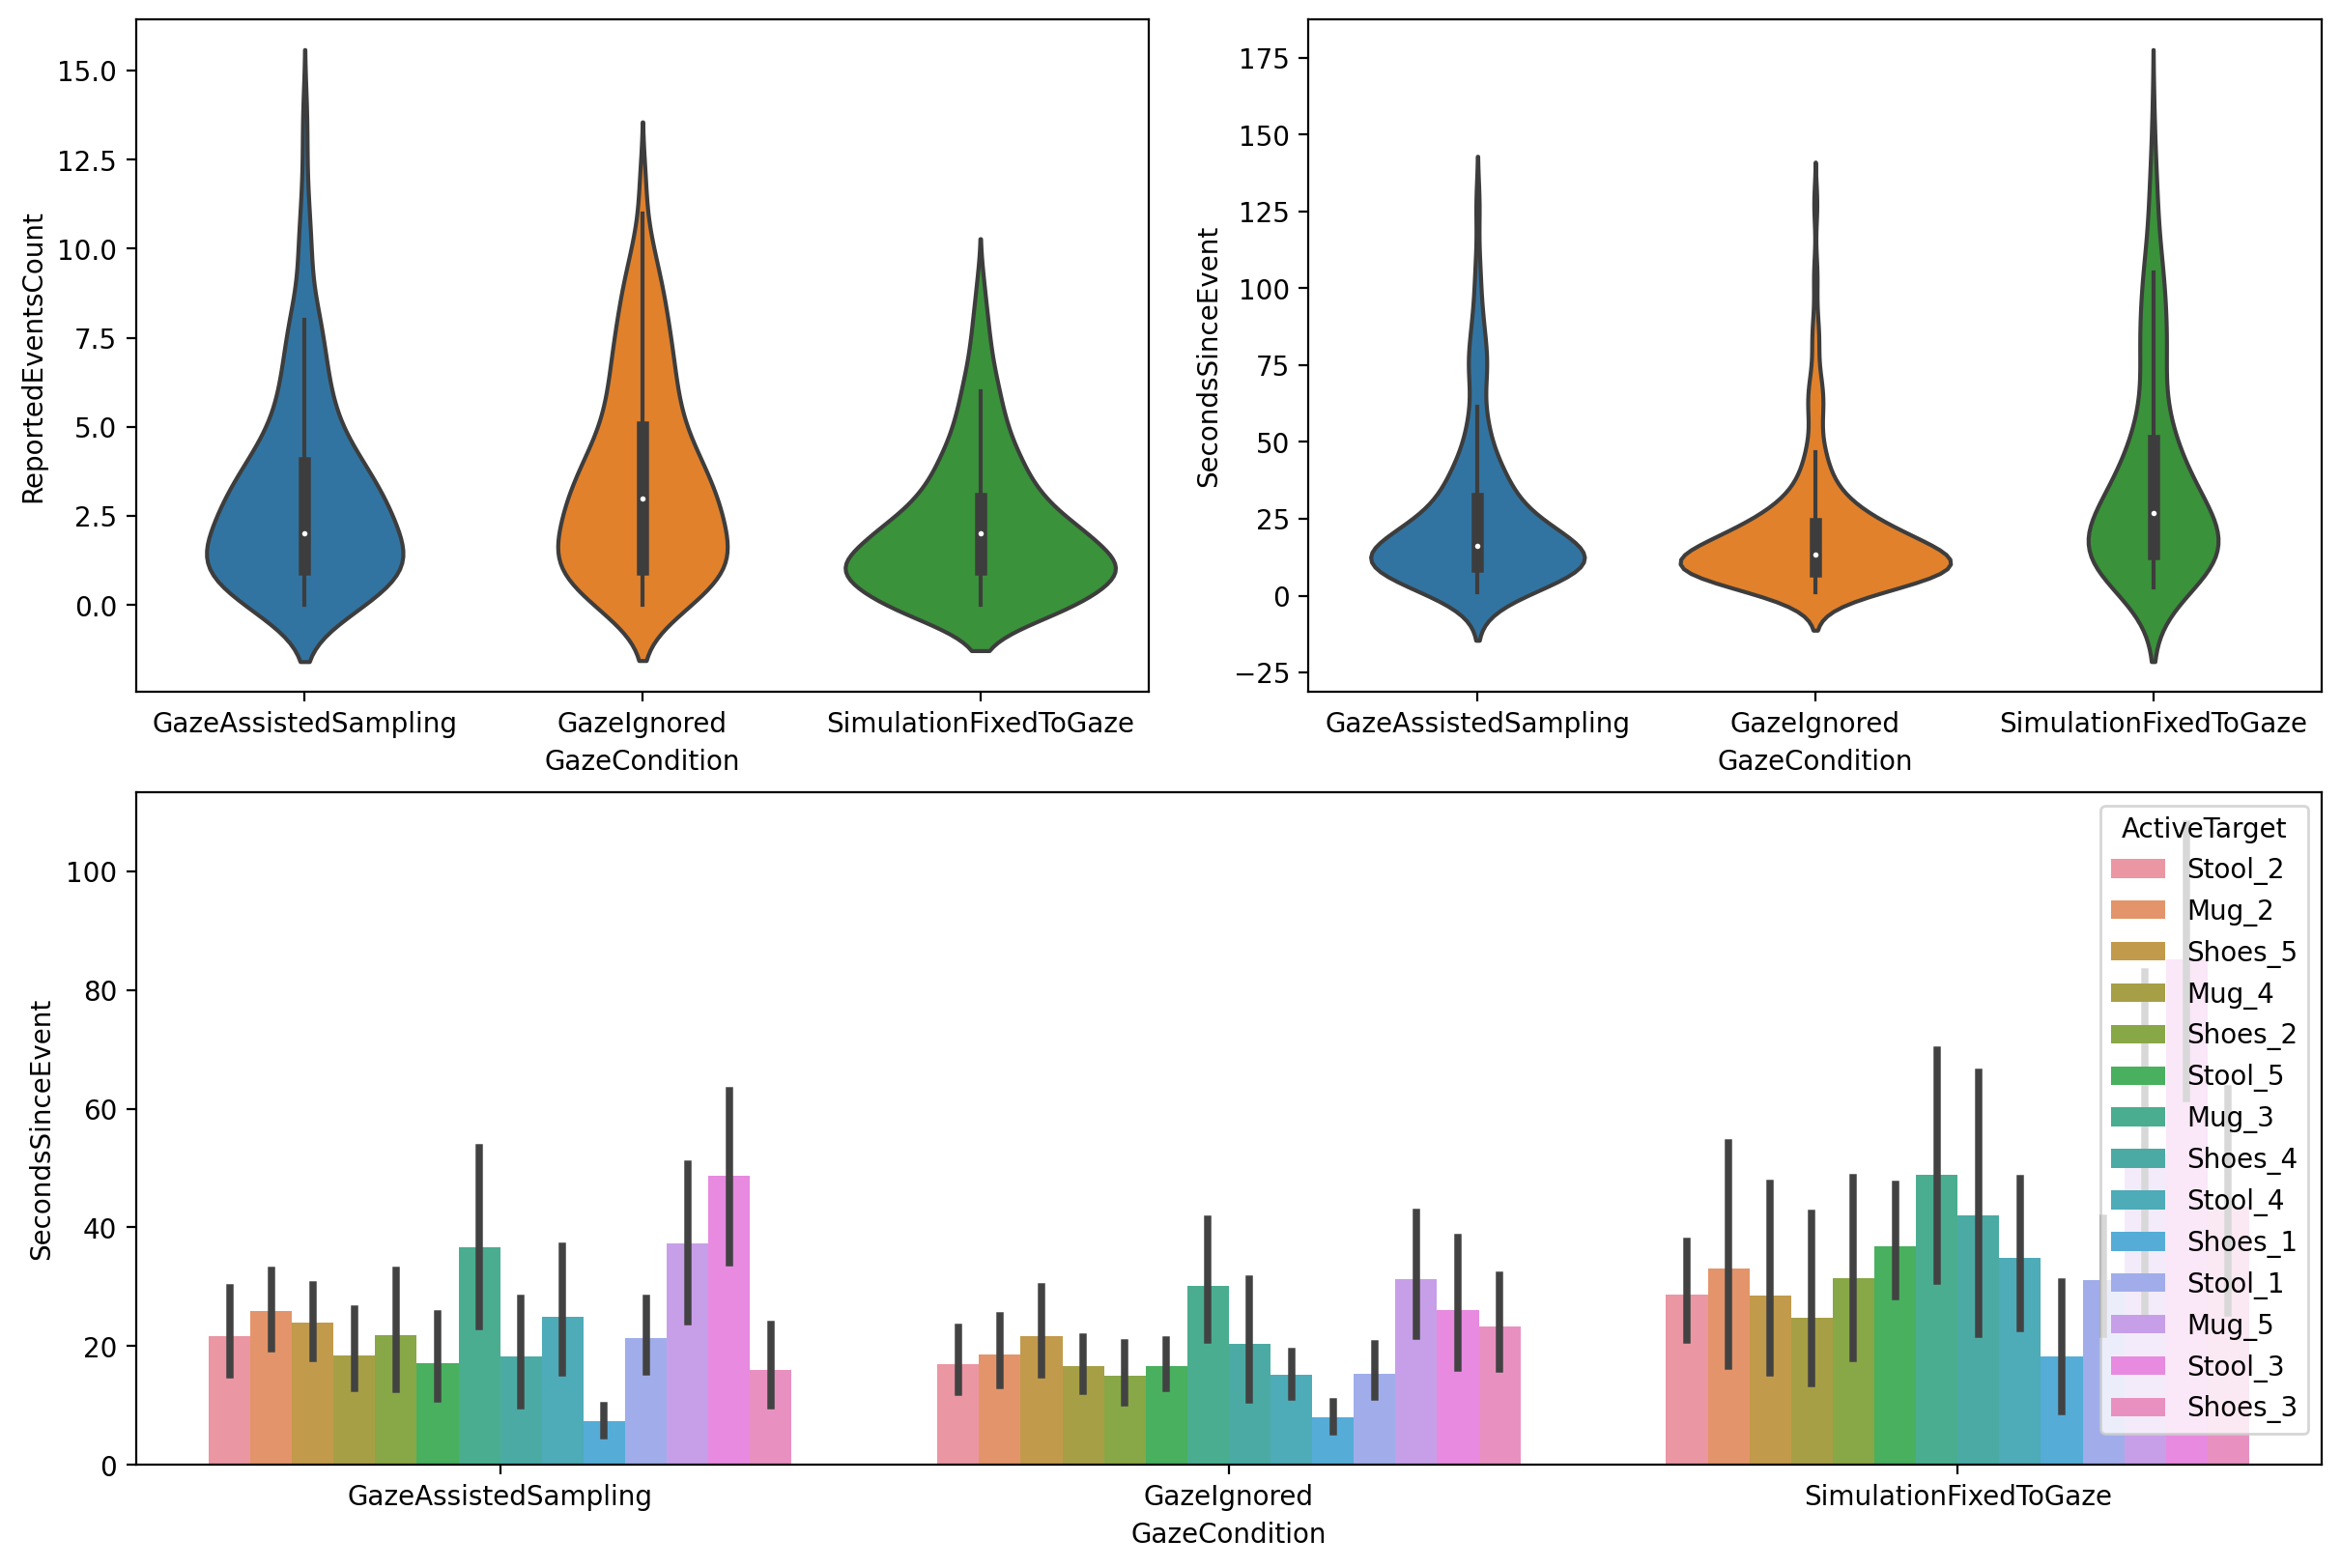

In [85]:
fig = plt.figure(figsize=(12, 8),dpi=200, layout="constrained")
spec = fig.add_gridspec(2, 2)
ax00 = fig.add_subplot(spec[0, 0])
ax01 = fig.add_subplot(spec[0, 1])
ax1 = fig.add_subplot(spec[1, :])

sns.barplot(data=search_times, x='GazeCondition', y='SecondsSinceEvent', hue='ActiveTarget', ax=ax1)
sns.violinplot(data=search_times, x='GazeCondition', y='SecondsSinceEvent', ax=ax01)
sns.violinplot(data=n_targets, x='GazeCondition', y='ReportedEventsCount', ax=ax00)

In [86]:
## Remove invalid targets

# Criteria
MAX_TIME = 200 # seconds. Search times that are higher are discarded
MIN_TIME = .5 # seconds. Search times that are lower are discarded

# Add time since last event as new column
event_mask = data.groupby('TrialIdentifier').ReportedEventsCount.diff() !=0
data['SecondsSinceEvent'] = (data.TimeStamp - data.where(event_mask).TimeStamp.ffill()) * 1e-7

# Search duration is max time since last event when grouped by target
targ_idx = ['TrialIdentifier','ReportedEventsCount']
search_durations = data.groupby(targ_idx).SecondsSinceEvent.max()

# Find the invalid search instances
invalid = search_durations.loc[search_durations>200].index

# Keep dataframe with valid search instances (indexed by instance: i.e. 1 target)
reindexed = data.set_index(targ_idx)
reindexed = reindexed.drop(invalid)

# Reset index to original format
valid = reindexed.reset_index(targ_idx)
valid['ValidEvent'] = valid.groupby('TrialIdentifier').ReportedEventsCount.diff() > 0
valid['ValidEventCount'] = valid.groupby('TrialIdentifier').ValidEvent.cumcount()

## Target reports

In [87]:
def plot_quiver_map(data, axs=None, color=None, fig=None):
    if axs is None:
        fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=200,)
    
    if color is None:
        color = TARGETS.loc[data.ActiveTarget, 'Color'].to_list()
        
        # Put targets in legend
        targets = TARGETS.loc[data.ActiveTarget.unique(), 'Color'] # All targets that were observed in current data
        print(targets)
        handles = [Patch(facecolor=color[:3]+[1.0,], label=trg) for trg, color in targets.items()]
        axs[0].legend(handles=handles)

    
    # Head quiver (first axis)
    x, y = data['XRHeadPosX'], data['XRHeadPosZ']
    u, v = data['XRHeadDirX'], data['XRHeadDirZ']
    axs[0].quiver(x,y,u,v, color=color, scale=15)
    # axs[0].axis('square')
    axs[0].set(title= 'Head')
    
    # Hand Quiver
    x, y = data['HandRPosX'], data['HandRPosZ']
    u, v = data['HandRDirX'], data['HandRDirZ']
    axs[1].quiver(x,y,u,v, color=color, scale=10)
    # axs[1].axis('square')
    axs[1].set(title= 'Right Hand')


    return fig, axs

def plot_targets(targets, ax):
    colors = get_colors(labels=targets.index, alpha=1.)
    color = pd.Series(colors).loc[targets.index].to_list()
    hdl = ax.scatter(targets.PosX, targets.PosZ, c = color)
    return

def get_colors(labels, cmap='viridis', alpha=0.25):
    colormap = matplotlib.colormaps.get_cmap(cmap)
    colors = colormap(np.linspace(0,1,len(labels)))
    colors[:,-1]=alpha
    return {lbl: colors[i].tolist() for i, lbl in enumerate(labels)}

def get_target_locations(filename ='_TargetLocations.tsv', sep='\t'):
    fn = os.path.join(DATA_DIR,filename)
    targets = pd.read_csv(fn, sep=sep).set_index('TargetName')
    return targets


TARGETS = get_target_locations()
TARGETS['Color'] = get_colors(TARGETS.index).values()

In [88]:
nEvents = valid.groupby('TrialIdentifier').ReportedEventsCount.max()
nEvents.sort_values()

TrialIdentifier
S41B7T0     0
S39B7T0     0
S39B4T0     0
S46B2T0     0
S38B9T1     0
           ..
S48B9T2    10
S40B8T0    11
S46B9T1    12
S46B8T1    12
S45B9T1    14
Name: ReportedEventsCount, Length: 162, dtype: int64

In [89]:
valid.columns

Index(['TrialIdentifier', 'ReportedEventsCount', 'TimeStamp', 'XROriginPos',
       'XROriginRot', 'XRHeadPos', 'XRHeadRot', 'HandLPos', 'HandLRot',
       'HandRPos', 'HandRRot', 'CollisionCount', 'FrameCount', 'ActiveTarget',
       'PointLocationHand', 'PointLocationEye', 'PointLocationHead',
       'TargetHit', 'Unnamed: 17', 'Subject', 'Block', 'RelativeTrialNumber',
       'ExperimentalTask', 'GazeCondition', 'XROriginDir', 'XRHeadDir',
       'HandLDir', 'HandRDir', 'XROriginPosX', 'XROriginPosY', 'XROriginPosZ',
       'XROriginRotW', 'XROriginRotX', 'XROriginRotY', 'XROriginRotZ',
       'XRHeadPosX', 'XRHeadPosY', 'XRHeadPosZ', 'XRHeadRotW', 'XRHeadRotX',
       'XRHeadRotY', 'XRHeadRotZ', 'HandLPosX', 'HandLPosY', 'HandLPosZ',
       'HandLRotW', 'HandLRotX', 'HandLRotY', 'HandLRotZ', 'HandRPosX',
       'HandRPosY', 'HandRPosZ', 'HandRRotW', 'HandRRotX', 'HandRRotY',
       'HandRRotZ', 'PointLocationHandX', 'PointLocationHandY',
       'PointLocationHandZ', 'PointLocationE

TargetName
Shoes_2    [0.449368, 0.813768, 0.335384, 0.25]
Stool_5      [0.175707, 0.6979, 0.491033, 0.25]
Mug_3      [0.275191, 0.194905, 0.496005, 0.25]
Shoes_4    [0.814576, 0.883393, 0.110347, 0.25]
Stool_4    [0.122312, 0.633153, 0.530398, 0.25]
Shoes_1    [0.288921, 0.758394, 0.428426, 0.25]
Stool_1    [0.180629, 0.429975, 0.557282, 0.25]
Mug_5       [0.212395, 0.359683, 0.55171, 0.25]
Stool_3    [0.127568, 0.566949, 0.550556, 0.25]
Shoes_3    [0.626579, 0.854645, 0.223353, 0.25]
Stool_2       [0.153364, 0.497, 0.557724, 0.25]
Name: Color, dtype: object


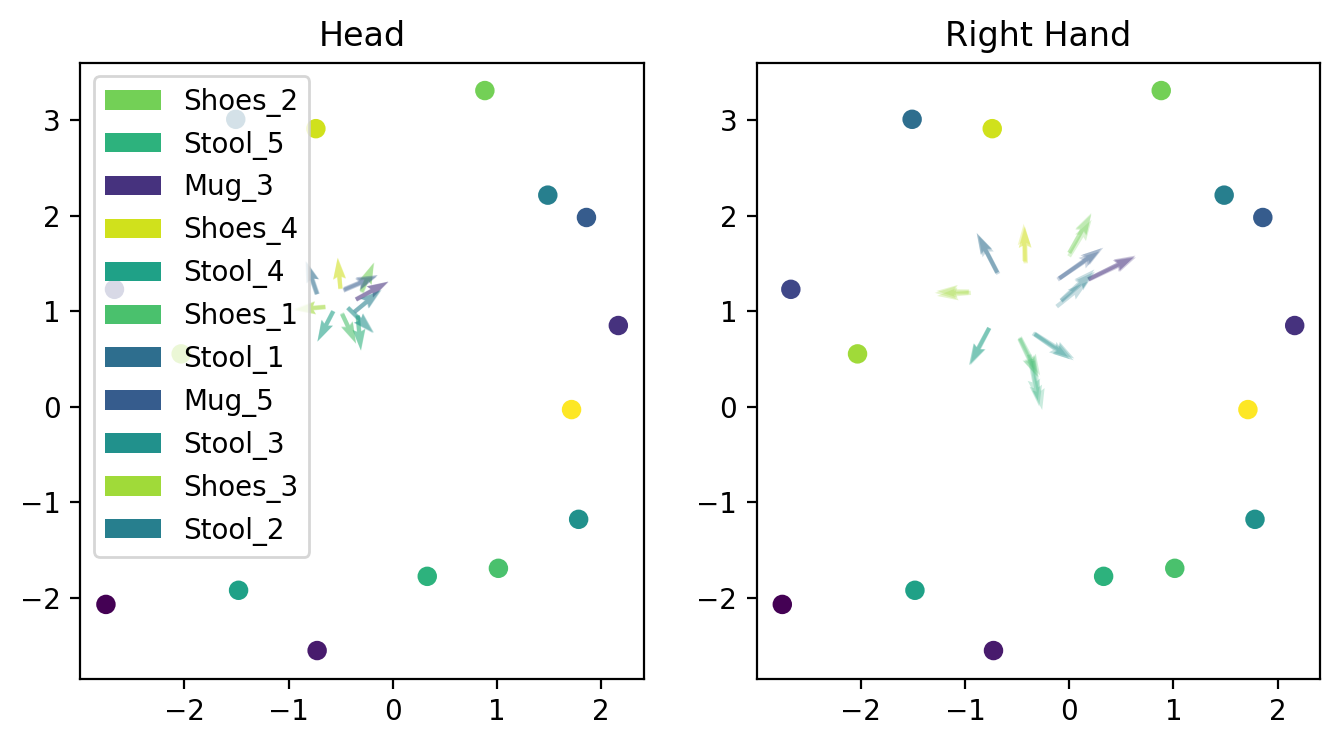

In [90]:
WINDOW = .5

targets = get_target_locations()

event_window_mask = (valid.SecondsSinceEvent < WINDOW) & (valid.ReportedEventsCount>0)
trial_mask = valid.TrialIdentifier == 'S40B8T0' # valid.TrialIdentifier.unique()[9]


# fig, axs = plot_quiver_map(valid.loc[trial_mask], targets=targets)
# fig, axs = plot_quiver_map(valid.loc[event_window_mask & trial_mask], color='red', axs=axs)

fig, axs = plot_quiver_map(valid.loc[event_window_mask & trial_mask])

plot_targets(targets, ax = axs[0])
plot_targets(targets, ax = axs[1])
# axs[0].plot(target_locations['PosX'], target_locations['PosZ'], '.')
plt.show(fig)

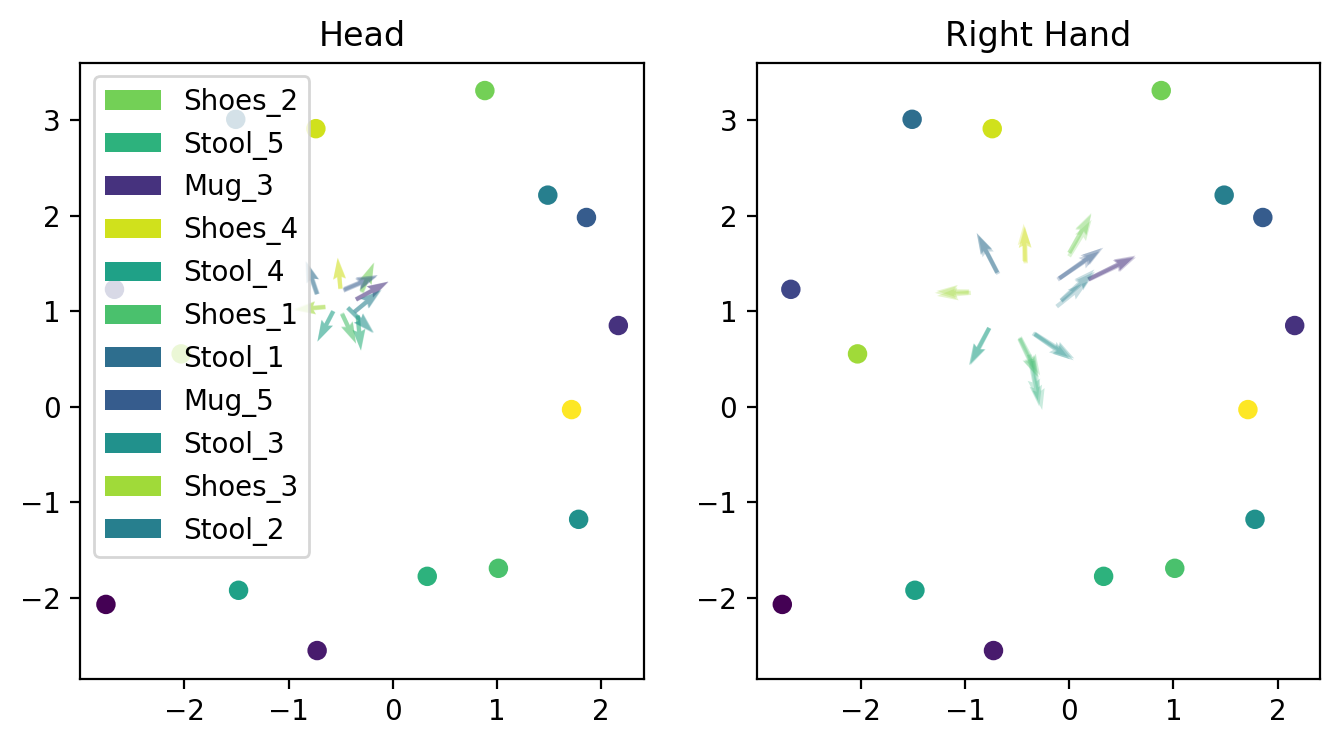

In [91]:
fig

In [54]:
hits = valid.loc[event_window_mask & trial_mask]
# hits = hits[:15].copy()

NameError: name 'd' is not defined

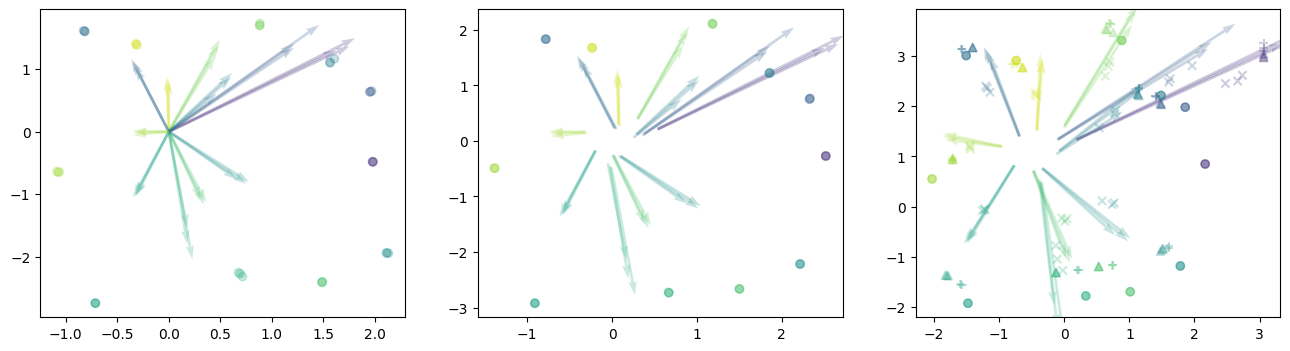

In [70]:
colors = TARGETS.loc[hits.ActiveTarget,'Color']

head_pos = (hits.XRHeadPosX + hits.XRHeadPosZ*1j).values
head_dir = (hits.XRHeadDirX + hits.XRHeadDirZ*1j).values
hand_pos = (hits.HandRPosX + hits.HandRPosZ*1j).values
hand_dir = (hits.HandRDirX + hits.HandRDirZ*1j).values
org_pos = (hits.XROriginPosX + hits.XROriginPosZ * 1j).values
org_dir = (hits.XROriginDirX + hits.XROriginDirZ * 1j).values

trg_pos = (targets.loc[hits['ActiveTarget']].PosX + \
                    targets.loc[hits['ActiveTarget']].PosZ * 1j).values


hand_point = (hits.PointLocationHandX + hits.PointLocationHandZ*1j).values
head_point = (hits.PointLocationHeadX + hits.PointLocationHeadZ*1j).values
eyes_point = (hits.PointLocationEyeX + hits.PointLocationEyeZ*1j).values

# head_pos = head_pos - org_pos
# head_dir = head_dir * np.conj(org_dir)

# hand_pos = hand_pos - org_pos
# hand_dir = hand_dir * np.conj(org_dir)

# trg_pos = trg_pos - org_pos


# Subtract head position
# hand_pos -= head_pos
# trg_pos -= head_pos
hand_pos_ = 0
trg_pos_ = trg_pos - hand_pos

# Rotate by head direction
# hand_dir *= np.conj(head_dir)
# trg_pos *= np.conj(head_dir)
# hand_dir *= np.conj(hand_dir)
# trg_pos *= np.conj(hand_dir)


# # Rotate 90 degrees (for visualization)
# hand_dir_ = hand_dir * 1j
# trg_pos_ = trg_pos_ * 1j


fig, axs = plt.subplots(1,3,figsize=(16,4), dpi=100)


## Relative to hand
hand_pos_ = 0* hand_pos # subtract hand position
trg_pos_ = trg_pos - hand_pos 
# trg_pos_ *= 1j # Rotate 90 degrees (for visualization)
# hand_dir_ = hand_dir * 1j
hand_dir_ = hand_dir * np.conj(org_dir)
# axs[0].quiver(np.real(hand_pos_), np.imag(hand_pos_), np.real(hand_dir_), np.imag(hand_dir_), scale=.5, color=colors)
# axs[0].scatter(np.real(trg_pos_), np.imag(trg_pos_), c=colors)


## Relative to head
head_pos_ = 0* head_pos # subtract head position
hand_pos_ = hand_pos - head_pos
trg_pos_ = trg_pos - head_pos 
# trg_pos_ *= 1j # Rotate 90 degrees (for visualization)
# head_dir_ = head_dir * 1j
# hand_dir_ = hand_dir * 1j

hand_dir_ = hand_dir


# # axs[1].quiver(np.real(head_pos_), np.imag(head_pos_), np.real(head_dir_), np.imag(head_dir_), scale=.5, color=colors)
# axs[1].quiver(np.real(hand_pos_), np.imag(hand_pos_), np.real(hand_dir_), np.imag(hand_dir_), scale=.5, color=colors)
# axs[1].scatter(np.real(trg_pos_), np.imag(trg_pos_), c=colors)




# axs[2].quiver(np.real(head_pos), np.imag(head_pos), np.real(head_dir), np.imag(head_dir), scale=5, color=colors)
# axs[2].quiver(np.real(hand_pos), np.imag(hand_pos), np.real(hand_dir), np.imag(hand_dir), scale=5, color=colors)
axs[2].quiver(np.real(hand_pos), np.imag(hand_pos), np.real(hand_point_), np.imag(hand_point_), scale=5, color=colors)
# axs[2].quiver(np.real(org_pos), np.imag(org_pos), np.real(org_dir), np.imag(org_dir), scale=5, color=colors)
axs[2].scatter(np.real(trg_pos), np.imag(trg_pos), c=colors)
axs[2].scatter(np.real(hand_point), np.imag(hand_point),marker='x', c=colors, )
axs[2].scatter(np.real(eyes_point), np.imag(eyes_point),marker='+', c=colors, )
axs[2].scatter(np.real(head_point), np.imag(head_point),marker='^', c=colors, )

# Targets and pointing vectors corrected for hand position
hand_pos_ = hand_pos - hand_pos
trg_pos_ = trg_pos - hand_pos
hand_point_ = hand_point - hand_pos

axs[0].quiver(np.real(hand_pos_), np.imag(hand_pos_),
              np.real(hand_point_ - hand_pos_), np.imag(hand_point_ - hand_pos_), scale=5, color=colors)
axs[0].scatter(np.real(trg_pos_), np.imag(trg_pos_), c=colors)
# axs[0].scatter(np.real(hand_point_), np.imag(hand_point_),marker='x', c=colors, )


# Targets and pointing vectors corrected for head position
hand_pos_ = hand_pos - head_pos
trg_pos_ = trg_pos - head_pos
hand_point_ = hand_point - head_pos

axs[1].quiver(np.real(hand_pos_), np.imag(hand_pos_),
              np.real(hand_point_ - hand_pos_), np.imag(hand_point_ - hand_pos_), scale=5, color=colors)
axs[1].scatter(np.real(trg_pos_), np.imag(trg_pos_), c=colors)
# axs[1].scatter(np.real(hand_point_), np.imag(hand_point_),marker='x', c=colors, )

In [ ]:
import ptitprince as pt
pt.RainCloud(data=data, x='GazeCondition', y='LocalizationEr')

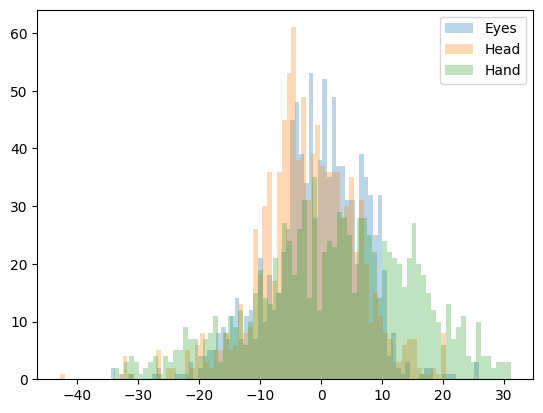

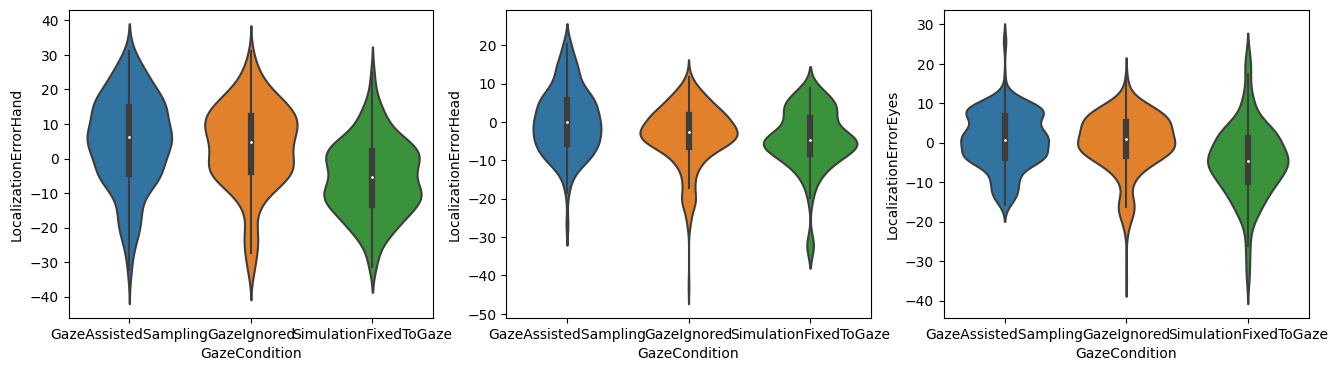

<Axes: xlabel='GazeCondition', ylabel='LocalizationErrorEyes'>

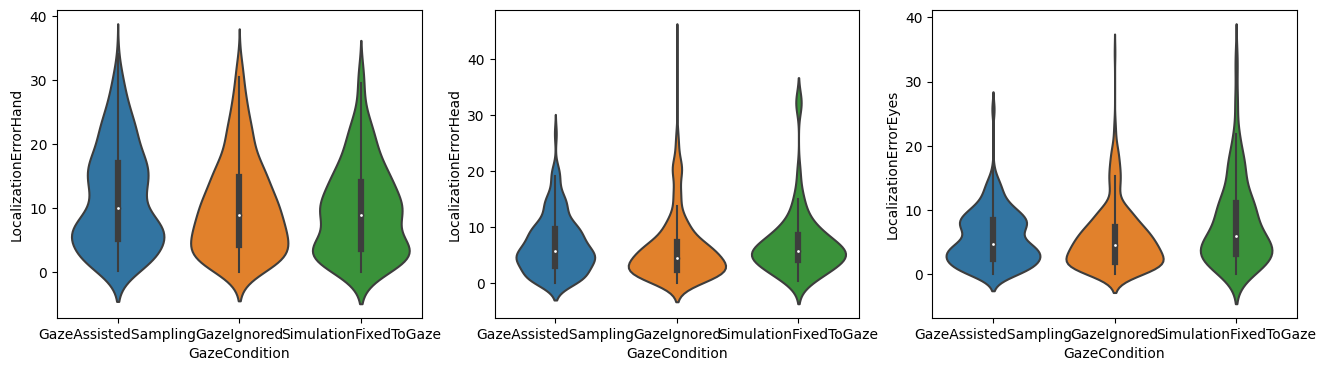

In [178]:
data = valid.loc[event_window_mask]

colors = TARGETS.loc[data.ActiveTarget,'Color']

head_pos = (data.XRHeadPosX + data.XRHeadPosZ*1j).values
head_dir = (data.XRHeadDirX + data.XRHeadDirZ*1j).values
hand_pos = (data.HandRPosX + data.HandRPosZ*1j).values
hand_dir = (data.HandRDirX + data.HandRDirZ*1j).values
org_pos = (data.XROriginPosX + data.XROriginPosZ * 1j).values
org_dir = (data.XROriginDirX + data.XROriginDirZ * 1j).values

trg_pos = (targets.loc[data['ActiveTarget']].PosX + \
                    targets.loc[data['ActiveTarget']].PosZ * 1j).values


hand_point = (data.PointLocationHandX + data.PointLocationHandZ*1j).values
head_point = (data.PointLocationHeadX + data.PointLocationHeadZ*1j).values
eyes_point = (data.PointLocationEyeX + data.PointLocationEyeZ*1j).values



def angle_between(a, b):
    """Calculate the shortest angle between two complex numbers (represented as vectors on the complex plane)
    return value in degrees"""
    theta = np.angle(a) - np.angle(b)
    theta *= 180/np.pi  #convert to degrees
    theta = (theta + 180) % 360 - 180 # find the shortest angle (e.g. -270 -> 90 deg.)
    return theta

valid.loc[event_window_mask, 'LocalizationErrorHand'] = angle_between(hand_point-hand_pos, trg_pos-hand_pos)
valid.loc[event_window_mask, 'LocalizationErrorHead'] = angle_between(head_point-head_pos, trg_pos-head_pos)
valid.loc[event_window_mask, 'LocalizationErrorEyes'] = angle_between(eyes_point-head_pos, trg_pos-head_pos)
data = valid.loc[event_window_mask]
data = data.loc[(abs(data.LocalizationErrorHand) < 35) & (abs(data.LocalizationErrorEyes) <35)]

# miss = (abs(hand_dev) > 20) | (abs(eyes_dev) > 50)


# valid.loc[event_window_mask, 'LocalizationErrorHand'] = hand_dev[~miss]
# # valid.loc[~miss & event_window_mask, 'LocalizationErrorHead'] = head_dev[~miss]
# # valid.loc[~miss & event_window_mask, 'LocalizationErrorEyes'] = eyes_dev[~miss]


plt.hist(data.LocalizationErrorEyes, bins=80, alpha =0.3)
plt.hist(data.LocalizationErrorHead, bins=80, alpha =0.3)
plt.hist(data.LocalizationErrorHand, bins=80, alpha =0.3)
plt.legend(['Eyes', 'Head', 'Hand'])


fig, axs = plt.subplots(1,3,figsize=(16,4), dpi=100)
sns.violinplot(data=data, y='LocalizationErrorHand', x='GazeCondition', ax= axs[0])
sns.violinplot(data=data, y='LocalizationErrorHead', x='GazeCondition', ax= axs[1])
sns.violinplot(data=data, y='LocalizationErrorEyes', x='GazeCondition', ax= axs[2])
plt.show()

fig, axs = plt.subplots(1,3,figsize=(16,4), dpi=100)
sns.violinplot(data=data, y=abs(data.LocalizationErrorHand), x='GazeCondition', ax= axs[0])
sns.violinplot(data=data, y=abs(data.LocalizationErrorHead), x='GazeCondition', ax= axs[1])
sns.violinplot(data=data, y=abs(data.LocalizationErrorEyes), x='GazeCondition', ax= axs[2])

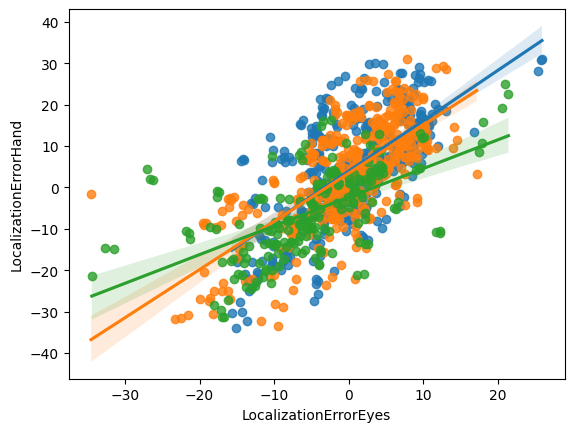

<Axes: xlabel='LocalizationErrorHead', ylabel='LocalizationErrorHand'>

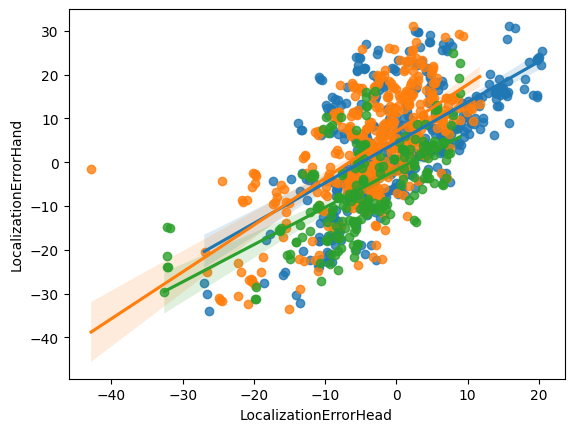

In [180]:
sns.regplot(data=data.loc[data.GazeCondition == 'GazeAssistedSampling'], y='LocalizationErrorHand', x='LocalizationErrorEyes')
sns.regplot(data=data.loc[data.GazeCondition == 'GazeIgnored'], y='LocalizationErrorHand', x='LocalizationErrorEyes')
sns.regplot(data=data.loc[data.GazeCondition == 'SimulationFixedToGaze'], y='LocalizationErrorHand', x='LocalizationErrorEyes')

plt.show()

sns.regplot(data=data.loc[data.GazeCondition == 'GazeAssistedSampling'], y='LocalizationErrorHand', x='LocalizationErrorHead')
sns.regplot(data=data.loc[data.GazeCondition == 'GazeIgnored'], y='LocalizationErrorHand', x='LocalizationErrorHead')
sns.regplot(data=data.loc[data.GazeCondition == 'SimulationFixedToGaze'], y='LocalizationErrorHand', x='LocalizationErrorHead')

TrialIdentifier  ReportedEventsCount           TimeStamp  \
709           S42B2T0                    1  638152555936790717   
710           S42B2T0                    1  638152555938791111   
711           S42B2T0                    1  638152555940798006   
818           S42B2T0                    2  638152556154743099   
819           S42B2T0                    2  638152556156743108   
...               ...                  ...                 ...   
68816         S45B9T2                    7  638156099551153114   
68817         S45B9T2                    7  638156099553154256   
68962         S45B9T2                    8  638156099843110294   
68963         S45B9T2                    8  638156099845120294   
68964         S45B9T2                    8  638156099847120293   

                    XROriginPos           XROriginRot  \
709    (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
710    (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
711    (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
818    (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
819    (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
...                         ...                   ...   
68816  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
68817  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
68962  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
68963  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
68964  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   

                          XRHeadPos                               XRHeadRot  \
709    (-0.69109, 1.58467, 1.03013)   (0.01247, 0.46754, -0.04404, 0.88279)   
710      (-0.69232, 1.584, 1.03174)     (0.01543, 0.46663, -0.045, 0.88317)   
711    (-0.69557, 1.58636, 1.03276)   (0.01005, 0.46357, -0.03924, 0.88514)   
818    (-0.92165, 1.62553, 0.91433)    (-0.0557, 0.98545, 0.15505, -0.0417)   
819     (-0.92439, 1.62617, 0.9153)  (-0.05731, 0.98447, 0.15941, -0.04604)   
...                             ...                                     ...   
68816  (-0.52095, 1.68103, 1.19547)   (0.15248, -0.17998, 0.03398, 0.97119)   
68817  (-0.52911, 1.67842, 1.19132)   (0.16015, -0.22897, 0.04056, 0.95931)   
68962   (-0.42938, 1.70149, 1.0941)   (0.07047, 0.53928, -0.02851, 0.83869)   
68963  (-0.43293, 1.69998, 1.09421)   (0.07614, 0.53598, -0.03085, 0.84023)   
68964   (-0.43471, 1.7014, 1.09308)   (0.06866, 0.53603, -0.03127, 0.84082)   

                           HandLPos                                HandLRot  \
709        (-0.62064, 0.0, 0.87984)                    (0.0, 0.0, 0.0, 1.0)   
710        (-0.62064, 0.0, 0.87984)                    (0.0, 0.0, 0.0, 1.0)   
711        (-0.62064, 0.0, 0.87984)                    (0.0, 0.0, 0.0, 1.0)   
818        (-0.62064, 0.0, 0.87984)                    (0.0, 0.0, 0.0, 1.0)   
819        (-0.62064, 0.0, 0.87984)                    (0.0, 0.0, 0.0, 1.0)   
...                             ...                                     ...   
68816    (-0.7622, 0.8007, 1.20898)    (0.194, -0.04909, -0.31862, 0.92652)   
68817  (-0.76074, 0.79583, 1.18771)   (0.2093, -0.07561, -0.30644, 0.92551)   
68962   (-0.4913, 0.78469, 1.32774)   (-0.0042, 0.52353, -0.37616, 0.76446)   
68963  (-0.49142, 0.78949, 1.33598)  (-0.00736, 0.50757, -0.37117, 0.77753)   
68964  (-0.48774, 0.79229, 1.33929)  (-0.01449, 0.50961, -0.36882, 0.77721)   

                           HandRPos  ... XRHeadDirZ  HandLDirX  HandLDirY  \
709    (-0.50632, 1.33187, 1.15556)  ...   0.562505   0.000000   0.000000   
710    (-0.50896, 1.32802, 1.15816)  ...   0.564035   0.000000   0.000000   
711    (-0.51419, 1.33089, 1.15911)  ...   0.570008   0.000000   0.000000   
818    (-0.95539, 1.41013, 0.72278)  ...  -0.948441   0.000000   0.000000   
819    (-0.95224, 1.42335, 0.71992)  ...  -0.944937   0.000000   0.000000   
...                             ...  ...        ...        ...        ...   
68816  (-0.67625, 1.29086, 1.82724)  ...   0.888715  -0.214589  -0.328206   
68817  (-0.698

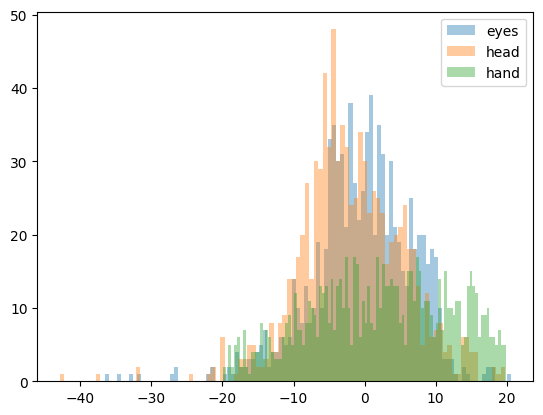

In [133]:
plt.hist(eyes_dev[~miss], bins=100, alpha=0.4)
plt.hist(head_dev[~miss], bins=100, alpha=0.4)
plt.hist(hand_dev[~miss], bins=100, alpha=0.4)
plt.legend(['eyes', 'head', 'hand'])

In [120]:
(abs(hand_dev) > 20).sum()

273

In [ ]:
(hand_dev > 20).sum()

In [33]:
hits.columns


Index(['TrialIdentifier', 'ReportedEventsCount', 'TimeStamp', 'XROriginPos',
       'XROriginRot', 'XRHeadPos', 'XRHeadRot', 'HandLPos', 'HandLRot',
       'HandRPos', 'HandRRot', 'CollisionCount', 'FrameCount', 'ActiveTarget',
       'PointLocationHand', 'PointLocationEye', 'PointLocationHead',
       'TargetHit', 'Unnamed: 17', 'Subject', 'Block', 'RelativeTrialNumber',
       'ExperimentalTask', 'GazeCondition', 'XROriginDir', 'XRHeadDir',
       'HandLDir', 'HandRDir', 'XROriginPosX', 'XROriginPosY', 'XROriginPosZ',
       'XROriginRotW', 'XROriginRotX', 'XROriginRotY', 'XROriginRotZ',
       'XRHeadPosX', 'XRHeadPosY', 'XRHeadPosZ', 'XRHeadRotW', 'XRHeadRotX',
       'XRHeadRotY', 'XRHeadRotZ', 'HandLPosX', 'HandLPosY', 'HandLPosZ',
       'HandLRotW', 'HandLRotX', 'HandLRotY', 'HandLRotZ', 'HandRPosX',
       'HandRPosY', 'HandRPosZ', 'HandRRotW', 'HandRRotX', 'HandRRotY',
       'HandRRotZ', 'PointLocationHandX', 'PointLocationHandY',
       'PointLocationHandZ', 'PointLocationE

In [21]:
colors.reset_index().ActiveTarget.unique()

In [22]:
TARGETS['Color']

In [23]:
hit


In [24]:
trg_dir

In [ ]:
    targets = data.ActiveTarget.unique()

In [ ]:
target_locations = pd.read_csv(os.path.join(DATA_DIR, '_TargetLocations.tsv'), sep='\t').set_index('TargetName')

In [ ]:
axs[0].plot(target_locations['PosX'], target_locations['PosZ'], '.')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [ ]:
target_locations.loc[targets]

PosX     PosY     PosZ
TargetName                                         
Mug_1            -2.754    0.461 -2.071
Shoes_2         0.883    0.000    3.309
Mug_2            -0.727    0.708 -2.554
Stool_4        -1.481    0.529 -1.923
Shoes_1         1.013    0.000 -1.693
Shoes_3        -2.032    0.000    0.552
Shoes_4        -0.739    0.000    2.910
Mug_5             1.858    0.789    1.980
Stool_5         0.330    0.530 -1.777
Mug_4            -2.672    0.514    1.228
Shoes_5         1.715    0.000 -0.031
Stool_2         1.487    0.529    2.214
Stool_3         1.783    0.529 -1.180
Stool_1        -1.508    0.529    3.008
Mug_3             2.164    0.554    0.849

In [ ]:
targets.tolist()

AttributeError: ignored

In [ ]:
event_mask = data.groupby('TrialIdentifier').ReportedEventsCount.diff() == 1
event_frames = np.where(event_mask)[0]


for frame in event_frames:
    data.iloc[frame]

In [ ]:
VS_data = engine_data[:len(engine_data)//4]

# Subdata with only the 'event' frames 
window = 5 # frames after trigger was pressed
event_frames = VS_data.ReportedEventsCount.diff() == 1
event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame-window, event_frame + window)]
VS_events_data = VS_data.iloc[event_window_frames]

NameError: ignored

In [26]:
def plot_quiver_map(data, axs=None, color=None, fig=None):
    if axs is None:
        fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=200,)
    
    # Unique color per target
    targets = data.ActiveTarget.unique()
    colormapping = {trg: i/len(targets) for i,trg in enumerate(targets)}
    coloridx = data.ActiveTarget.replace(colormapping)
    
    # Head quiver (first axis)
    x, y = data['XRHeadPosX'], data['XRHeadPosZ']
    u, v = np.cos(data['XRHeadDirY']), np.sin(data['XRHeadDirY'])
    if color is None: 
        axs[0].quiver(x,y,u,v, coloridx, scale=15, alpha = .1,)
    else:
        axs[0].quiver(x,y,u,v, color=color, scale=15, alpha = .2,)
    axs[0].axis('square')
    axs[0].set(title= 'Head')
    
    # Hand Quiver
    x, y = data['HandRPosX'], data['HandRPosZ']
    u, v = np.cos(data['HandRDirY']), np.sin(data['HandRDirY'])
    if color is None: 
        axs[1].quiver(x,y,u,v, coloridx, scale=10, alpha = .1)
    else:
        axs[1].quiver(x,y,u,v, color=color, scale=10, alpha = .2)
    axs[1].axis('square')
    axs[1].set(title= 'Right Hand')


    return fig, axs
    

# Subdata with only the 'event' frames 
window = 5 # frames after trigger was pressed
event_frames = VS_data.ReportedEventsCount.diff() == 1
event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame-window, event_frame + window)]
VS_events_data = VS_data.iloc[event_window_frames]

print(f'Including {window} frames after trigger:')
fig, axs = plot_quiver_map(VS_data.iloc[event_window_frames])
plot_quiver_map(VS_data.loc[event_frames], color='red', axs=axs)

after = np.where(event_frames)[0] + window
before = np.where(event_frames)[0] - window
plot_quiver_map(VS_data.iloc[before], color='green', axs=axs)
plot_quiver_map(VS_data.iloc[after], color='blue', axs=axs)

plt.show()


# _ = plot_quiver_map(SR_data)

# # rand = np.random.randint(0,len(VS_data), event_frames.sum())
# # event_frames = np.zeros_like(event_frames)
# # event_frames[rand] = True
# event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame - window, event_frame)]
# VS_events_data = VS_data.iloc[event_window_frames]

# print(f'Including {window} frames before trigger:')
# _= plot_quiver_map(VS_events_data)

In [27]:
subjects = ['test']
data = engine_data.loc[eye_data.Block>0] # Exclude practice block
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects
VS_data = data.loc[data.ExperimentalTask == 'VisualSearch']
SR_data = data.loc[data.ExperimentalTask == 'SceneRecognition']





In [28]:
quat = VS_events_data.XRHeadRot.iloc[0]

quat_to_rotvec(quat)


In [ ]:
quat_to_euler(quat)

In [ ]:
def quat_to_rotvec(x):
    if type(x) == str:
        quat_tuple = ast.literal_eval(x) # convert string -> tuple
    quat_obj = Rotation.from_quat(quat_tuple)
    return quat_obj.as_rotvec(degrees=True)

In [ ]:
# Subdata with only the 'event' frames 
window = 5 # frames after trigger was pressed
event_frames = VS_data.ReportedEventsCount.diff() == 1
event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame-window, event_frame + window)]
VS_events_data = VS_data.iloc[event_window_frames]



NameError: ignored

In [ ]:
VS_events_data.XRHeadRot.apply()

Quiver map around the event frames:

In [ ]:
def plot_quiver_map(data, axs=None, color=None, fig=None):
    if axs is None:
        fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=200,)
    
    # Unique color per target
    targets = data.ActiveTarget.unique()
    colormapping = {trg: i/len(targets) for i,trg in enumerate(targets)}
    coloridx = data.ActiveTarget.replace(colormapping)
    
    # Head quiver (first axis)
    x, y = data['XRHeadPosX'], data['XRHeadPosZ']
    u, v = np.cos(data['XRHeadRotEulerY']), np.sin(data['XRHeadRotEulerY'])
    if color is None: 
        axs[0].quiver(x,y,u,v, coloridx, scale=15, alpha = .1,)
    else:
        axs[0].quiver(x,y,u,v, color=color, scale=15, alpha = .2,)
    axs[0].axis('square')
    axs[0].set(title= 'Head')
    
    # Hand Quiver
    x, y = data['HandRPosX'], data['HandRPosZ']
    u, v = np.cos(data['HandRRotEulerY']), np.sin(data['HandRRotEulerY'])
    if color is None: 
        axs[1].quiver(x,y,u,v, coloridx, scale=10, alpha = .1)
    else:
        axs[1].quiver(x,y,u,v, color=color, scale=10, alpha = .2)
    axs[1].axis('square')
    axs[1].set(title= 'Right Hand')


    return fig, axs
    

# Subdata with only the 'event' frames 
window = 5 # frames after trigger was pressed
event_frames = VS_data.ReportedEventsCount.diff() == 1
event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame-window, event_frame + window)]
VS_events_data = VS_data.iloc[event_window_frames]

print(f'Including {window} frames after trigger:')
fig, axs = plot_quiver_map(VS_data.iloc[event_window_frames])
plot_quiver_map(VS_data.loc[event_frames], color='red', axs=axs)

after = np.where(event_frames)[0] + window
before = np.where(event_frames)[0] - window
plot_quiver_map(VS_data.iloc[before], color='green', axs=axs)
plot_quiver_map(VS_data.iloc[after], color='blue', axs=axs)

plt.show()


# _ = plot_quiver_map(SR_data)

# # rand = np.random.randint(0,len(VS_data), event_frames.sum())
# # event_frames = np.zeros_like(event_frames)
# # event_frames[rand] = True
# event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame - window, event_frame)]
# VS_events_data = VS_data.iloc[event_window_frames]

# print(f'Including {window} frames before trigger:')
# _= plot_quiver_map(VS_events_data)

NameError: ignored

In [ ]:
ev_data = VS_data.iloc[event_window_frames]
plt.plot(ev_data.TimeStamp, ev_data.XRHeadRotEulerY, '-')

NameError: ignored

In [ ]:
event_frames

array([ True,    True,    True, ...,    True, False, False])

In [ ]:

plt.plot(VSdata.loc[event_mask, 'XRHeadRotEulerY'])

In [ ]:
def plot_gaze_maps(data):
    fig, axs = plt.subplots(1,3,figsize=(12,4), dpi=100)
    for i, condition in enumerate(data.GazeCondition.unique()):
        mask = data.GazeCondition == condition

        axs[i].scatter(data.loc[mask, 'GazeDirectionNormInEyeX'],
                                data.loc[mask, 'GazeDirectionNormInEyeY'], alpha = 0.002, color='#9e1111')
        axs[i].axis('square')
        axs[i].set(xlim = [-0.8,0.8],
                            ylim = [-0.8,0.8], 
                            title= condition)
    plt.show()
    return fig, axs

# Which data to show
subjects = ['S31']
data = eye_data.loc[eye_data.Block>0] # Exclude practice block
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects
VSdata = data.loc[data.ExperimentalTask == 'VisualSearch']
SRdata = data.loc[data.ExperimentalTask == 'SceneRecognition']

print(f'all data (subjects: {subjects}):')
plot_gaze_maps(data)

print('visual search trials:')
plot_gaze_maps(VSdata)

print('scene recognition trials:')
_= plot_gaze_maps(SRdata)

{'S31B0T0': 'GazeIgnored',
 'S31B0T1': 'GazeIgnored',
 'S31B0T2': 'GazeIgnored',
 'S31B0T3': 'GazeAssistedSampling',
 'S31B0T4': 'GazeAssistedSampling',
 'S31B0T5': 'SimulationFixedToGaze',
 'S31B0T6': 'SimulationFixedToGaze',
 'S31B0T7': 'GazeIgnored',
 'S31B1T0': 'SimulationFixedToGaze',
 'S31B1T1': 'SimulationFixedToGaze',
 'S31B1T3': 'SimulationFixedToGaze',
 'S31B2T0': 'GazeIgnored',
 'S31B2T1': 'GazeIgnored',
 'S31B2T2': 'GazeIgnored',
 'S31B2T3': 'GazeIgnored',
 'S31B3T0': 'GazeAssistedSampling',
 'S31B3T1': 'GazeAssistedSampling',
 'S31B3T2': 'GazeAssistedSampling',
 'S31B3T3': 'GazeAssistedSampling',
 'S31B4T0': 'GazeIgnored',
 'S31B4T1': 'GazeIgnored',
 'S31B4T2': 'GazeIgnored',
 'S31B4T3': 'GazeIgnored',
 'S31B5T0': 'GazeAssistedSampling',
 'S31B5T1': 'GazeAssistedSampling',
 'S31B5T2': 'GazeAssistedSampling',
 'S31B5T3': 'GazeAssistedSampling',
 'S31B6T0': 'SimulationFixedToGaze',
 'S31B6T1': 'SimulationFixedToGaze',
 'S31B6T2': 'SimulationFixedToGaze',
 'S31B6T3': 'Simulat

In [ ]:

prop_from_ID(eye_data[0].TrialIdentifier, 'GazeCondition')

KeyError: ignored

In [ ]:
eye_data[['GazeDirX', 'GazeDirY', 'GazeDirZ']] = eye_data['GazeDirectionNormInEye'].apply(pd.Series)

In [ ]:
# Put your dataframe here
df = pd.DataFrame({'A':[1,2], 'B':[(1,2), (3,4)]}) 
df.B

0        (1, 2)
1        (3, 4)
Name: B, dtype: object

In [ ]:
eye_data.GazeDirectionNormInEye[:10].apply(pd.Series)

0
0    (0.01634, 0.08493, 0.99625)
1    (0.01268, 0.05301, 0.99850)
2    (0.01411, 0.03772, 0.99918)
3    (0.01411, 0.03772, 0.99918)
4    (0.01411, 0.03772, 0.99918)
5    (0.02559, 0.01903, 0.99948)
6    (0.02559, 0.01903, 0.99948)
7    (0.02559, 0.01903, 0.99948)
8    (0.02559, 0.01903, 0.99948)
9    (0.01859, 0.00856, 0.99979)

In [ ]:
trial_data

GazeCondition EnvironmentName EnvironmentClass    Glasses    \
0                         GazeIgnored            Playground                         None    Glasses     
1                         GazeIgnored            Playground                         None    Glasses     
2                         GazeIgnored             bedroom_4                    Bedroom    Glasses     
3        GazeAssistedSampling            Playground                         None    Glasses     
4        GazeAssistedSampling            bathroom_3                 Bathroom    Glasses     
5     SimulationFixedToGaze            Playground                         None    Glasses     
6        GazeAssistedSampling                living_5                     Living    Glasses     
7                         GazeIgnored            Playground                         None    Glasses     
8        GazeAssistedSampling            Playground                         None    Glasses     
9        GazeAssistedSampling             bedroom_3                    Bedroom    Glasses     
10     GazeAssistedSampling                living_3                     Living    Glasses     
11     GazeAssistedSampling             bedroom_2                    Bedroom    Glasses     
12                        GazeIgnored             bedroom_1                    Bedroom    Glasses     
13                        GazeIgnored             kitchen_1                    Kitchen    Glasses     
14                        GazeIgnored             kitchen_2                    Kitchen    Glasses     
15    SimulationFixedToGaze            Playground                         None    Glasses     
16    SimulationFixedToGaze             kitchen_3                    Kitchen    Glasses     
17    SimulationFixedToGaze            bathroom_2                 Bathroom    Glasses     
18    SimulationFixedToGaze                living_2                     Living    Glasses     
19                        GazeIgnored            Playground                         None    Glasses     
20                        GazeIgnored             bedroom_2                    Bedroom    Glasses     
21                        GazeIgnored                living_2                     Living    Glasses     
22                        GazeIgnored             bedroom_3                    Bedroom    Glasses     
23    SimulationFixedToGaze            Playground                         None    Glasses     
24    SimulationFixedToGaze             kitchen_3                    Kitchen    Glasses     
25    SimulationFixedToGaze                living_1                     Living    Glasses     
26    SimulationFixedToGaze             kitchen_2                    Kitchen    Glasses     
27                        GazeIgnored            Playground                         None    Glasses     
28    SimulationFixedToGaze            Playground                         None    Glasses     
29     GazeAssistedSampling            Playground                         None    Glasses     
30                        GazeIgnored            Playground                         None    Glasses     
31     GazeAssistedSampling            Playground                         None    Glasses     
32    SimulationFixedToGaze            Playground                         None    Glasses     

        GazeRaySensitivity DataDelimiter ReportedRoomCategory    \
0                                    1.0                                                             None     
1                                    1.0                                                             None     
2                                    1.0                                                         Living     
3                                    1.0                                                         Living     
4                                    1.0                                                        Bedroom     
5                                    1.0                                   

In [ ]:
def load_eye_tracking_data_from_filenames(filenames):
    eye_data =


eye_data = pd.DataFrame()

for i in range(len(eye_fn)):
    new = pd.read_csv(eye_fn[i],sep = '\t', converters={"GazeDirectionNormInEye": ast.literal_eval})
    new['block'] = int(eye_fn[i][1:3])
    ID = eye_fn[i][1:6]
    new['Trial_ID'] = ID
    new['GazeCondition'] = trial_data.loc[trial_data['Trial_ID'] == ID, 
                                                                                'GazeCondition']
    eye_data = pd.concat([eye_data,new], ignore_index=True)



trial_data


In [ ]:
for i in range(len(eye_data)):
    x, y, z = eye_data.GazeDirectionNormInEye[i].replace('(', '').replace(')', '').split(',')
    eye_data.loc[i, 'x'] = float(x)
    eye_data.loc[i, 'y'] = float(y)
    eye_data.loc[i, 'z'] = float(z)

KeyboardInterrupt: ignored

In [ ]:
eye_data_cp = eye_data.copy()

In [ ]:
import ast

In [ ]:
gazeDirection = eye_data.GazeDirectionNormInEye.apply(pd.Series, index=['x','y','z'])

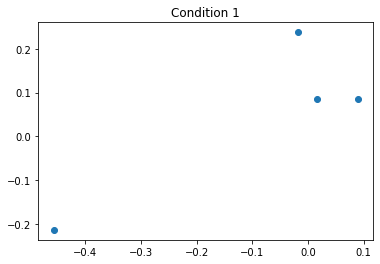

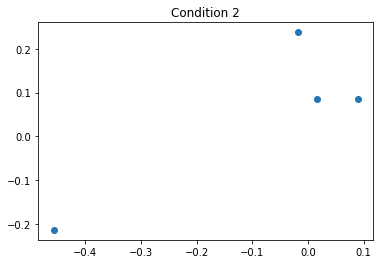

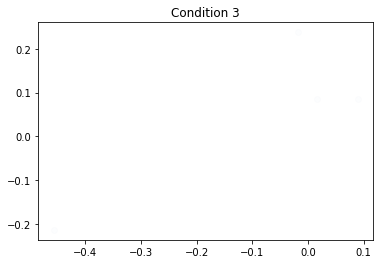

In [ ]:
c1 = eye_data.loc[eye_data.GazeCondition=='GazeIgnored']
c2 = eye_data.loc[eye_data.GazeCondition=='SimulationFixedToGaze']
c3 = eye_data.loc[eye_data.GazeCondition=='GazeAssistedSampling']


plt.scatter(c1.x, c1.y)
plt.title('Condition 1')
plt.show()


plt.scatter(c1.x, c1.y)
plt.title('Condition 2')
plt.show()

plt.scatter(c1.x, c1.y, alpha = 0.01)
plt.title('Condition 3')
plt.show()

In [ ]:
sr_mask = trial_data.EnvironmentName != 'Playground'
vs_mask = ~sr_mask & (trial_data.block > 6)

trial_data.loc[sr_mask,'Correct'] = (trial_data.loc[sr_mask,'ReportedRoomCategory'] ==
                                                             trial_data.loc[sr_mask,'EnvironmentClass']).astype(float)

VSData = trial_data.loc[vs_mask]
SRData = trial_data.loc[sr_mask] 

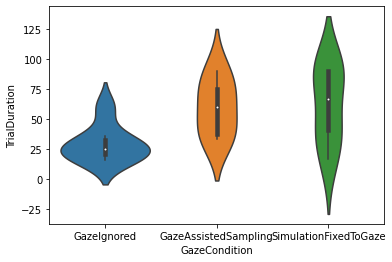

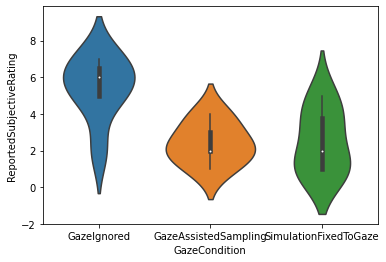

<AxesSubplot:xlabel='GazeCondition', ylabel='Correct'>

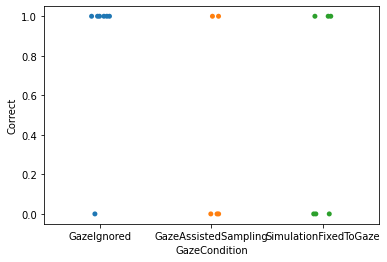

In [ ]:
sns.violinplot(data=SRData, x='GazeCondition', y='TrialDuration')
plt.show()
sns.violinplot(data=SRData, x='GazeCondition', y='ReportedSubjectiveRating')
plt.show()
sns.stripplot(data=SRData, x='GazeCondition', y='Correct')

In [ ]:
SRData.groupby('GazeCondition').mean()

GazeRaySensitivity    ReportedSubjectiveRating    \
GazeCondition                                                                                                                 
GazeAssistedSampling                                    1.0                                    2.400000     
GazeIgnored                                                     1.0                                    5.428571     
SimulationFixedToGaze                                 1.0                                    2.500000     

                                             ReportedEventsCount    TrialDuration    Unnamed: 10    \
GazeCondition                                                                                                                        
GazeAssistedSampling                            0.800000            59.185452                    NaN     
GazeIgnored                                             0.857143            29.313163                    NaN     
SimulationFixedToGaze                         0.500000            61.535683                    NaN     

                                                    block     Correct    
GazeCondition                                                            
GazeAssistedSampling     0.600000    0.400000    
GazeIgnored                        2.571429    0.857143    
SimulationFixedToGaze    4.000000    0.500000

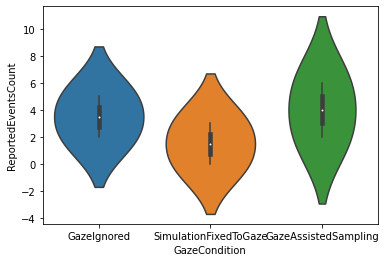

<AxesSubplot:xlabel='GazeCondition', ylabel='ReportedSubjectiveRating'>

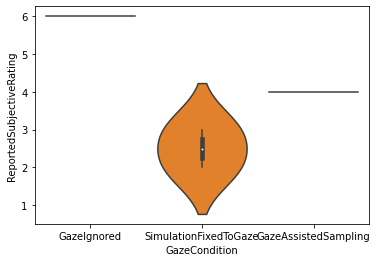

In [ ]:
sns.violinplot(data=VSData, x='GazeCondition', y='ReportedEventsCount')
plt.show()
sns.violinplot(data=VSData, x='GazeCondition', y='ReportedSubjectiveRating')